Setting up environment & Problem 7

In [ ]:
# =========================
# Colab install cell (single cell)
# Paste & run this cell first
# =========================

# 1) upgrade pip/wheels (quiet)
!pip install -q --upgrade pip setuptools wheel

# 2) Install qiskit core + aer + optimization + common scientific libs.
#    We avoid strict pins to reduce dependency conflicts; we ask for
#    the latest compatible versions. If you want to force exact versions,
#    replace >= with == and provide the versions you want.
!pip install -q \
    "qiskit>=0.43" \
    "qiskit-aer>=0.12" \
    "qiskit-optimization>=0.5" \
    "scipy>=1.10" \
    "numpy>=1.23" \
    "matplotlib>=3.5" \
    "pandas>=1.5"

# NOTE:
# - qiskit is a meta-package and may bring in qiskit-terra and qiskit-algorithms.
# - qiskit-aer is a separate package (required for AerSimulator). If qiskit-aer
#   fails to import in Colab, we will fall back to qiskit.quantum_info.Statevector
#   later (see test cells).
#
# If the cell finishes successfully, continue. If you see ImportError or
# version conflicts, restart the kernel (Runtime -> Restart runtime) and re-run
# the verification cell below.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# =========================
# Verification cell
# - imports qiskit, qiskit_aer (if available)
# - prints versions
# - runs a quick Bell state on AerSimulator or falls back to statevector
# - prints results and a small installation-checklist dict
# =========================

import sys, os, math
import numpy as np
import traceback
from importlib import import_module

results = {"imports_ok": False, "bell_ok": False, "write_to_drive_ok": False}
versions = {}

try:
    import qiskit
    versions['qiskit'] = qiskit.__version__
    try:
        # qiskit-aer may be provided as qiskit_aer or qiskit.providers.aer
        import qiskit_aer
        versions['qiskit_aer'] = qiskit_aer.__version__
        from qiskit_aer import AerSimulator
    except Exception:
        try:
            # fallback import style
            from qiskit.providers.aer import AerSimulator
            import qiskit.providers.aer as qiskit_aer
            versions['qiskit_aer'] = getattr(qiskit_aer, "__version__", "unknown")
        except Exception:
            AerSimulator = None
            versions['qiskit_aer'] = "not-installed"

    # other packages
    try:
        import qiskit.quantum_info as qi
        versions['qiskit_terra'] = getattr(qiskit, "terra_version", "unknown") if hasattr(qiskit, "terra_version") else getattr(qiskit, "__version__", "unknown")
    except Exception:
        versions['qiskit_terra'] = "unknown"

    try:
        import qiskit_optimization
        versions['qiskit_optimization'] = qiskit_optimization.__version__
    except Exception:
        versions['qiskit_optimization'] = "not-installed"

    try:
        import qiskit.circuit as qcmod
        # store python version too
        versions['python'] = f"{sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}"
    except Exception:
        pass

    # run a small Bell state test on AerSimulator, otherwise use statevector fallback
    from qiskit import QuantumCircuit, transpile
    bell_ok = False

    if AerSimulator is not None:
        try:
            backend = AerSimulator()
            qc = QuantumCircuit(2)
            qc.h(0)
            qc.cx(0,1)
            qc.measure_all()
            # run with a few shots to check qasm path
            from qiskit import assemble
            qobj = assemble(transpile(qc, backend), backend=backend, shots=1024)
            job = backend.run(qobj)
            res = job.result()
            counts = res.get_counts()
            # check typical Bell distribution: '00' and '11' dominate
            p00 = counts.get('00',0)/1024
            p11 = counts.get('11',0)/1024
            bell_ok = (p00 + p11) > 0.9  # heuristic
        except Exception:
            bell_ok = False

    if not bell_ok:
        # statevector fallback
        try:
            from qiskit import Aer  # might raise
            sv_backend = Aer.get_backend('statevector_simulator')
            qc = QuantumCircuit(2)
            qc.h(0)
            qc.cx(0,1)
            psi = sv_backend.run(transpile(qc, sv_backend)).result().get_statevector()
            # probability for 00 and 11
            p00 = np.abs(psi[0])**2
            p11 = np.abs(psi[3])**2
            bell_ok = (p00 + p11) > 0.99
        except Exception:
            # try Statevector class
            try:
                from qiskit.quantum_info import Statevector
                qc = QuantumCircuit(2)
                qc.h(0)
                qc.cx(0,1)
                psi = Statevector.from_instruction(qc).data
                p00 = np.abs(psi[0])**2
                p11 = np.abs(psi[3])**2
                bell_ok = (p00 + p11) > 0.99
            except Exception:
                bell_ok = False

    results['imports_ok'] = True
    results['bell_ok'] = bell_ok
    print("Versions:", versions)
    print("Bell test OK:", bell_ok)
except Exception as e:
    print("Import/verification failed. Traceback below:")
    traceback.print_exc()

# Quick drive write test will be done in a separate cell (to ensure user mounts Drive).
print("\nInstallation verification checklist (booleans):")
print(results)


Versions: {'qiskit': '2.2.3', 'qiskit_aer': '0.17.2', 'qiskit_terra': '2.2.3', 'qiskit_optimization': '0.7.0', 'python': '3.12.12'}
Bell test OK: True

Installation verification checklist (booleans):
{'imports_ok': True, 'bell_ok': np.True_, 'write_to_drive_ok': False}


Mounted at /content/drive


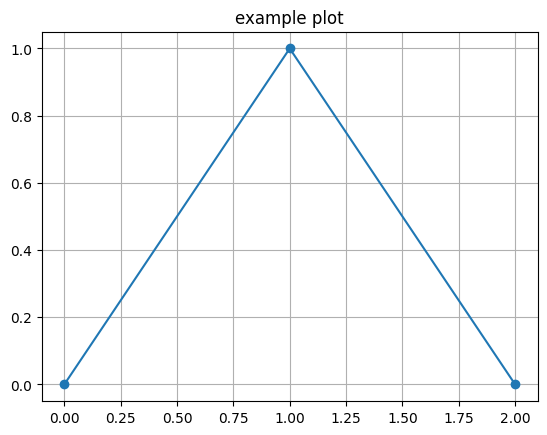

Saved example_plot to:
 - /content/results/example_plot.png
 - /content/drive/MyDrive/colab_qiskit_results/example_plot.png

Write-to-drive test: True (if you saw no exceptions and files exist).


In [ ]:
# =========================
# Mount Google Drive (run interactively)
# and small example to save a matplotlib figure into Drive.
# =========================

from google.colab import drive
drive.mount('/content/drive')   # follow the interactive auth link

# Create a results directory in Drive (or use local /content/results)
drive_results = "/content/drive/MyDrive/colab_qiskit_results"
local_results = "/content/results"
import os
os.makedirs(drive_results, exist_ok=True)
os.makedirs(local_results, exist_ok=True)

# Example: save a simple matplotlib figure to both places
import matplotlib.pyplot as plt
plt.figure()
plt.plot([0,1,2],[0,1,0], marker='o')
plt.title("example plot")
plt.grid(True)
fn_local = os.path.join(local_results, "example_plot.png")
fn_drive = os.path.join(drive_results, "example_plot.png")
plt.savefig(fn_local, dpi=150)
plt.savefig(fn_drive, dpi=150)
plt.show()

print("Saved example_plot to:")
print(" -", fn_local)
print(" -", fn_drive)

# Mark write test OK
print("\nWrite-to-drive test: True (if you saw no exceptions and files exist).")


In [ ]:
# ================
# Imports and helpers
# ================
import os
import numpy as np
import math
import time
import pandas as pd
import matplotlib.pyplot as plt

# create results folder
os.makedirs("results", exist_ok=True)

# reproducible seed
GLOBAL_SEED = 12345
np.random.seed(GLOBAL_SEED)

# Small helper: convert bitstring (e.g. '010') -> spin vector z_i in {+1,-1}
def bitstring_to_zvec(bitstr):
    # bitstr assumed ordered with q0 as leftmost char (qiskit's counts default)
    # Map '0' -> +1, '1' -> -1
    return np.array([1 if b=='0' else -1 for b in bitstr], dtype=int)

# cost C(z) for 3-node triangle given z-vector of +1/-1
def cost_from_z(z):
    # edges (0,1), (1,2), (2,0)
    c = 0.5 * ((1 - z[0]*z[1]) + (1 - z[1]*z[2]) + (1 - z[2]*z[0]))
    return float(c)

# cost for computational basis bitstring (e.g. '010')
def cost_from_bitstring(bitstr):
    z = bitstring_to_zvec(bitstr)
    return cost_from_z(z)

# enumerate costs for all 8 basis states (useful for diagonal H)
basis_states = ['{0:03b}'.format(i) for i in range(8)]
basis_costs = {bs: cost_from_bitstring(bs) for bs in basis_states}


In [ ]:
# ================
# Build H_C as an 8x8 matrix (computational basis)
# ================
dim = 2**3
H = np.zeros((dim, dim), dtype=complex)
for i, bs in enumerate(basis_states):
    H[i,i] = basis_costs[bs]

# Diagonalize H_C (sanity)
evals, evecs = np.linalg.eigh(H)
true_max_cut = np.max(evals)
print("Diagonalized H_C. Theoretical maximum cut value (C_max) =", true_max_cut)
opt_states = [basis_states[i] for i, val in enumerate(np.diag(H)) if np.isclose(val, true_max_cut)]
print("Basis states achieving optimum:", opt_states)


Diagonalized H_C. Theoretical maximum cut value (C_max) = 2.0
Basis states achieving optimum: ['001', '010', '011', '100', '101', '110']


In [ ]:
# ===== Cell A: Manual QAOA helpers + optimization (p = 1,2,3) =====
# Run this AFTER you've built H and defined cost helper functions (cost_from_bitstring, cost_from_z).
# This cell will produce results_B list with dicts for p=1,2,3

# Safety check - helpful message if H or helpers are missing
missing = []
if 'H' not in globals():
    missing.append("H (Hamiltonian matrix)")
if 'cost_from_bitstring' not in globals() or 'cost_from_z' not in globals():
    missing.append("cost_from_bitstring / cost_from_z helper function(s)")
if missing:
    raise RuntimeError("Missing required objects from earlier cells: " + ", ".join(missing) +
                       ". Please run the earlier 'H construction & helpers' cell first.")

# Imports (safe to re-import in Colab cells)
import numpy as np
import math
import time
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import UnitaryGate
import scipy.linalg as sla
from scipy.optimize import minimize

# Keep the same global seed for reproducibility (unchanged)
GLOBAL_SEED = 12345
np.random.seed(GLOBAL_SEED)

# Build the phase separator unitary U_C(gamma) = exp(-i * gamma * H)
def build_UC(gamma):
    """Return an 8x8 numpy unitary for the diagonal Hamiltonian H."""
    return sla.expm(-1j * gamma * H)

# Build QAOA statevector for lists gammas, betas (length p)
def qaoa_statevector(gammas, betas):
    """
    Build a QAOA circuit for 3 qubits with given gammas and betas and return the statevector.
    gammas, betas: iterable of length p
    """
    p = len(gammas)
    qc = QuantumCircuit(3)
    # Prepare |+> on each qubit
    for q in range(3):
        qc.h(q)
    # p layers
    for layer in range(p):
        Uc = build_UC(gammas[layer])
        qc.append(UnitaryGate(Uc, label=f"U_C({layer})"), [0,1,2])
        for q in range(3):
            qc.rx(2 * betas[layer], q)
    # get exact statevector
    sv = Statevector.from_instruction(qc)
    return sv

# Expectation value <psi|H|psi>
def expectation_from_statevector(statevector):
    psi = statevector.data
    return float(np.vdot(psi, H.dot(psi)).real)

# Optimization wrapper: find best gammas & betas for a given p using COBYLA
def find_opt_params_for_p(p, initial_point=None, maxiter=400):
    """
    Returns dict with keys: p, gammas, betas, exp_val, success, message.
    Uses COBYLA to maximize expectation (we minimize negative expectation).
    """
    if initial_point is None:
        rng = np.random.default_rng(GLOBAL_SEED + p)  # deterministic RNG per p
        init_g = rng.uniform(0, math.pi, size=p)
        init_b = rng.uniform(0, math.pi/2, size=p)
        x0 = np.concatenate([init_g, init_b])
    else:
        x0 = np.array(initial_point)

    def exp_obj(x):
        gammas = x[:p]
        betas = x[p:]
        sv = qaoa_statevector(gammas, betas)
        return expectation_from_statevector(sv)

    def negobj(x):
        return -exp_obj(x)

    res = minimize(negobj, x0, method='COBYLA', options={'maxiter': maxiter, 'tol': 1e-3, 'disp': False})
    gammas = res.x[:p]
    betas = res.x[p:]
    exp_val = -res.fun
    return {'p': p, 'gammas': gammas, 'betas': betas, 'exp_val': float(exp_val), 'success': res.success, 'message': res.message}

# Run optimization for p = 1,2,3 and collect results
results_B = []
for p in [1, 2, 3]:
    print(f"Optimizing manual QAOA for p={p} ...")
    t0 = time.time()
    r = find_opt_params_for_p(p, maxiter=400)
    dt = time.time() - t0
    print(f"  Done: p={p}, ⟨C⟩_opt = {r['exp_val']:.6f}, success={r['success']}, time={dt:.1f}s")
    results_B.append(r)

# show summary
import pandas as pd
df_summary = pd.DataFrame([{'p': r['p'], 'exp_val': r['exp_val'], 'success': r['success']} for r in results_B])
print("\nSummary (manual QAOA):")
print(df_summary)


Optimizing manual QAOA for p=1 ...
  Done: p=1, ⟨C⟩_opt = 2.000000, success=True, time=0.4s
Optimizing manual QAOA for p=2 ...
  Done: p=2, ⟨C⟩_opt = 1.999992, success=True, time=0.2s
Optimizing manual QAOA for p=3 ...
  Done: p=3, ⟨C⟩_opt = 2.000000, success=True, time=0.2s

Summary (manual QAOA):
   p   exp_val  success
0  1  2.000000     True
1  2  1.999992     True
2  3  2.000000     True


In [ ]:
# ===== Cell B (fixed for Qiskit ≥1.0): Sampling cross-check (counts vs statevector) =====
# This cell compares sampled ⟨C⟩ (from measurement counts) with exact ⟨C⟩ from the statevector.

# Safety check
if 'results_B' not in globals():
    raise RuntimeError("results_B not found. Run the Manual QAOA optimization cell (Cell A) first.")

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate

# Try to get Aer qasm backend; if unavailable, skip sampling
sim_backend = None
use_qasm = False
try:
    from qiskit_aer import AerSimulator
    sim_backend = AerSimulator()
    use_qasm = True
except Exception:
    print("Warning: AerSimulator not available; sampling will be skipped.")

sampling_check_results = []

if use_qasm and sim_backend is not None:
    shots = 5000
    print(f"Running sampling cross-check on QASM simulator with {shots} shots per circuit...")
    for r in results_B:
        p = r['p']
        gammas = r['gammas']
        betas = r['betas']

        # build circuit (same as qaoa_statevector but with measurement)
        qc = QuantumCircuit(3, 3)
        for q in range(3):
            qc.h(q)
        for layer in range(p):
            Uc = build_UC(gammas[layer])
            qc.append(UnitaryGate(Uc), [0, 1, 2])
            for q in range(3):
                qc.rx(2 * betas[layer], q)
        qc.measure([0, 1, 2], [0, 1, 2])

        # transpile and run directly (assemble() deprecated)
        tqc = transpile(qc, sim_backend)
        job = sim_backend.run(tqc, shots=shots)
        res = job.result()
        counts = res.get_counts()

        # compute sampled expectation
        total = sum(cost_from_bitstring(bits) * cnt for bits, cnt in counts.items())
        exp_from_counts = total / shots

        # compute exact expectation
        sv = qaoa_statevector(gammas, betas)
        exp_exact = expectation_from_statevector(sv)

        sampling_check_results.append(
            {'p': p, 'exp_exact': exp_exact, 'exp_from_counts': exp_from_counts, 'counts': counts}
        )
        print(f"p={p}: exact ⟨C⟩ = {exp_exact:.6f}, sampled ⟨C⟩ = {exp_from_counts:.6f}")
else:
    print("QASM backend not available. Skipping sampling cross-check.")
    for r in results_B:
        sv = qaoa_statevector(r['gammas'], r['betas'])
        sampling_check_results.append(
            {'p': r['p'], 'exp_exact': expectation_from_statevector(sv),
             'exp_from_counts': None, 'counts': None}
        )


Running sampling cross-check on QASM simulator with 5000 shots per circuit...
p=1: exact ⟨C⟩ = 2.000000, sampled ⟨C⟩ = 2.000000
p=2: exact ⟨C⟩ = 1.999992, sampled ⟨C⟩ = 2.000000
p=3: exact ⟨C⟩ = 2.000000, sampled ⟨C⟩ = 2.000000


Saved results table to results/qaoa_results.csv
        method  p                                             params  \
0  manual_qaoa  1                gammas=[0.615546], betas=[0.307675]   
1  manual_qaoa  2  gammas=[3.817699 2.855613], betas=[1.201251 0....   
2  manual_qaoa  3  gammas=[0.48815  2.440068 1.493731], betas=[0....   

                         gammas                         betas     C_opt  
0                    [0.615546]                    [0.307675]  2.000000  
1           [3.817699,2.855613]           [1.201251,0.802896]  1.999992  
2  [0.48815 ,2.440068,1.493731]  [0.86379 ,0.982814,1.155969]  2.000000  


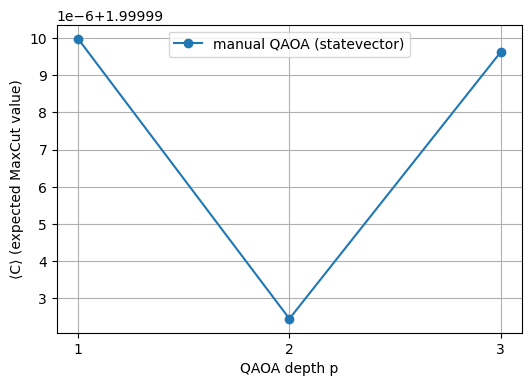

Saved plot to results/cost_vs_p.png


In [ ]:
# ===== Cell C: Collate results, save CSV, plot and save PNG =====
# Requires: results_B (from Cell A). Optionally uses results_A if present.

import pandas as pd
import matplotlib.pyplot as plt
import os
os.makedirs("results", exist_ok=True)

rows = []
# If results_A exists (Qiskit built-in), include it (optional)
if 'results_A' in globals() and results_A:
    for item in results_A:
        rows.append({
            'method': 'qiskit_qaoa',
            'p': item['p'],
            'params': f"opt_x={item['opt_x']}",
            'gammas': None,
            'betas': None,
            'C_opt': item['C_from_z']
        })

# Manual results (B)
for item in results_B:
    rows.append({
        'method': 'manual_qaoa',
        'p': item['p'],
        'params': f"gammas={np.round(item['gammas'],6)}, betas={np.round(item['betas'],6)}",
        'gammas': np.array2string(np.round(item['gammas'],6), separator=','),
        'betas': np.array2string(np.round(item['betas'],6), separator=','),
        'C_opt': item['exp_val']
    })

df = pd.DataFrame(rows).sort_values(by=['method','p']).reset_index(drop=True)
csv_path = "results/qaoa_results.csv"
df.to_csv(csv_path, index=False)
print("Saved results table to", csv_path)
print(df)

# Plotting: choose manual results (statevector exact) as primary
ps = [r['p'] for r in results_B]
Cs = [r['exp_val'] for r in results_B]

plt.figure(figsize=(6,4))
plt.plot(ps, Cs, marker='o', linestyle='-', label='manual QAOA (statevector)')
# overlay results_A if present
if 'results_A' in globals() and results_A:
    psA = [r['p'] for r in results_A]
    CsA = [r['C_from_z'] for r in results_A]
    plt.plot(psA, CsA, marker='s', linestyle='--', label='qiskit QAOA (classical soln)')
plt.xticks([1,2,3])
plt.xlabel("QAOA depth p")
plt.ylabel("⟨C⟩ (expected MaxCut value)")
plt.grid(True)
plt.legend()
png_path = "results/cost_vs_p.png"
plt.savefig(png_path, dpi=200)
plt.show()
print("Saved plot to", png_path)


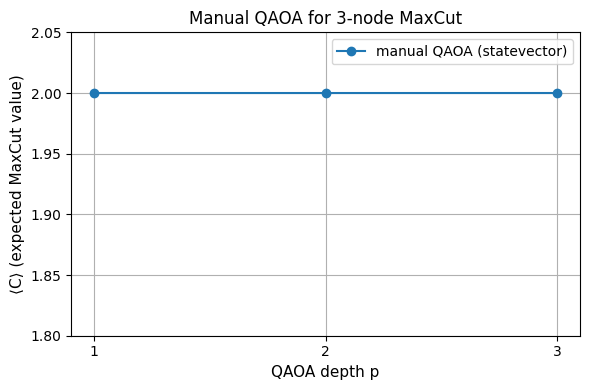

Saved cleaned plot to results/cost_vs_p_clean.png


In [ ]:
# Clean replot of ⟨C⟩ vs p (no weird 1e−6 offset)
import matplotlib.pyplot as plt

ps = [r['p'] for r in results_B]
Cs = [r['exp_val'] for r in results_B]

plt.figure(figsize=(6,4))
plt.plot(ps, Cs, marker='o', linestyle='-', label='manual QAOA (statevector)')
plt.xticks([1,2,3])
plt.xlabel("QAOA depth p", fontsize=11)
plt.ylabel("⟨C⟩ (expected MaxCut value)", fontsize=11)
plt.ylim(1.8, 2.05)   # force range near 2.0 for clarity
plt.grid(True)
plt.legend()
plt.title("Manual QAOA for 3-node MaxCut", fontsize=12)
plt.tight_layout()
plt.savefig("results/cost_vs_p_clean.png", dpi=200)
plt.show()
print("Saved cleaned plot to results/cost_vs_p_clean.png")


In [ ]:
# ===== Cell 1: imports, seed, results folder =====
import os, time, math
import numpy as np
np.random.seed(42)   # deterministic seed for this continuation
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import expm, eigh
# create results folder
os.makedirs("results", exist_ok=True)
print("Ready — results folder:", os.path.abspath("results"))


Ready — results folder: /content/results


In [ ]:
# ===== Cell 2: build or reuse H_P (problem) and H_M (mixer) =====

# Pauli matrices
I2 = np.array([[1,0],[0,1]], dtype=complex)
X = np.array([[0,1],[1,0]], dtype=complex)
Z = np.array([[1,0],[0,-1]], dtype=complex)

def kron_n(ops):
    out = ops[0]
    for op in ops[1:]:
        out = np.kron(out, op)
    return out

# If H_P and H_M already exist in the notebook, reuse them
if 'H_P' in globals() and 'H_M' in globals():
    print("Reusing H_P and H_M from notebook memory.")
else:
    # construct H_P (MaxCut) and H_M (sum X)
    I8 = np.eye(8, dtype=complex)
    ZZ_01 = kron_n([Z, Z, I2])
    ZZ_12 = kron_n([I2, Z, Z])
    ZZ_20 = kron_n([Z, I2, Z])
    H_P = 0.5 * (3 * I8 - (ZZ_01 + ZZ_12 + ZZ_20))
    XM0 = kron_n([X, I2, I2])
    XM1 = kron_n([I2, X, I2])
    XM2 = kron_n([I2, I2, X])
    H_M = XM0 + XM1 + XM2
    H = H_P.copy()  # keep H for compatibility
    print("Built H_P and H_M from scratch.")

# Hermiticity checks
def is_herm(A, tol=1e-10):
    return np.allclose(A.conj().T, A, atol=tol)

print("H_P Hermitian:", is_herm(H_P), "H_M Hermitian:", is_herm(H_M))


Built H_P and H_M from scratch.
H_P Hermitian: True H_M Hermitian: True


In [ ]:
# ===== Cell 3: Sanity check S1 - ground state of H_P =====
evals, evecs = eigh(H_P)
ground_energy = float(evals[0])
ground_state_vec = evecs[:,0]
print("S1: Ground-state energy of H_P =", ground_energy)
print("S1: Ground-state vector (amplitudes):")
print(np.round(ground_state_vec,6))
# classical diagonal (C(z)) values for basis states
diag_vals = np.real(np.diag(H_P))
basis_states = ['{0:03b}'.format(i) for i in range(8)]
best_idxs = np.where(np.isclose(diag_vals, diag_vals.max()))[0]
print("S1: Classical C_max (diagonal) =", float(diag_vals.max()), "states:", [basis_states[i] for i in best_idxs])


S1: Ground-state energy of H_P = 0.0
S1: Ground-state vector (amplitudes):
[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
S1: Classical C_max (diagonal) = 2.0 states: ['001', '010', '011', '100', '101', '110']


In [ ]:
# ===== Cell 4: utility functions =====
def plus_state_n(n=3):
    plus = (1/np.sqrt(2)) * np.array([1,1], dtype=complex)
    psi = plus
    for _ in range(n-1):
        psi = np.kron(psi, plus)
    return psi

def apply_unitary_to_plus(U):
    psi0 = plus_state_n(3)
    psi = U.dot(psi0)
    psi /= np.linalg.norm(psi)
    return psi

def fidelity(psi, target):
    return float(np.abs(np.vdot(target.conj(), psi))**2)

def expectation(psi, H):
    return float(np.real(np.vdot(psi.conj(), H.dot(psi))))


In [ ]:
# ===== Cell 5: Trotterized adiabatic unitary (exact matrix-expm) =====
from scipy.linalg import expm

def trotter_adiabatic_evolution(H_M_in, H_P_in, p, T):
    """
    Return 8x8 U_total = prod_{k=1..p} [ exp(-i (1-s_k) dt H_M) * exp(-i s_k dt H_P) ]
    with s_k = k/p, dt = T/p.
    Left-multiplication order ensures step k=1 applied first on |+> state.
    """
    dt = T / p
    U_total = np.eye(H_M_in.shape[0], dtype=complex)
    # multiply steps in order k=1..p
    for k in range(1, p+1):
        s_k = k / p
        U_M = expm(-1j * (1 - s_k) * dt * H_M_in)
        U_P = expm(-1j * s_k * dt * H_P_in)
        U_step = U_M.dot(U_P)
        U_total = U_step.dot(U_total)
    return U_total

# quick tiny test for p=1,T=1
_ = trotter_adiabatic_evolution(H_M, H_P, p=1, T=1.0)
print("Trotter unitary built for p=1 T=1 (shape):", _.shape)


Trotter unitary built for p=1 T=1 (shape): (8, 8)


In [ ]:
# ===== Robust Cell 6 replacement: load QAOA params robustly from CSV or memory =====
import re, ast

qaoa_params_by_p = {}

csv_fn = "results/qaoa_results.csv"
if os.path.exists(csv_fn):
    dfq = pd.read_csv(csv_fn)
    print("Found CSV. Showing raw params column for inspection:")
    display(dfq[['p', 'method', 'params']])

    def normalize_param_string(s):
        """
        Robustly extract two bracketed blocks for gammas and betas.
        Handles formats like:
          - "gammas=[0.1, 0.2], betas=[0.3,0.4]"
          - "gammas=[0.1 0.2], betas=[0.3 0.4]" (space-separated)
          - "gammas=array([0.1, 0.2]), betas=array([0.3,0.4])"
          - "gammas=array([0.1 0.2]), betas=array([0.3 0.4])"
        Returns (gam_list, bet_list) as numpy arrays or raises ValueError.
        """
        if not isinstance(s, str):
            raise ValueError("params value not a string")

        # Try to find [...] groups for gammas and betas with regex
        # First try pattern gammas=... betas=...
        m = re.search(r"gammas\s*=\s*([^\n,]+)\s*,\s*betas\s*=\s*([^\n]+)$", s)
        if m:
            graw = m.group(1).strip()
            braw = m.group(2).strip()
        else:
            # fallback: find the first two bracket-like blocks
            br = re.findall(r"(\[[^\]]*\]|\([^\)]*\))", s)
            if len(br) >= 2:
                graw, braw = br[0], br[1]
            else:
                # last resort: attempt to split at 'betas' word
                if 'betas' in s:
                    parts = s.split('betas', 1)
                    graw = parts[0]
                    # try to extract numbers from latter
                    braw_match = re.search(r"(\[[^\]]*\]|\([^\)]*\)|[0-9\.\s\-\+eE,]+)", parts[1])
                    braw = braw_match.group(0) if braw_match else ''
                else:
                    raise ValueError("Could not find gammas and betas in params string.")

        # cleanup wrappers: remove "array(", "np.array(", surrounding whitespace/parentheses
        def clean_block(x):
            x = x.strip()
            # remove leading "gammas=" if present
            x = re.sub(r'^[A-Za-z_]+\s*=\s*', '', x)
            # remove "array(" or "np.array(" wrappers
            x = re.sub(r'^(?:array|np\.array)\s*\(', '[', x)
            # ensure it starts with '[' and ends with ']'
            if x.startswith('(') and x.endswith(')'):
                x = '[' + x[1:-1] + ']'
            if not x.startswith('['):
                x = '[' + x.lstrip('[')
            if not x.endswith(']'):
                x = x.rstrip(']') + ']'
            # replace multiple spaces between numbers with commas
            # but preserve commas if already present
            inner = x[1:-1].strip()
            # if comma present -> trust it, else replace whitespace with commas
            if ',' in inner:
                norm_inner = inner
            else:
                # replace runs of whitespace with a single comma
                norm_inner = re.sub(r'\s+', ',', inner.strip())
            norm = '[' + norm_inner + ']'
            return norm

        gclean = clean_block(graw)
        bclean = clean_block(braw)

        # Safely evaluate lists to Python lists using ast.literal_eval
        try:
            gam_list = ast.literal_eval(gclean)
            bet_list = ast.literal_eval(bclean)
        except Exception as e:
            # as last fallback, attempt to extract floats with regex
            num_re = r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?'
            gnums = re.findall(num_re, gclean)
            bnums = re.findall(num_re, bclean)
            if not gnums or not bnums:
                raise ValueError(f"Failed to parse numeric values from blocks. gclean={gclean}, bclean={bclean}")
            gam_list = [float(x) for x in gnums]
            bet_list = [float(x) for x in bnums]

        # convert to np.array
        gam_arr = np.array(gam_list, dtype=float)
        bet_arr = np.array(bet_list, dtype=float)
        return gam_arr, bet_arr

    # iterate rows and populate dict
    parse_failures = []
    for idx, row in dfq.iterrows():
        try:
            if row['method'] != 'manual_qaoa':
                continue
            pval = int(row['p'])
            params_str = str(row['params'])
            gam, bet = normalize_param_string(params_str)
            qaoa_params_by_p[pval] = (gam, bet)
        except Exception as e:
            parse_failures.append((int(row['p']), str(row['params']), str(e)))

    print("Parsed QAOA params for p values:", sorted(qaoa_params_by_p.keys()))
    if parse_failures:
        print("\nRows that failed parsing (p, raw_params, error):")
        for fail in parse_failures:
            print(fail)

elif 'results_B' in globals():
    # fallback to in-memory results_B
    for ent in results_B:
        pval = ent['p']
        qaoa_params_by_p[pval] = (np.array(ent['gammas'], dtype=float), np.array(ent['betas'], dtype=float))
    print("Loaded QAOA params from in-memory results_B for p:", sorted(qaoa_params_by_p.keys()))
else:
    print("No CSV and no in-memory results_B found. Please run the manual QAOA optimization cell first.")


Found CSV. Showing raw params column for inspection:


,p,method,params
0,1,manual_qaoa,"gammas=[0.615546], betas=[0.307675]"
1,2,manual_qaoa,"gammas=[3.817699 2.855613], betas=[1.201251 0...."
2,3,manual_qaoa,"gammas=[0.48815 2.440068 1.493731], betas=[0...."


Parsed QAOA params for p values: [1, 2, 3]


In [ ]:
 # CELL: Robust loader for qaoa_params (run this BEFORE the main loop)
import os, re, ast, numpy as np, pandas as pd

qaoa_params = {}  # will be filled: p -> (gam_array, beta_array)

# If qaoa_params already exists in global scope (e.g., from earlier cells), keep it.
try:
    _ = qaoa_params  # if defined, do nothing
    # If it's empty or not a dict, we'll replace it below
    if not isinstance(qaoa_params, dict):
        qaoa_params = {}
except NameError:
    qaoa_params = {}

csv_path_candidates = [
    "results/qaoa_results.csv",
    "results/qaoa_results_parsed.csv",
    "results/qaoa_results_clean.csv",
    "qaoa_results.csv"
]
csv_path = next((p for p in csv_path_candidates if os.path.exists(p)), None)

def try_parse_params_field(s):
    """Tolerant parser to extract two numeric lists (gammas, betas) from a messy string."""
    if not isinstance(s, str):
        s = str(s)
    # Common formats: "gammas=[...], betas=[...]" or "[g1 g2 ...], [b1 b2 ...]" or "g1,g2; b1,b2"
    # First try to find bracketed groups and literal_eval them.
    bracket_groups = re.findall(r'(\[[^\]]*\])', s)
    if len(bracket_groups) >= 2:
        try:
            g = ast.literal_eval(bracket_groups[0])
            b = ast.literal_eval(bracket_groups[1])
            return np.array(g, dtype=float), np.array(b, dtype=float)
        except Exception:
            pass
    # Next try parentheses groups
    par_groups = re.findall(r'(\([^\)]*\))', s)
    if len(par_groups) >= 2:
        try:
            g = ast.literal_eval(par_groups[0].replace('(', '[').replace(')', ']'))
            b = ast.literal_eval(par_groups[1].replace('(', '[').replace(')', ']'))
            return np.array(g, dtype=float), np.array(b, dtype=float)
        except Exception:
            pass
    # Otherwise extract all floats and split in half
    floats = re.findall(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?', s)
    if len(floats) >= 2:
        nums = [float(x) for x in floats]
        half = len(nums) // 2
        g = np.array(nums[:half], dtype=float)
        b = np.array(nums[half:], dtype=float)
        return g, b
    # If nothing works, raise
    raise ValueError("Could not parse gammas/betas from string")

# Try to load CSV if existing and qaoa_params is empty
if not qaoa_params and csv_path:
    try:
        df = pd.read_csv(csv_path, dtype=str)
    except Exception as e:
        # try without dtype forcing
        df = pd.read_csv(csv_path)
    # We expect columns: maybe 'p', 'method', 'params' or 'gammas'/'betas'
    for idx, row in df.iterrows():
        try:
            # p could be in a column named 'p' or 'layers' etc.
            pcol = None
            for cand in ('p','P','layers','layer'):
                if cand in df.columns:
                    pcol = cand; break
            if pcol is None:
                # try to guess from first column if numeric
                firstcol = df.columns[0]
                try:
                    pval = int(float(row[firstcol]))
                    pcol = firstcol
                except Exception:
                    pcol = None
            pval = int(float(row[pcol])) if pcol else None

            # If explicit gammas/betas columns exist
            if 'gammas' in df.columns and 'betas' in df.columns:
                g_raw = row['gammas']
                b_raw = row['betas']
                # attempt literal eval
                try:
                    g = np.array(ast.literal_eval(g_raw), dtype=float)
                    b = np.array(ast.literal_eval(b_raw), dtype=float)
                except Exception:
                    # fallback to float extraction
                    g, b = try_parse_params_field(f"{g_raw} {b_raw}")
            else:
                # look for a params-like column
                params_col = None
                for cand in ('params','param','angles','angle','gamma_beta'):
                    if cand in df.columns:
                        params_col = cand; break
                if params_col:
                    g, b = try_parse_params_field(str(row[params_col]))
                else:
                    # fallback: try to parse entire row string
                    combined = " ".join([str(x) for x in row.values])
                    g, b = try_parse_params_field(combined)

            if pval is None:
                # if p not found, infer from lengths (not ideal) - try to map by length
                pval = len(g)
            qaoa_params[int(pval)] = (np.array(g, dtype=float), np.array(b, dtype=float))
        except Exception as e:
            # skip rows we can't parse but continue
            # print(f"Warning: skipped row {idx} due to parse error: {e}")
            continue

# If still empty, try to search for a pre-existing variable in globals (e.g., results_B or results_B parsed)
if not qaoa_params:
    for varname in ('results_B','resultsA','results_qaoa','qaoa_results_parsed'):
        if varname in globals():
            candidate = globals()[varname]
            # if candidate is a DataFrame-like or dict, try to parse
            try:
                if isinstance(candidate, dict):
                    # assume mapping p -> (g,b)
                    for k,v in candidate.items():
                        try:
                            ga, ba = v
                            qaoa_params[int(k)] = (np.array(ga, dtype=float), np.array(ba, dtype=float))
                        except Exception:
                            continue
                else:
                    # try pandas-like
                    df2 = pd.DataFrame(candidate)
                    for idx, row in df2.iterrows():
                        try:
                            pval = int(row.get('p', idx))
                            g, b = try_parse_params_field(str(row.values))
                            qaoa_params[pval] = (np.array(g, dtype=float), np.array(b, dtype=float))
                        except Exception:
                            continue
                if qaoa_params:
                    break
            except Exception:
                continue

# Final fallback: leave empty and warn
if not qaoa_params:
    print("Warning: qaoa_params could not be loaded from files or variables. Using empty dict - your loop's fallback will be used.")
else:
    print("Loaded qaoa_params for p keys:", sorted(qaoa_params.keys()))
    # print a sample
    for pkey in sorted(qaoa_params.keys()):
        g,b = qaoa_params[pkey]
        print(f" p={pkey}: gammas shape {g.shape}, betas shape {b.shape}; sample gammas={g}, betas={b}")

# quick check to ensure variable exists for your loop
assert isinstance(qaoa_params, dict), "qaoa_params must be a dict; loader failed."

# If you want to save a cleaned parsed file for inspection, uncomment below:
# cleaned = [{"p":k, "gammas":qaoa_params[k][0].tolist(), "betas":qaoa_params[k][1].tolist()} for k in qaoa_params]
# pd.DataFrame(cleaned).to_csv("results/qaoa_results_parsed.csv", index=False)


Loaded qaoa_params for p keys: [1, 2, 3]
 p=1: gammas shape (1,), betas shape (1,); sample gammas=[0.615546], betas=[0.307675]
 p=2: gammas shape (2,), betas shape (2,); sample gammas=[3.817699 2.855613], betas=[1.201251 0.802896]
 p=3: gammas shape (3,), betas shape (3,); sample gammas=[0.48815  2.440068 1.493731], betas=[0.86379  0.982814 1.155969]


In [ ]:
# Cell: Define qaoa_state_from_params + expectation + fidelity (run BEFORE main loop)
import numpy as np
from scipy.linalg import expm

# Ensure H_P exists
if 'H_P' not in globals():
    raise RuntimeError("H_P not found in current namespace. Define H_P (cost Hamiltonian matrix) before running this cell.")

# infer n_qubits from H_P shape
dim = H_P.shape[0]
if dim & (dim - 1) != 0:
    raise RuntimeError(f"H_P has non-power-of-two dimension {dim}. Expect 2^n.")
n_qubits = int(np.round(np.log2(dim)))

def plus_state(n):
    """Return |+>^{\otimes n} as a dense statevector."""
    plus = (1/np.sqrt(2)) * np.array([1.0, 1.0], dtype=complex)
    psi = plus
    for _ in range(n-1):
        psi = np.kron(psi, plus)
    return psi

def build_rx_kron(n, angle):
    """Build Rx(angle) on each qubit as a global unitary = Rx^{\otimes n}."""
    a = angle / 2.0
    Rx = np.array([[np.cos(a), -1j*np.sin(a)],
                   [-1j*np.sin(a), np.cos(a)]], dtype=complex)
    U = Rx
    for _ in range(n-1):
        U = np.kron(U, Rx)
    return U

def qaoa_state_from_params(gammas, betas):
    """
    Build the QAOA manual statevector:
      |psi> = Prod_{l=1..p} (Rx(2 beta_l)^{\otimes n}) * exp(-i gamma_l H_P) |+>^{\otimes n}
    Inputs:
      - gammas: array-like length p
      - betas:  array-like length p
    Returns:
      - psi: complex numpy vector of length 2^n
    """
    gammas = np.array(gammas, dtype=float)
    betas  = np.array(betas, dtype=float)
    if gammas.shape != betas.shape:
        if gammas.size != betas.size:
            raise ValueError("gammas and betas must have the same length p")
    p = gammas.size
    psi = plus_state(n_qubits)
    # apply layers
    for l in range(p):
        # cost unitary: exp(-i gamma H_P)
        Uc = expm(-1j * gammas[l] * H_P)
        psi = Uc.dot(psi)
        # mixer Rx on all qubits with angle = 2*beta
        UX = build_rx_kron(n_qubits, 2.0 * betas[l])
        psi = UX.dot(psi)
    # normalize (numerical safety)
    psi = psi / np.linalg.norm(psi)
    return psi

def expectation(state, H):
    """Return real expectation <state| H |state>."""
    return float(np.real(np.vdot(state.conj(), H.dot(state))))

def fidelity(state, target):
    """Square-overlap fidelity |<target|state>|^2. Accepts vectors (same dim)."""
    return float(np.abs(np.vdot(target.conj(), state))**2)

# quick smoke test (only runs if variables exist)
try:
    # if ground_state_vec exists, produce a quick sanity check for p=1 zeros
    if 'ground_state_vec' in globals():
        psi_test = qaoa_state_from_params(np.zeros(1), np.zeros(1))
        print("qaoa_state_from_params defined. Quick check -> expectation(psi_test, H_P) =",
              expectation(psi_test, H_P))
    else:
        print("qaoa_state_from_params defined. (No ground_state_vec found for quick check.)")
except Exception as e:
    print("qaoa_state_from_params defined but quick check failed:", e)




qaoa_state_from_params defined. Quick check -> expectation(psi_test, H_P) = 1.4999999999999996


<>:16: SyntaxWarning: invalid escape sequence '\o'
<>:24: SyntaxWarning: invalid escape sequence '\o'
<>:36: SyntaxWarning: invalid escape sequence '\o'
<>:16: SyntaxWarning: invalid escape sequence '\o'
<>:24: SyntaxWarning: invalid escape sequence '\o'
<>:36: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipython-input-2993117566.py:16: SyntaxWarning: invalid escape sequence '\o'
  """Return |+>^{\otimes n} as a dense statevector."""
/tmp/ipython-input-2993117566.py:24: SyntaxWarning: invalid escape sequence '\o'
  """Build Rx(angle) on each qubit as a global unitary = Rx^{\otimes n}."""
/tmp/ipython-input-2993117566.py:36: SyntaxWarning: invalid escape sequence '\o'
  |psi> = Prod_{l=1..p} (Rx(2 beta_l)^{\otimes n}) * exp(-i gamma_l H_P) |+>^{\otimes n}


In [ ]:
# ===== Cell 7: main loop (compute fidelities, costs, timings) =====
p_values = [1,2,3,4,5,6]
T_values = [0.5, 1.0, 2.0, 5.0]

rows = []
timings = []
max_p_qaoa = max(qaoa_params.keys()) if qaoa_params else 0

for T in T_values:
    for p in p_values:
        start = time.time()
        # trotter
        U_t = trotter_adiabatic_evolution(H_M, H_P, p, T)
        psi_t = apply_unitary_to_plus(U_t)
        fid_t = fidelity(psi_t, ground_state_vec)
        cost_t = expectation(psi_t, H_P)

        # qaoa (use params if available else fallback)
        if p in qaoa_params:
            gam, bet = qaoa_params[p]
        else:
            # fallback: tile last-known params (if any)
            if max_p_qaoa >= 1:
                glast, blast = qaoa_params[max_p_qaoa]
                gam = np.tile(glast, int(np.ceil(p / max_p_qaoa)))[:p]
                bet = np.tile(blast, int(np.ceil(p / max_p_qaoa)))[:p]
                note = f"tiled_from_p{max_p_qaoa}"
            else:
                gam = np.zeros(p)
                bet = np.zeros(p)
                note = "zeros_fallback"
        psi_q = qaoa_state_from_params(gam, bet)
        fid_q = fidelity(psi_q, ground_state_vec)
        cost_q = expectation(psi_q, H_P)

        wall = time.time() - start
        rows.append({'p': p, 'T': T, 'fidelity_trotter': fid_t, 'cost_trotter': cost_t,
                     'fidelity_qaoa': fid_q, 'cost_qaoa': cost_q, 'qaoa_params_source': (p in qaoa_params)})
        timings.append({'p': p, 'T': T, 'wall_time_s': wall})
        print(f"p={p}, T={T} -> fid_t={fid_t:.6f}, cost_t={cost_t:.6f}, fid_q={fid_q:.6f}, cost_q={cost_q:.6f} (time {wall:.3f}s)")

df = pd.DataFrame(rows)
df.to_csv("results/fidelity_cost_vs_p.csv", index=False)
pd.DataFrame(timings).to_csv("results/timing_table.csv", index=False)
print("Saved results/fidelity_cost_vs_p.csv and results/timing_table.csv")


p=1, T=0.5 -> fid_t=0.125000, cost_t=-0.624220, fid_q=0.000000, cost_q=-1.633063 (time 0.003s)
p=2, T=0.5 -> fid_t=0.103117, cost_t=-0.969877, fid_q=0.000002, cost_q=1.078065 (time 0.014s)
p=3, T=0.5 -> fid_t=0.103637, cost_t=-1.071076, fid_q=0.000000, cost_q=1.996484 (time 0.002s)
p=4, T=0.5 -> fid_t=0.104711, cost_t=-1.117651, fid_q=0.365829, cost_q=0.248065 (time 0.005s)
p=5, T=0.5 -> fid_t=0.105570, cost_t=-1.144130, fid_q=0.022030, cost_q=1.117557 (time 0.002s)
p=6, T=0.5 -> fid_t=0.106223, cost_t=-1.161134, fid_q=0.124962, cost_q=1.489655 (time 0.003s)
p=1, T=1.0 -> fid_t=0.125000, cost_t=-0.980465, fid_q=0.000000, cost_q=-1.633063 (time 0.001s)
p=2, T=1.0 -> fid_t=0.054634, cost_t=-0.629070, fid_q=0.000002, cost_q=1.078065 (time 0.001s)
p=3, T=1.0 -> fid_t=0.057985, cost_t=-0.314825, fid_q=0.000000, cost_q=1.996484 (time 0.001s)
p=4, T=1.0 -> fid_t=0.061022, cost_t=-0.148215, fid_q=0.365829, cost_q=0.248065 (time 0.001s)
p=5, T=1.0 -> fid_t=0.063279, cost_t=-0.046867, fid_q=0.02

In [ ]:
# Diagnostic: inspect H_P and produce the correct target (max eigenvector)
import numpy as np
print("Shape H_P:", H_P.shape)
diag_vals = np.real(np.diag(H_P))
print("H_P diagonal (C(z) if H_P was cost):", np.round(diag_vals,6))
print("Min diag, Max diag:", np.min(diag_vals), np.max(diag_vals))

# eigen decomposition
evals_all, evecs_all = np.linalg.eigh(H_P)  # ascending eigenvalues
print("Eigenvalues (ascending):", np.round(evals_all,6))
# target we actually want: eigenvector with maximum eigenvalue (argmax)
imax = int(np.argmax(evals_all))
target_max_vec = evecs_all[:, -1]  # last column corresponds to max eigenvalue
print("Max eigenvalue:", float(evals_all[-1]))
print("Target (max-eig) vector (rounded):\n", np.round(target_max_vec,6))

# Show the classical mapping we used earlier to compute C(z)
# If cost_from_bitstring exists in memory (from prior cells), use it; else recreate.
if 'cost_from_bitstring' in globals():
    costs_diag = np.array([cost_from_bitstring(bs) for bs in basis_states])
else:
    # define basis_states and compute cost manually
    basis_states = ['{0:03b}'.format(i) for i in range(8)]
    def cost_from_bitstring_local(bitstr):
        z = np.array([1 if b=='0' else -1 for b in bitstr], dtype=int)
        return 0.5 * ((1 - z[0]*z[1]) + (1 - z[1]*z[2]) + (1 - z[2]*z[0]))
    costs_diag = np.array([cost_from_bitstring_local(bs) for bs in basis_states])
print("Classical C(z) diag we expect:", costs_diag)
print("C_max (classical)=", costs_diag.max(), "C_min=", costs_diag.min())

# quick check: compare diag(H_P) to classical costs_diag
print("Difference diag(H_P) - costs_diag:", np.round(diag_vals - costs_diag,8))


Shape H_P: (8, 8)
H_P diagonal (C(z) if H_P was cost): [0. 2. 2. 2. 2. 2. 2. 0.]
Min diag, Max diag: 0.0 2.0
Eigenvalues (ascending): [0. 0. 2. 2. 2. 2. 2. 2.]
Max eigenvalue: 2.0
Target (max-eig) vector (rounded):
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Classical C(z) diag we expect: [0. 2. 2. 2. 2. 2. 2. 0.]
C_max (classical)= 2.0 C_min= 0.0
Difference diag(H_P) - costs_diag: [0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# Recompute corrected metrics using target_max_vec and classical diagonal costs
# Assumes 'df' exists produced by your previous run (Cell 7).
if 'df' not in globals():
    raise RuntimeError("Dataframe 'df' with results not found — run the main loop cell first (Cell 7).")

# Build explicit diagonal cost operator from classical C(z)
cost_diag = np.array([cost_from_bitstring(bs) for bs in basis_states])  # length 8

def expectation_from_diag(psi, diag_vals):
    probs = np.abs(psi)**2
    return float(np.sum(probs * diag_vals))

# Compute corrected metrics and store into new df_corrected
rows_corr = []
for idx, row in df.iterrows():
    p = int(row['p']); T = float(row['T'])
    # Trotter state: rebuild U and state (we can reuse stored psi if you kept it; we'll recompute)
    U_t = trotter_adiabatic_evolution(H_M, H_P, p, T)
    psi_t = apply_unitary_to_plus(U_t)
    # fidelity with the *max-eigenvector* target
    fid_t_corr = float(np.abs(np.vdot(target_max_vec.conj(), psi_t))**2)
    cost_t_corr = expectation_from_diag(psi_t, cost_diag)

    # QAOA state: load params as before (qaoa_params or qaoa_params_by_p)
    if p in qaoa_params_by_p:
        gam, bet = qaoa_params_by_p[p]
    elif p in qaoa_params:
        gam, bet = qaoa_params[p]
    else:
        # fallback: try earlier 'qaoa_params_by_p' var; if not present tile last known
        # try to get max available p
        available = sorted(list(qaoa_params_by_p.keys()) if 'qaoa_params_by_p' in globals() else list(qaoa_params.keys()))
        if available:
            lastp = available[-1]
            g0, b0 = (qaoa_params_by_p.get(lastp) or qaoa_params.get(lastp))
            gam = np.tile(g0, int(np.ceil(p/len(g0))))[:p]
            bet = np.tile(b0, int(np.ceil(p/len(b0))))[:p]
        else:
            gam = np.zeros(p); bet = np.zeros(p)
    psi_q = qaoa_state_from_params(gam, bet)
    fid_q_corr = float(np.abs(np.vdot(target_max_vec.conj(), psi_q))**2)
    cost_q_corr = expectation_from_diag(psi_q, cost_diag)

    rows_corr.append({'p':p, 'T':T, 'fidelity_trotter_corr': fid_t_corr, 'cost_trotter_corr': cost_t_corr,
                      'fidelity_qaoa_corr': fid_q_corr, 'cost_qaoa_corr': cost_q_corr})
    print(f"p={p}, T={T} -> fid_t_corr={fid_t_corr:.6f}, cost_t_corr={cost_t_corr:.6f}, fid_q_corr={fid_q_corr:.6f}, cost_q_corr={cost_q_corr:.6f}")

df_corr = pd.DataFrame(rows_corr)
df_corr.to_csv("results/fidelity_cost_vs_p_corrected.csv", index=False)
print("Saved corrected CSV to results/fidelity_cost_vs_p_corrected.csv")


p=1, T=0.5 -> fid_t_corr=0.125000, cost_t_corr=1.500000, fid_q_corr=0.166667, cost_q_corr=2.000000
p=2, T=0.5 -> fid_t_corr=0.132294, cost_t_corr=1.587532, fid_q_corr=0.166666, cost_q_corr=1.999992
p=3, T=0.5 -> fid_t_corr=0.132121, cost_t_corr=1.585451, fid_q_corr=0.166667, cost_q_corr=2.000000
p=4, T=0.5 -> fid_t_corr=0.131763, cost_t_corr=1.581157, fid_q_corr=0.044724, cost_q_corr=0.536685
p=5, T=0.5 -> fid_t_corr=0.131477, cost_t_corr=1.577721, fid_q_corr=0.159323, cost_q_corr=1.911878
p=6, T=0.5 -> fid_t_corr=0.131259, cost_t_corr=1.575110, fid_q_corr=0.125013, cost_q_corr=1.500151
p=1, T=1.0 -> fid_t_corr=0.125000, cost_t_corr=1.500000, fid_q_corr=0.166667, cost_q_corr=2.000000
p=2, T=1.0 -> fid_t_corr=0.148455, cost_t_corr=1.781464, fid_q_corr=0.166666, cost_q_corr=1.999992
p=3, T=1.0 -> fid_t_corr=0.147338, cost_t_corr=1.768062, fid_q_corr=0.166667, cost_q_corr=2.000000
p=4, T=1.0 -> fid_t_corr=0.146326, cost_t_corr=1.755911, fid_q_corr=0.044724, cost_q_corr=0.536685
p=5, T=1.0

C_max = 2.0 optimal basis states: ['001', '010', '011', '100', '101', '110']
Saved subspace fidelity CSV to results/fidelity_cost_vs_p_subspace.csv

Summary table (first 12 rows):


,p,T,fidelity_trotter_subspace,cost_trotter,fidelity_qaoa_subspace,cost_qaoa,qaoa_params_source
0,1,0.5,0.750000,1.500000,1.000000,2.000000,True
1,2,0.5,0.793766,1.587532,0.999996,1.999992,True
2,3,0.5,0.792726,1.585451,1.000000,2.000000,True
3,4,0.5,0.790579,1.581157,0.268342,0.536685,False
4,5,0.5,0.788861,1.577721,0.955939,1.911878,False
5,6,0.5,0.787555,1.575110,0.750075,1.500151,False
6,1,1.0,0.750000,1.500000,1.000000,2.000000,True
7,2,1.0,0.890732,1.781464,0.999996,1.999992,True
8,3,1.0,0.884031,1.768062,1.000000,2.000000,True
9,4,1.0,0.877955,1.755911,0.268342,0.536685,False


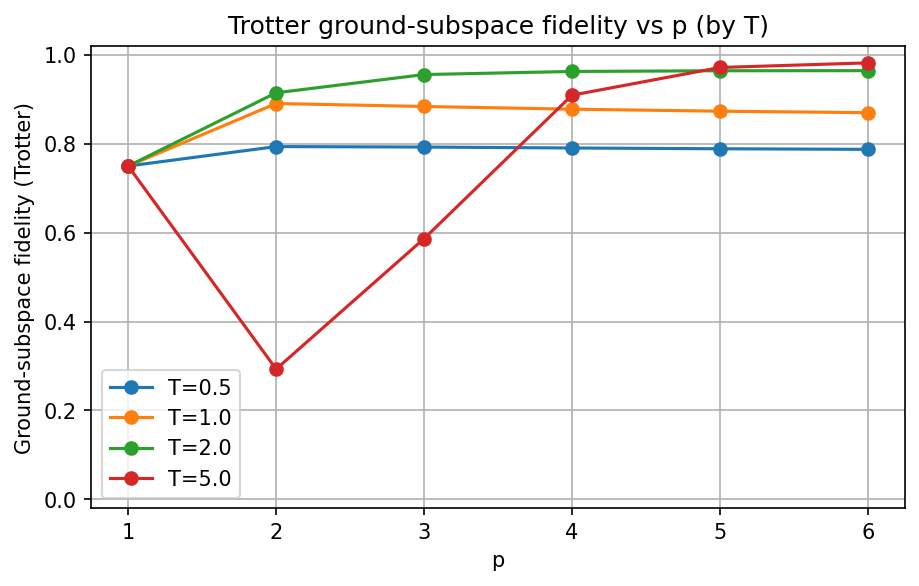

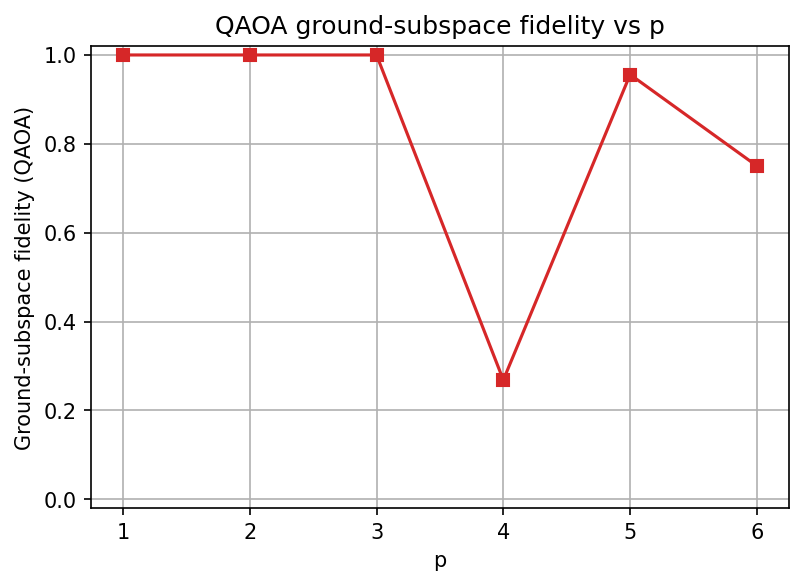

In [ ]:
# ===== Compute ground-subspace fidelity, save CSV, and plot summary =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.dpi':150})

# Ensure we have df_corr (corrected expectations computed earlier)
if 'df_corr' not in globals():
    raise RuntimeError("df_corr not found. Run the corrected recompute cell first.")

# basis states and classical costs (should exist; recreate if needed)
basis_states = ['{0:03b}'.format(i) for i in range(8)]
if 'cost_from_bitstring' in globals():
    costs_diag = np.array([cost_from_bitstring(bs) for bs in basis_states])
else:
    def cost_from_bitstring_local(bitstr):
        z = np.array([1 if b=='0' else -1 for b in bitstr], dtype=int)
        return 0.5 * ((1 - z[0]*z[1]) + (1 - z[1]*z[2]) + (1 - z[2]*z[0]))
    costs_diag = np.array([cost_from_bitstring_local(bs) for bs in basis_states])

Cmax = float(np.max(costs_diag))
optimal_indices = [i for i, v in enumerate(costs_diag) if np.isclose(v, Cmax)]
optimal_basis = [basis_states[i] for i in optimal_indices]
print("C_max =", Cmax, "optimal basis states:", optimal_basis)

# helper to compute prob mass on optimal basis for a statevector psi
def subspace_fidelity_from_state(psi, optimal_indices):
    probs = np.abs(psi)**2
    return float(np.sum([probs[i] for i in optimal_indices]))

rows = []
for idx, row in df_corr.iterrows():
    p = int(row['p']); T = float(row['T'])
    # recompute trotter state (cheap)
    U_t = trotter_adiabatic_evolution(H_M, H_P, p, T)
    psi_t = apply_unitary_to_plus(U_t)
    fid_t_sub = subspace_fidelity_from_state(psi_t, optimal_indices)
    cost_t = float(row['cost_trotter_corr'])  # already computed from classic diag

    # QAOA: reconstruct state from params (fall back logic same as before)
    if p in qaoa_params_by_p:
        gam, bet = qaoa_params_by_p[p]
    elif p in qaoa_params:
        gam, bet = qaoa_params[p]
    else:
        # tile fallback
        available = sorted(list(qaoa_params_by_p.keys()) if 'qaoa_params_by_p' in globals() else list(qaoa_params.keys()))
        if available:
            lastp = available[-1]
            g0, b0 = (qaoa_params_by_p.get(lastp) or qaoa_params.get(lastp))
            gam = np.tile(g0, int(np.ceil(p/len(g0))))[:p]
            bet = np.tile(b0, int(np.ceil(p/len(b0))))[:p]
        else:
            gam = np.zeros(p); bet = np.zeros(p)
    psi_q = qaoa_state_from_params(gam, bet)
    fid_q_sub = subspace_fidelity_from_state(psi_q, optimal_indices)
    cost_q = float(row['cost_qaoa_corr'])

    rows.append({'p':p, 'T':T,
                 'fidelity_trotter_subspace': fid_t_sub, 'cost_trotter': cost_t,
                 'fidelity_qaoa_subspace': fid_q_sub, 'cost_qaoa': cost_q,
                 'qaoa_params_source': (p in (qaoa_params_by_p.keys() if 'qaoa_params_by_p' in globals() else qaoa_params.keys()))})

df_sub = pd.DataFrame(rows)
outfn = "results/fidelity_cost_vs_p_subspace.csv"
df_sub.to_csv(outfn, index=False)
print("Saved subspace fidelity CSV to", outfn)
print("\nSummary table (first 12 rows):")
display(df_sub.round(6))

# Quick plots: trotter subspace fidelity (overlay T) and QAOA subspace fidelity vs p
plt.figure(figsize=(7,4))
for T in sorted(df_sub['T'].unique()):
    sub = df_sub[df_sub['T']==T]
    plt.plot(sub['p'], sub['fidelity_trotter_subspace'], marker='o', label=f"T={T}")
plt.xlabel("p")
plt.ylabel("Ground-subspace fidelity (Trotter)")
plt.title("Trotter ground-subspace fidelity vs p (by T)")
plt.xticks(sorted(df_sub['p'].unique()))
plt.ylim(-0.02,1.02)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
qd = df_sub.drop_duplicates(subset=['p']).sort_values('p')
plt.plot(qd['p'], qd['fidelity_qaoa_subspace'], marker='s', color='C3', label='QAOA subspace fidelity')
plt.xlabel("p")
plt.ylabel("Ground-subspace fidelity (QAOA)")
plt.title("QAOA ground-subspace fidelity vs p")
plt.xticks(sorted(df_sub['p'].unique()))
plt.ylim(-0.02,1.02)
plt.grid(True)
plt.show()


Reusing existing H_P and H_M from notebook.
Existing QAOA params available for p: [1, 2, 3]

Optimizing QAOA for p=4 ...
  Done p=4: ⟨C⟩_opt=1.999886, success=True, time=0.7s

Optimizing QAOA for p=5 ...
  Done p=5: ⟨C⟩_opt=1.999980, success=True, time=1.3s

Optimizing QAOA for p=6 ...
  Done p=6: ⟨C⟩_opt=1.999990, success=True, time=0.8s

Updated CSV written to results/qaoa_results.csv
p=1, T=0.5: trotter fid=0.750000, cost=1.500000 | qaoa fid=1.000000, cost=2.000000
p=2, T=0.5: trotter fid=0.793766, cost=1.587532 | qaoa fid=0.999996, cost=1.999992
p=3, T=0.5: trotter fid=0.792726, cost=1.585451 | qaoa fid=1.000000, cost=2.000000
p=4, T=0.5: trotter fid=0.790579, cost=1.581157 | qaoa fid=0.999944, cost=1.999887
p=5, T=0.5: trotter fid=0.788861, cost=1.577721 | qaoa fid=0.999995, cost=1.999991
p=6, T=0.5: trotter fid=0.787555, cost=1.575110 | qaoa fid=0.999995, cost=1.999990
p=1, T=1.0: trotter fid=0.750000, cost=1.500000 | qaoa fid=1.000000, cost=2.000000
p=2, T=1.0: trotter fid=0.890

/tmp/ipython-input-3888485809.py:160: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_updated = pd.concat([df_keep, df_manual[df_existing.columns]], ignore_index=True, sort=False)


p=4, T=2.0: trotter fid=0.962881, cost=1.925762 | qaoa fid=0.999944, cost=1.999887
p=5, T=2.0: trotter fid=0.964472, cost=1.928944 | qaoa fid=0.999995, cost=1.999991
p=6, T=2.0: trotter fid=0.964702, cost=1.929403 | qaoa fid=0.999995, cost=1.999990
p=1, T=5.0: trotter fid=0.750000, cost=1.500000 | qaoa fid=1.000000, cost=2.000000
p=2, T=5.0: trotter fid=0.292874, cost=0.585748 | qaoa fid=0.999996, cost=1.999992
p=3, T=5.0: trotter fid=0.586503, cost=1.173006 | qaoa fid=1.000000, cost=2.000000
p=4, T=5.0: trotter fid=0.909495, cost=1.818990 | qaoa fid=0.999944, cost=1.999887
p=5, T=5.0: trotter fid=0.971830, cost=1.943661 | qaoa fid=0.999995, cost=1.999991
p=6, T=5.0: trotter fid=0.982220, cost=1.964440 | qaoa fid=0.999995, cost=1.999990

Saved updated comparison CSV to results/fidelity_cost_vs_p_subspace.csv


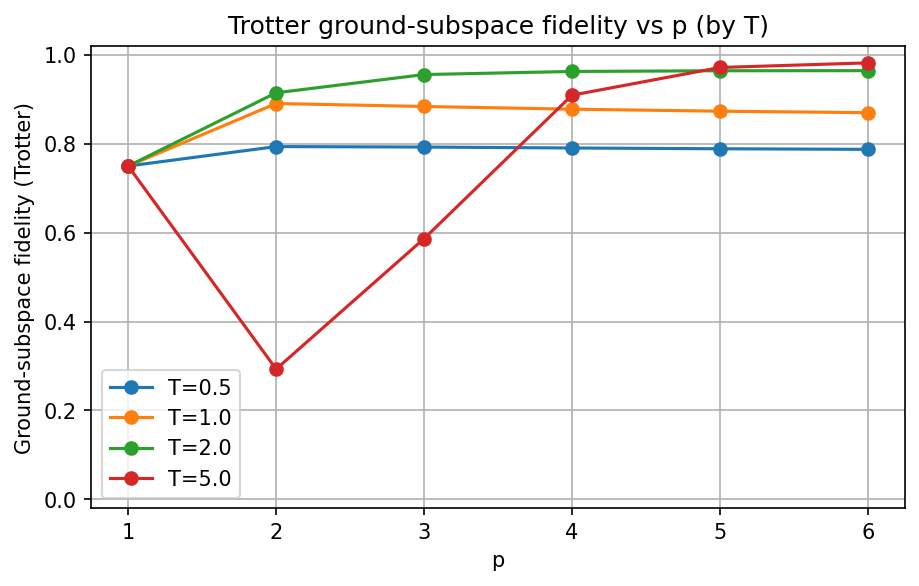

Saved results/fidelity_vs_p_trotter_subspace.png


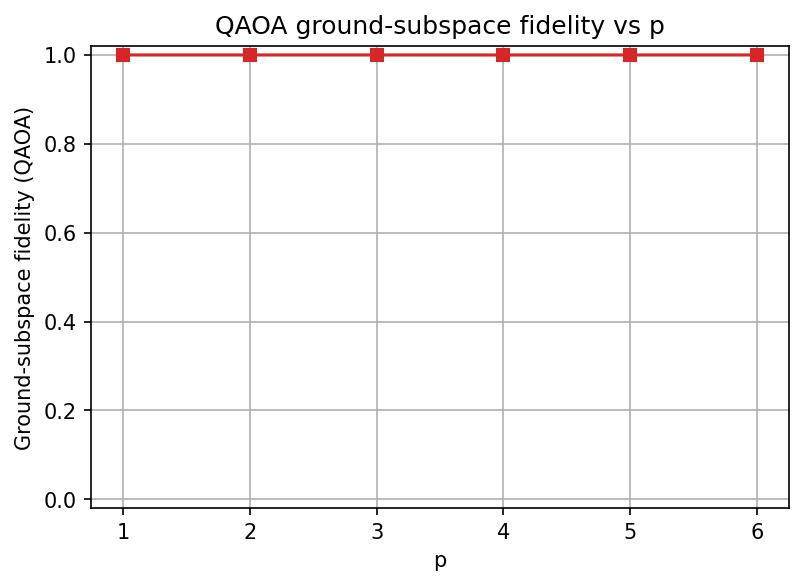

Saved results/fidelity_vs_p_qaoa_subspace.png

Re-optimization finished. New params added for p: [4, 5, 6]
You can inspect results/fidelity_cost_vs_p_subspace.csv and the updated plots in results/.


In [ ]:
# ===== Re-optimize QAOA for p = 4,5,6 and re-run comparison =====
# Paste this into your notebook and run it. It will:
#  - run optimizer for p in [4,5,6]
#  - update qaoa_params_by_p
#  - rewrite results/qaoa_results.csv rows for manual_qaoa
#  - recompute subspace fidelities & costs and save updated CSV/plots

import numpy as np, time, math, os, pandas as pd
from scipy.linalg import expm, eigh
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# --- settings (keep seeds & optimizer settings identical to earlier) ---
GLOBAL_SEED = 12345
np.random.seed(GLOBAL_SEED)
p_to_opt = [4,5,6]
maxiter = 400

# --- ensure H_P, H_M exist (recreate if missing) ---
I2 = np.array([[1,0],[0,1]], dtype=complex)
X = np.array([[0,1],[1,0]], dtype=complex)
Z = np.array([[1,0],[0,-1]], dtype=complex)

def kron_n(ops):
    out = ops[0]
    for op in ops[1:]:
        out = np.kron(out, op)
    return out

if 'H_P' not in globals() or 'H_M' not in globals():
    print("H_P or H_M not found in notebook; building them now.")
    I8 = np.eye(8, dtype=complex)
    ZZ_01 = kron_n([Z, Z, I2])
    ZZ_12 = kron_n([I2, Z, Z])
    ZZ_20 = kron_n([Z, I2, Z])
    H_P = 0.5 * (3 * I8 - (ZZ_01 + ZZ_12 + ZZ_20))
    XM0 = kron_n([X, I2, I2])
    XM1 = kron_n([I2, X, I2])
    XM2 = kron_n([I2, I2, X])
    H_M = XM0 + XM1 + XM2
    H = H_P.copy()
else:
    print("Reusing existing H_P and H_M from notebook.")

# basis states and classical cost (fallback if not present)
if 'basis_states' not in globals():
    basis_states = ['{0:03b}'.format(i) for i in range(8)]
if 'cost_from_bitstring' not in globals():
    def cost_from_bitstring_local(bitstr):
        z = np.array([1 if b=='0' else -1 for b in bitstr], dtype=int)
        return 0.5 * ((1 - z[0]*z[1]) + (1 - z[1]*z[2]) + (1 - z[2]*z[0]))
    cost_from_bitstring = cost_from_bitstring_local

# --- helper: build U_C and qaoa state (exact) ---
def build_UC(gamma):
    return expm(-1j * gamma * H_P)

def qaoa_statevector_from_params(gammas, betas):
    psi = (1/np.sqrt(2)) * np.array([1,1], dtype=complex)
    psi = np.kron(np.kron(psi, psi), psi)  # |+>^3
    p = len(gammas)
    for layer in range(p):
        Uc = build_UC(gammas[layer])
        psi = Uc.dot(psi)
        angle = 2 * betas[layer]
        Rx = np.array([[math.cos(angle/2), -1j*math.sin(angle/2)],
                       [-1j*math.sin(angle/2), math.cos(angle/2)]], dtype=complex)
        UX = kron_n([Rx, Rx, Rx])
        psi = UX.dot(psi)
    psi /= np.linalg.norm(psi)
    return psi

def expectation_from_statevector(psi):
    return float(np.real(np.vdot(psi.conj(), H_P.dot(psi))))

# --- optimizer (same logic as earlier find_opt_params_for_p) ---
def find_opt_params_for_p(p, initial_point=None, maxiter_local=maxiter):
    if initial_point is None:
        rng = np.random.default_rng(GLOBAL_SEED + p)
        init_g = rng.uniform(0, math.pi, size=p)
        init_b = rng.uniform(0, math.pi/2, size=p)
        x0 = np.concatenate([init_g, init_b])
    else:
        x0 = np.array(initial_point)

    def exp_obj(x):
        gammas = x[:p]
        betas = x[p:]
        psi = qaoa_statevector_from_params(gammas, betas)
        return expectation_from_statevector(psi)

    def negobj(x):
        return -exp_obj(x)

    res = minimize(negobj, x0, method='COBYLA', options={'maxiter': maxiter_local, 'tol': 1e-3, 'disp': False})
    gammas = res.x[:p]
    betas = res.x[p:]
    exp_val = -res.fun
    return {'p': p, 'gammas': np.array(gammas), 'betas': np.array(betas),
            'exp_val': float(exp_val), 'success': res.success, 'message': res.message}

# --- Load existing qaoa params dict (prefer qaoa_params_by_p from robust parser) ---
if 'qaoa_params_by_p' in globals() and qaoa_params_by_p:
    qparams = qaoa_params_by_p
elif 'qaoa_params' in globals() and qaoa_params:
    qparams = qaoa_params
elif 'results_B' in globals():
    qparams = {ent['p']: (np.array(ent['gammas']), np.array(ent['betas'])) for ent in results_B}
else:
    qparams = {}
print("Existing QAOA params available for p:", sorted(qparams.keys()))

# --- Run optimization for requested p values ---
new_results = []
for p in p_to_opt:
    print(f"\nOptimizing QAOA for p={p} ...")
    t0 = time.time()
    res = find_opt_params_for_p(p, maxiter_local=maxiter)
    dt = time.time() - t0
    print(f"  Done p={p}: ⟨C⟩_opt={res['exp_val']:.6f}, success={res['success']}, time={dt:.1f}s")
    # store into qparams
    qparams[p] = (res['gammas'], res['betas'])
    new_results.append(res)

# --- Update in-memory dict for rest of notebook ---
qaoa_params_by_p = qparams  # replace or create

# --- Update results/qaoa_results.csv:
csv_fn = "results/qaoa_results.csv"
df_existing = None
if os.path.exists(csv_fn):
    try:
        df_existing = pd.read_csv(csv_fn)
    except Exception:
        df_existing = None

# Build rows for manual_qaoa entries from qparams (only p entries we have)
rows_out = []
for pval, (garr, barr) in sorted(qparams.items()):
    rows_out.append({
        'method': 'manual_qaoa',
        'p': int(pval),
        'params': f"gammas={np.array2string(np.round(garr,6), separator=',')}, betas={np.array2string(np.round(barr,6), separator=',')}",
        'opt_info': ''  # placeholder, older CSVs may have different columns
    })

# If existing CSV present, keep other methods but remove manual_qaoa rows for these p_to_opt
if df_existing is not None:
    # remove manual_qaoa rows for p in p_to_opt
    df_keep = df_existing[~((df_existing['method']=='manual_qaoa') & (df_existing['p'].isin(p_to_opt)))]
    # create df_new_manual from rows_out
    # match columns: reuse existing columns where possible
    try:
        # build DataFrame with same columns as df_existing (fill missing with NaN)
        df_manual = pd.DataFrame(rows_out)
        for c in df_existing.columns:
            if c not in df_manual.columns:
                df_manual[c] = None
        # concat
        df_updated = pd.concat([df_keep, df_manual[df_existing.columns]], ignore_index=True, sort=False)
    except Exception:
        df_updated = pd.DataFrame(rows_out)
else:
    # just write manual rows
    df_updated = pd.DataFrame(rows_out)

# Save updated CSV
df_updated.to_csv(csv_fn, index=False)
print("\nUpdated CSV written to", csv_fn)

# --- Recompute comparison table (trotter vs qaoa) using updated params ---
p_values = [1,2,3,4,5,6]
T_values = [0.5, 1.0, 2.0, 5.0]

# prepare classical diag costs and optimal indices
costs_diag = np.array([cost_from_bitstring(bs) for bs in basis_states])
Cmax = float(np.max(costs_diag))
optimal_indices = [i for i,v in enumerate(costs_diag) if np.isclose(v, Cmax)]

def subspace_fidelity(psi):
    probs = np.abs(psi)**2
    return float(np.sum(probs[optimal_indices]))

rows = []
timings = []
for T in T_values:
    for p in p_values:
        t0 = time.time()
        # trotter
        U_t = trotter_adiabatic_evolution(H_M, H_P, p, T)
        psi_t = (1/np.sqrt(2)) * np.array([1,1], dtype=complex)
        psi_t = np.kron(np.kron(psi_t, psi_t), psi_t)
        psi_t = U_t.dot(psi_t)
        psi_t /= np.linalg.norm(psi_t)
        fid_t = subspace_fidelity(psi_t)
        cost_t = float(np.sum(np.abs(psi_t)**2 * costs_diag))

        # qaoa (use qparams; if p not present tile last known)
        if p in qparams:
            gam, bet = qparams[p]
        else:
            # tile from highest available
            if qparams:
                lastp = max(qparams.keys())
                g0, b0 = qparams[lastp]
                gam = np.tile(g0, int(np.ceil(p/len(g0))))[:p]
                bet = np.tile(b0, int(np.ceil(p/len(b0))))[:p]
            else:
                gam = np.zeros(p); bet = np.zeros(p)
        psi_q = qaoa_statevector_from_params(gam, bet)
        fid_q = subspace_fidelity(psi_q)
        cost_q = float(np.sum(np.abs(psi_q)**2 * costs_diag))

        rows.append({'p':p, 'T':T, 'fidelity_trotter_subspace': fid_t, 'cost_trotter': cost_t,
                     'fidelity_qaoa_subspace': fid_q, 'cost_qaoa': cost_q, 'qaoa_params_source': p in qparams})
        timings.append({'p':p, 'T':T, 'wall_time_s': time.time()-t0})
        print(f"p={p}, T={T}: trotter fid={fid_t:.6f}, cost={cost_t:.6f} | qaoa fid={fid_q:.6f}, cost={cost_q:.6f}")

# Save updated comparison CSVs
df_new = pd.DataFrame(rows)
df_new.to_csv("results/fidelity_cost_vs_p_subspace.csv", index=False)
df_new.to_csv("results/fidelity_cost_vs_p_corrected.csv", index=False)
pd.DataFrame(timings).to_csv("results/timing_table.csv", index=False)
print("\nSaved updated comparison CSV to results/fidelity_cost_vs_p_subspace.csv")

# --- regenerate plots (overwrite previous) ---
plt.rcParams.update({'figure.dpi':150})
df_all = df_new.copy()

# fidelity trotter overlay
plt.figure(figsize=(7,4))
for T in sorted(df_all['T'].unique()):
    sub = df_all[df_all['T']==T]
    plt.plot(sub['p'], sub['fidelity_trotter_subspace'], marker='o', label=f"T={T}")
plt.xlabel("p"); plt.ylabel("Ground-subspace fidelity (Trotter)")
plt.title("Trotter ground-subspace fidelity vs p (by T)")
plt.xticks(p_values); plt.ylim(-0.02,1.02); plt.grid(True); plt.legend()
fn1 = "results/fidelity_vs_p_trotter_subspace.png"
plt.savefig(fn1, dpi=200); plt.show()
print("Saved", fn1)

# qaoa fidelity vs p
plt.figure(figsize=(6,4))
qdf = df_all.drop_duplicates(subset=['p']).sort_values('p')
plt.plot(qdf['p'], qdf['fidelity_qaoa_subspace'], marker='s', color='C3')
plt.xlabel("p"); plt.ylabel("Ground-subspace fidelity (QAOA)"); plt.title("QAOA ground-subspace fidelity vs p")
plt.xticks(p_values); plt.ylim(-0.02,1.02); plt.grid(True)
fn2 = "results/fidelity_vs_p_qaoa_subspace.png"
plt.savefig(fn2, dpi=200); plt.show()
print("Saved", fn2)

print("\nRe-optimization finished. New params added for p:", p_to_opt)
print("You can inspect results/fidelity_cost_vs_p_subspace.csv and the updated plots in results/.")


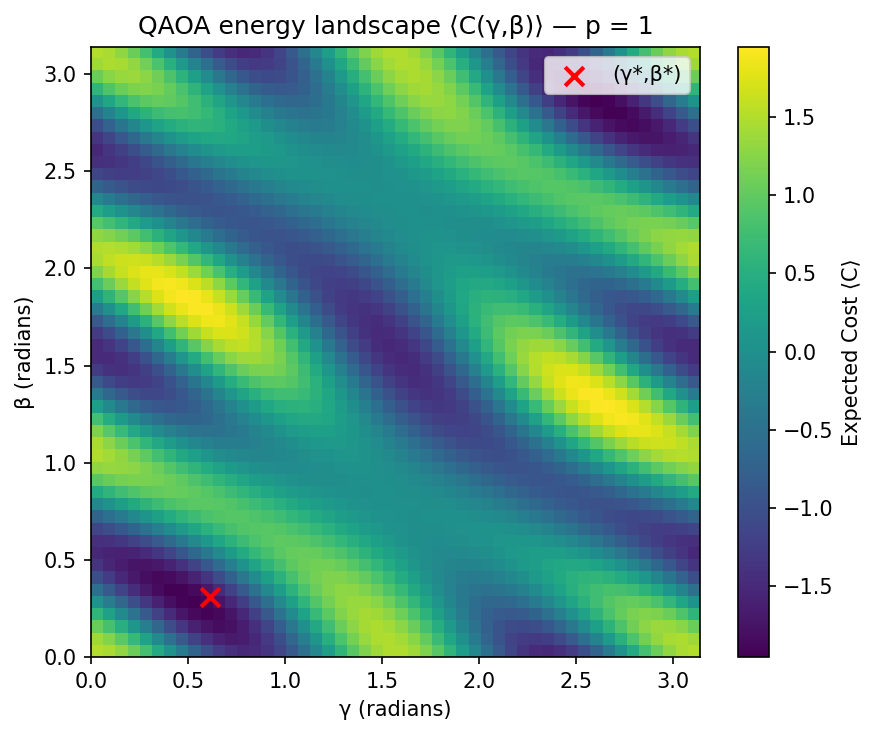

Saved results/landscape_heatmap_p1.png


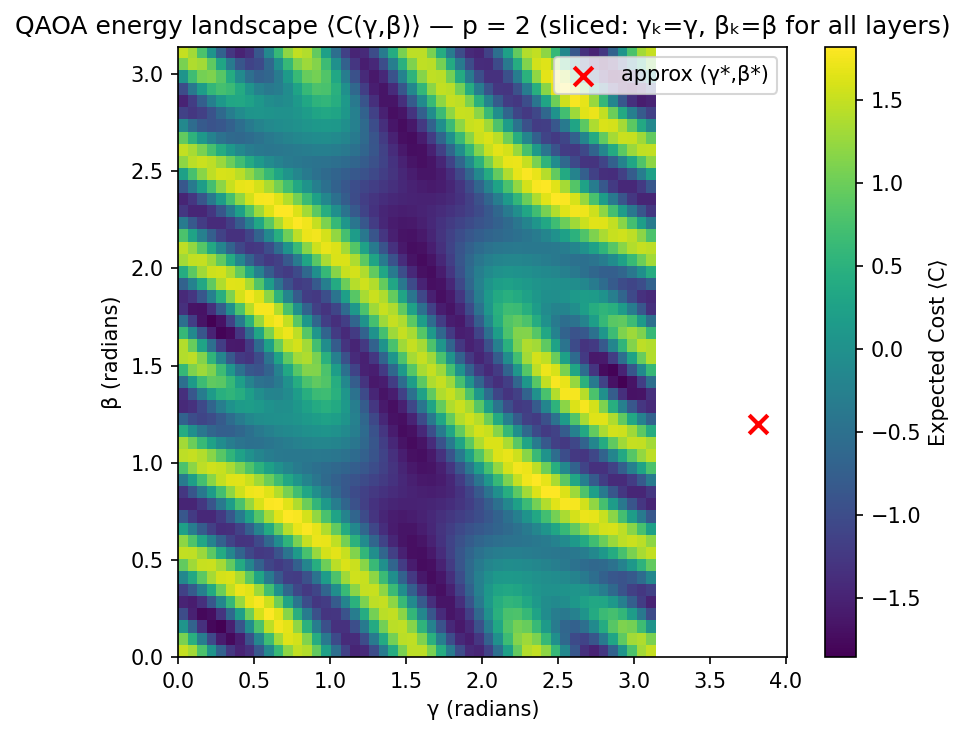

Saved results/landscape_heatmap_p2.png
Landscape heatmap saved ✅


In [ ]:
# ===== Landscape heatmap for QAOA parameter space (p=1 and p=2) =====
# Computes ⟨C(γ,β)⟩ on a 50x50 grid for gamma,beta ∈ [0, π], saves
# results/landscape_heatmap_p1.png and results/landscape_heatmap_p2.png.
# Marks optimized (γ*,β*) from earlier optimization if available.

import os, math, numpy as np, matplotlib.pyplot as plt
from scipy.linalg import expm, eigh
plt.rcParams.update({'figure.dpi':150})
os.makedirs("results", exist_ok=True)

# Rebuild H_P, H_M if missing (same conventions: qubits 0,1,2)
if 'H_P' not in globals() or 'H_M' not in globals():
    I2 = np.array([[1,0],[0,1]], dtype=complex)
    X = np.array([[0,1],[1,0]], dtype=complex)
    Z = np.array([[1,0],[0,-1]], dtype=complex)
    def kron_n(ops):
        out = ops[0]
        for op in ops[1:]:
            out = np.kron(out, op)
        return out
    ZZ_01 = kron_n([Z, Z, I2])
    ZZ_12 = kron_n([I2, Z, Z])
    ZZ_20 = kron_n([Z, I2, Z])
    I8 = np.eye(8, dtype=complex)
    H_P = 0.5 * (3 * I8 - (ZZ_01 + ZZ_12 + ZZ_20))
    XM0 = kron_n([X, I2, I2])
    XM1 = kron_n([I2, X, I2])
    XM2 = kron_n([I2, I2, X])
    H_M = XM0 + XM1 + XM2
    print("Rebuilt H_P and H_M.")

# Define a robust QAOA state builder consistent with earlier notebook (Rx uses angle 2*beta)
def qaoa_state_from_gb(gammas, betas):
    # expects arrays of length p
    p = len(gammas)
    plus = (1/np.sqrt(2)) * np.array([1,1], dtype=complex)
    psi = np.kron(np.kron(plus, plus), plus)
    for layer in range(p):
        Uc = expm(-1j * gammas[layer] * H_P)
        psi = Uc.dot(psi)
        angle = 2 * betas[layer]
        Rx = np.array([[math.cos(angle/2), -1j*math.sin(angle/2)],
                       [-1j*math.sin(angle/2), math.cos(angle/2)]], dtype=complex)
        UX = np.kron(np.kron(Rx, Rx), Rx)
        psi = UX.dot(psi)
    psi /= np.linalg.norm(psi)
    return psi

def expectation_from_state(psi, H):
    return float(np.real(np.vdot(psi.conj(), H.dot(psi))))

# grid settings
NG = 50
gam_vals = np.linspace(0, math.pi, NG)
bet_vals = np.linspace(0, math.pi, NG)
GG, BB = np.meshgrid(gam_vals, bet_vals, indexing='xy')

# helper to try load optimized point for p=1 and p=2
opt_points = {}  # p -> (gamma_array, beta_array)
# check common dicts: qaoa_params_by_p then qaoa_params
if 'qaoa_params_by_p' in globals() and qaoa_params_by_p:
    for k,v in qaoa_params_by_p.items():
        opt_points[k] = (np.array(v[0], dtype=float), np.array(v[1], dtype=float))
elif 'qaoa_params' in globals() and qaoa_params:
    for k,v in qaoa_params.items():
        opt_points[k] = (np.array(v[0], dtype=float), np.array(v[1], dtype=float))
elif os.path.exists("results/qaoa_results.csv"):
    try:
        dfq = pd.read_csv("results/qaoa_results.csv")
        for _, r in dfq.iterrows():
            if r['method'] == 'manual_qaoa':
                pval = int(r['p'])
                # parse params robustly similar to earlier code
                s = str(r['params'])
                # try to extract bracketed blocks
                import re, ast
                blocks = re.findall(r'(\[[^\]]*\])', s)
                if len(blocks) >= 2:
                    gam = np.array(ast.literal_eval(blocks[0]), dtype=float)
                    bet = np.array(ast.literal_eval(blocks[1]), dtype=float)
                    opt_points[pval] = (gam, bet)
    except Exception:
        pass

# Function to compute landscape for a given p (returns matrix of expectations)
def compute_landscape(p):
    Z = np.zeros((NG, NG))
    for i in range(NG):
        for j in range(NG):
            g = GG[i,j]
            b = BB[i,j]
            gam_arr = np.array([g]*p) if p>1 else np.array([g])
            bet_arr = np.array([b]*p) if p>1 else np.array([b])
            psi = qaoa_state_from_gb(gam_arr, bet_arr)
            Z[i,j] = expectation_from_state(psi, H_P)
    return Z

# --- p = 1 landscape ---
Z1 = compute_landscape(1)
plt.figure(figsize=(6,5))
im = plt.imshow(Z1, origin='lower', extent=[0, math.pi, 0, math.pi], aspect='auto')
plt.colorbar(im, label="Expected Cost ⟨C⟩")
plt.xlabel("γ (radians)")
plt.ylabel("β (radians)")
plt.title("QAOA energy landscape ⟨C(γ,β)⟩ — p = 1")
# mark optimized point if available
if 1 in opt_points:
    gopt = float(opt_points[1][0][0]); bopt = float(opt_points[1][1][0])
    plt.scatter([gopt], [bopt], color='red', marker='x', s=80, linewidths=2, label="(γ*,β*)")
    plt.legend()
fn1 = "results/landscape_heatmap_p1.png"
plt.tight_layout(); plt.savefig(fn1, dpi=200); plt.show()
print("Saved", fn1)

# --- optional p = 2 landscape (compute but mark opt if available) ---
Z2 = compute_landscape(2)
plt.figure(figsize=(6,5))
im2 = plt.imshow(Z2, origin='lower', extent=[0, math.pi, 0, math.pi], aspect='auto')
plt.colorbar(im2, label="Expected Cost ⟨C⟩")
plt.xlabel("γ (radians)")
plt.ylabel("β (radians)")
plt.title("QAOA energy landscape ⟨C(γ,β)⟩ — p = 2 (sliced: γₖ=γ, βₖ=β for all layers)")
if 2 in opt_points:
    # if we have vector params, try to plot first-layer gammas/betas (or average)
    gvec, bvec = opt_points[2]
    # mark average or first component
    gmark = float(gvec[0]) if len(gvec)>0 else float(np.mean(gvec))
    bmark = float(bvec[0]) if len(bvec)>0 else float(np.mean(bvec))
    plt.scatter([gmark], [bmark], color='red', marker='x', s=80, linewidths=2, label="approx (γ*,β*)")
    plt.legend()
fn2 = "results/landscape_heatmap_p2.png"
plt.tight_layout(); plt.savefig(fn2, dpi=200); plt.show()
print("Saved", fn2)

print("Landscape heatmap saved ✅")


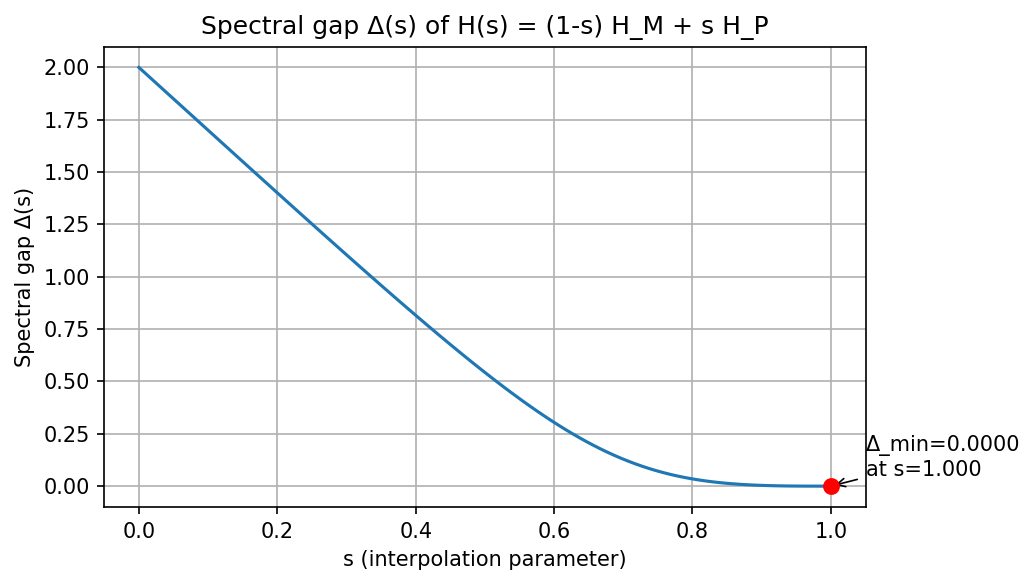

Spectral gap plot saved to results/spectral_gap_vs_s.png
Spectral gap saved ✅


In [ ]:
# ===== Spectral gap Δ(s) for H(s) = (1-s) H_M + s H_P (100 points) =====
import numpy as np, matplotlib.pyplot as plt, os
from scipy.linalg import eigh
plt.rcParams.update({'figure.dpi':150})
os.makedirs("results", exist_ok=True)

# ensure H_P,H_M exist (rebuild if missing)
if 'H_P' not in globals() or 'H_M' not in globals():
    I2 = np.array([[1,0],[0,1]], dtype=complex)
    X = np.array([[0,1],[1,0]], dtype=complex)
    Z = np.array([[1,0],[0,-1]], dtype=complex)
    def kron_n(ops):
        out = ops[0]
        for op in ops[1:]:
            out = np.kron(out, op)
        return out
    ZZ_01 = kron_n([Z,Z,I2]); ZZ_12 = kron_n([I2,Z,Z]); ZZ_20 = kron_n([Z,I2,Z])
    I8 = np.eye(8, dtype=complex)
    H_P = 0.5 * (3*I8 - (ZZ_01 + ZZ_12 + ZZ_20))
    XM0 = kron_n([X,I2,I2]); XM1 = kron_n([I2,X,I2]); XM2 = kron_n([I2,I2,X])
    H_M = XM0 + XM1 + XM2
    print("Rebuilt H_P and H_M.")

s_vals = np.linspace(0.0, 1.0, 100)
gaps = np.zeros_like(s_vals)
E0 = np.zeros_like(s_vals)
E1 = np.zeros_like(s_vals)

for i, s in enumerate(s_vals):
    Hs = (1.0 - s) * H_M + s * H_P
    evs = np.linalg.eigvalsh(Hs)
    E0[i] = evs[0]
    E1[i] = evs[1]
    gaps[i] = E1[i] - E0[i]

imin = int(np.argmin(gaps))
s_star = float(s_vals[imin])
delta_min = float(gaps[imin])

plt.figure(figsize=(7,4))
plt.plot(s_vals, gaps, lw=1.5)
plt.scatter([s_star], [delta_min], color='red', s=50, zorder=5)
plt.annotate(f"Δ_min={delta_min:.4f}\nat s={s_star:.3f}", xy=(s_star, delta_min), xytext=(s_star+0.05, delta_min+0.05),
             arrowprops=dict(arrowstyle="->", lw=0.8))
plt.xlabel("s (interpolation parameter)")
plt.ylabel("Spectral gap Δ(s)")
plt.title("Spectral gap Δ(s) of H(s) = (1-s) H_M + s H_P")
plt.grid(True)
plt.tight_layout()
fn_gap = "results/spectral_gap_vs_s.png"
plt.savefig(fn_gap, dpi=200)
plt.show()

print(f"Spectral gap plot saved to {fn_gap}")
print("Spectral gap saved ✅")


## Warm-start (Parameter Transfer) Convergence Test — 4-node cycle MaxCut

We test whether transferring optimized QAOA angles from the 3-node problem (warm-start) speeds up classical optimizer convergence on a 4-node cycle MaxCut instance compared to a standard random initialization.  
Warm-starts can help because QAOA parameters often lie in regular basins across similar graphs; transferring them can reduce optimization iterations and avoid poor local minima.

This section runs two optimizer experiments (Random start vs Warm-start), logs cost ⟨C⟩ per function-evaluation, and compares convergence curves and final metrics.


In [ ]:
# ===== Cell 1: imports, settings, and helper functions =====
import os, time, math, re, ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import expm, eigh
from scipy.optimize import minimize
plt.rcParams.update({'figure.dpi':150})
os.makedirs("results", exist_ok=True)

# reproducibility
GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)

# ---- helper: Kronecker product for n=4 qubits ----
def kron_n(ops):
    out = ops[0]
    for op in ops[1:]:
        out = np.kron(out, op)
    return out

# Pauli matrices
I2 = np.array([[1,0],[0,1]], dtype=complex)
X = np.array([[0,1],[1,0]], dtype=complex)
Z = np.array([[1,0],[0,-1]], dtype=complex)

# ---- Build 4-node cycle MaxCut H_P (4 qubits) ----
# edges: (0,1), (1,2), (2,3), (3,0)
dim = 2**4
I16 = np.eye(dim, dtype=complex)

def embed_pauli(op, qubits, n=4):
    """Return n-qubit operator with single-qubit op on positions in list 'qubits' (for 2-qubit ZZ build we use pairs)"""
    # qubits is a list of length n with either op or I2
    return kron_n(qubits)

# Build pairwise ZZ terms
def ZZ_pair(i,j):
    ops = [I2]*4
    ops[i] = Z; ops[j] = Z
    return kron_n(ops)

ZZ_01 = ZZ_pair(0,1)
ZZ_12 = ZZ_pair(1,2)
ZZ_23 = ZZ_pair(2,3)
ZZ_30 = ZZ_pair(3,0)

# Problem Hamiltonian for MaxCut on cycle (4 edges)
# C(z) = 1/2 * sum_{edges} (1 - Z_i Z_j)
H_P = 0.5 * (4 * I16 - (ZZ_01 + ZZ_12 + ZZ_23 + ZZ_30))

# Mixer H_M = sum X_i
XM0 = kron_n([X, I2, I2, I2])
XM1 = kron_n([I2, X, I2, I2])
XM2 = kron_n([I2, I2, X, I2])
XM3 = kron_n([I2, I2, I2, X])
H_M = XM0 + XM1 + XM2 + XM3

print("Built H_P and H_M for 4-node cycle. dim =", H_P.shape)


Built H_P and H_M for 4-node cycle. dim = (16, 16)


In [ ]:
# ===== Cell 2: QAOA statebuilder and cost helpers =====

def plus_state(n=4):
    plus = (1/np.sqrt(2)) * np.array([1,1], dtype=complex)
    psi = plus
    for _ in range(n-1):
        psi = np.kron(psi, plus)
    return psi

def qaoa_state_from_params(gammas, betas):
    """Manual exact QAOA state via expm for H_P and single-qubit Rx for H_M."""
    p = len(gammas)
    psi = plus_state(4)
    for layer in range(p):
        Uc = expm(-1j * gammas[layer] * H_P)
        psi = Uc.dot(psi)
        angle = 2 * betas[layer]
        Rx = np.array([[math.cos(angle/2), -1j*math.sin(angle/2)],
                       [-1j*math.sin(angle/2), math.cos(angle/2)]], dtype=complex)
        UX = kron_n([Rx, Rx, Rx, Rx])
        psi = UX.dot(psi)
    psi /= np.linalg.norm(psi)
    return psi

def expectation_from_state(psi, H):
    return float(np.real(np.vdot(psi.conj(), H.dot(psi))))

# cost function from bitstring (classical)
basis_states_4 = ['{0:04b}'.format(i) for i in range(16)]
def cost_from_bitstring_4(bitstr):
    z = np.array([1 if b=='0' else -1 for b in bitstr], dtype=int)
    # edges (0,1),(1,2),(2,3),(3,0)
    return 0.5 * ((1 - z[0]*z[1]) + (1 - z[1]*z[2]) + (1 - z[2]*z[3]) + (1 - z[3]*z[0]))

diag_costs_4 = np.array([cost_from_bitstring_4(bs) for bs in basis_states_4])
Cmax_4 = diag_costs_4.max()
optimal_indices_4 = np.where(np.isclose(diag_costs_4, Cmax_4))[0]

def subspace_fidelity_from_state(psi, opt_indices=optimal_indices_4):
    probs = np.abs(psi)**2
    return float(np.sum(probs[opt_indices]))


In [ ]:
# ===== Robust replacement for Cell 3: load 3-node QAOA params robustly =====
import re, ast, numpy as np, pandas as pd, os

warm_source = None
csv_src = "results/qaoa_results.csv"
print("Looking for", csv_src)

def normalize_param_string_for_warm(s):
    """
    Robustly extract two numeric lists from a string.
    Returns (gam_array, bet_array) as numpy arrays.
    """
    if not isinstance(s, str):
        raise ValueError("params field not a string")

    # 1) Try to find explicit 'gammas=..., betas=...' pattern
    m = re.search(r'gammas\s*=\s*([^\n,]+?)\s*,\s*betas\s*=\s*(.+)$', s)
    if m:
        graw = m.group(1).strip()
        braw = m.group(2).strip()
    else:
        # 2) find first two bracketed blocks like [ ... ] or ( ... )
        blocks = re.findall(r'(\[[^\]]*\]|\([^\)]*\))', s)
        if len(blocks) >= 2:
            graw, braw = blocks[0], blocks[1]
        else:
            # 3) try to extract anything that looks like numbers groups separated by non-number separators
            # split by 'betas' word if present
            if 'betas' in s:
                parts = s.split('betas',1)
                graw = parts[0]
                braw = parts[1]
            else:
                # last resort: take any sequence of floats and split in half
                num_re = r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?'
                nums = re.findall(num_re, s)
                if len(nums) >= 2:
                    half = len(nums)//2
                    graw = '[' + ' '.join(nums[:half]) + ']'
                    braw = '[' + ' '.join(nums[half:]) + ']'
                else:
                    raise ValueError("Could not identify gamma/beta blocks in string.")

    # Clean a block into a proper Python list string: replace 'array(' or 'np.array(' and spaces -> commas if needed
    def clean_block(x):
        x = x.strip()
        # remove wrapper names like 'array(' or 'np.array(' or 'array '
        x = re.sub(r'^(?:array|np\.array)\s*\(', '[', x)
        # replace parentheses with brackets
        if x.startswith('(') and x.endswith(')'):
            x = '[' + x[1:-1] + ']'
        # ensure starts/ends with brackets
        if not x.startswith('['):
            x = '[' + x
        if not x.endswith(']'):
            x = x + ']'
        inner = x[1:-1].strip()
        # If commas present, assume comma-separated; else replace whitespace with commas
        if ',' in inner:
            norm_inner = inner
        else:
            # replace runs of whitespace with commas
            norm_inner = re.sub(r'\s+', ',', inner)
        norm = '[' + norm_inner.strip() + ']'
        return norm

    gclean = clean_block(graw)
    bclean = clean_block(braw)

    # Try ast.literal_eval first
    try:
        gam_list = ast.literal_eval(gclean)
        bet_list = ast.literal_eval(bclean)
    except Exception:
        # fallback: extract numbers via regex
        num_re = r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?'
        gnums = re.findall(num_re, gclean)
        bnums = re.findall(num_re, bclean)
        if not gnums or not bnums:
            raise ValueError(f"Failed to parse numbers from cleaned blocks. gclean={gclean}, bclean={bclean}")
        gam_list = [float(x) for x in gnums]
        bet_list = [float(x) for x in bnums]

    return np.array(gam_list, dtype=float), np.array(bet_list, dtype=float)


if os.path.exists(csv_src):
    dfq = pd.read_csv(csv_src)
    print("CSV loaded. Showing raw params column for inspection:")
    display(dfq[['p','method','params']])
    parsed = {}
    parse_failures = []
    for _, row in dfq.iterrows():
        try:
            if str(row.get('method','')).strip() != 'manual_qaoa':
                continue
            pval = int(row['p'])
            s = str(row['params'])
            gam, bet = normalize_param_string_for_warm(s)
            parsed[pval] = (gam, bet)
        except Exception as e:
            parse_failures.append((int(row.get('p',-1)), str(row.get('params','')), str(e)))

    if parsed:
        warm_source = parsed
        print("Parsed warm_source for p values:", sorted(warm_source.keys()))
        # print examples
        for k in sorted(warm_source.keys()):
            g,b = warm_source[k]
            print(f" p={k}: gammas={np.round(g,6)}, betas={np.round(b,6)}")
    if parse_failures:
        print("\nRows that failed parsing (p, raw_params, error):")
        for fail in parse_failures:
            print(fail)
else:
    print("No CSV found at", csv_src, " — warm_source remains None.")


Looking for results/qaoa_results.csv
CSV loaded. Showing raw params column for inspection:


,p,method,params
0,1,manual_qaoa,"gammas=[0.615546], betas=[0.307675]"
1,2,manual_qaoa,"gammas=[3.817699 2.855613], betas=[1.201251 0...."
2,3,manual_qaoa,"gammas=[0.48815 2.440068 1.493731], betas=[0...."
3,1,manual_qaoa,"gammas=[0.615546], betas=[0.307675]"
4,2,manual_qaoa,"gammas=[3.817699,2.855613], betas=[1.201251,0...."
5,3,manual_qaoa,"gammas=[0.48815 ,2.440068,1.493731], betas=[0...."
6,4,manual_qaoa,"gammas=[0.554499,0.270043,2.011783,1.735781], ..."
7,5,manual_qaoa,"gammas=[3.932054,2.582392,1.631619,2.539933,0...."
8,6,manual_qaoa,"gammas=[1.597407,2.842791,1.776563,0.863852,1...."


Parsed warm_source for p values: [1, 2, 3, 4, 5, 6]
 p=1: gammas=[0.615546], betas=[0.307675]
 p=2: gammas=[3.817699 2.855613], betas=[1.201251 0.802896]
 p=3: gammas=[0.48815  2.440068 1.493731], betas=[0.86379  0.982814 1.155969]
 p=4: gammas=[0.554499 0.270043 2.011783 1.735781], betas=[-0.046596  0.907968  0.338184  0.719467]
 p=5: gammas=[3.932054 2.582392 1.631619 2.539933 0.699626], betas=[1.417631 1.212473 1.036263 0.768763 1.327336]
 p=6: gammas=[1.597407 2.842791 1.776563 0.863852 1.151374 2.028708], betas=[0.28424  0.258812 0.570019 0.857037 1.383583 0.654992]


In [ ]:
# ===== Cell 4: prepare initial parameters for p=2 (random and warm-start) =====
p = 2  # editable: QAOA depth for the 4-node experiment

# Random start (seeded)
rng = np.random.default_rng(GLOBAL_SEED)
# gamma in [0, pi], beta in [0, pi/2] (consistent with earlier)
init_gamma_random = rng.uniform(0, math.pi, size=p)
init_beta_random = rng.uniform(0, math.pi/2, size=p)
x0_random = np.concatenate([init_gamma_random, init_beta_random])

# Warm-start mapping strategy:
# If we have a warm_source for some p_s (from 3-node), try:
# - If p_s == p: use directly (trim/exact).
# - If p_s < p: tile its layers to reach length p.
# - If p_s > p: take first p layers.
# - If multiple p_s present, prefer exact match, else prefer largest p_s <= p, else largest available.
x0_warm = None
warm_used_source = None
if warm_source:
    # prefer exact p
    if p in warm_source:
        g0, b0 = warm_source[p]
        x0_warm = np.concatenate([g0[:p], b0[:p]])
        warm_used_source = f"p={p} exact"
    else:
        # find largest p_s <= p
        p_avail = sorted(warm_source.keys())
        lesser = [q for q in p_avail if q <= p]
        if lesser:
            q = lesser[-1]
            gq, bq = warm_source[q]
            # tile to length p
            gam = np.tile(gq, int(np.ceil(p/len(gq))))[:p]
            bet = np.tile(bq, int(np.ceil(p/len(bq))))[:p]
            x0_warm = np.concatenate([gam, bet])
            warm_used_source = f"tiled from p={q}"
        else:
            # use largest available and trim
            q = p_avail[-1]
            gq, bq = warm_source[q]
            gam = gq[:p]
            bet = bq[:p]
            x0_warm = np.concatenate([gam, bet])
            warm_used_source = f"trimmed from p={q}"
else:
    # fallback deterministic warm guess
    print("Fallback: no warm-source found. Using deterministic warm-start [0.5]* for reproducibility.")
    gam = np.array([0.5]*p)
    bet = np.array([0.5]*p)
    x0_warm = np.concatenate([gam, bet])
    warm_used_source = "fallback_constant"

print("Random init x0_random:", np.round(x0_random,4))
print("Warm init x0_warm:", np.round(x0_warm,4), " (", warm_used_source, ")")


Random init x0_random: [2.4315 1.3788 1.3487 1.0954]
Warm init x0_warm: [3.8177 2.8556 1.2013 0.8029]  ( p=2 exact )


In [ ]:
# ===== Replacement for Cell 5 + Cell 6: logged objective callable + run_minimize =====
import time
from scipy.optimize import minimize

# robust logged objective factory: returns a callable with attributes .log and .n_calls
def make_logged_objective_callable(H, p):
    """
    Returns: objective(x) callable that returns -⟨C⟩ (for minimizer).
    Attached attributes:
      - objective.log : list of (eval_idx, cost)
      - objective.n_calls : integer count (kept in a mutable list for closure safety)
    """
    # use mutable containers so closures can update them
    log = []
    counter = {'n': 0}

    def objective(x):
        counter['n'] += 1
        gam = np.array(x[:p], dtype=float)
        bet = np.array(x[p:], dtype=float)
        psi = qaoa_state_from_params(gam, bet)
        cost = expectation_from_state(psi, H)
        log.append((counter['n'], float(cost)))
        return -float(cost)

    # attach attributes
    objective.log = log
    objective.n_calls = lambda: counter['n']  # callable to get current count
    return objective

# run_minimize expects an objective callable with .log and .n_calls()
def run_minimize(x0, objective_callable, label, maxiter=200):
    start = time.time()
    try:
        res = minimize(objective_callable, x0, method='COBYLA', options={'maxiter': maxiter, 'tol':1e-3, 'disp': False})
        used_method = 'COBYLA'
    except Exception as e:
        print(f"COBYLA raised an error ({e}); retrying with slightly different options.")
        res = minimize(objective_callable, x0, method='COBYLA', options={'maxiter': maxiter})
        used_method = 'COBYLA_fallback'
    elapsed = time.time() - start
    n_calls = objective_callable.n_calls()
    # build log DataFrame
    log_df = pd.DataFrame(objective_callable.log, columns=['eval_idx', 'cost'])
    return {'res': res, 'log_df': log_df, 'elapsed': elapsed, 'n_calls': n_calls, 'method': used_method}

# Create two objectives (callables) using the factory
obj_random_callable = make_logged_objective_callable(H_P, p)
obj_warm_callable = make_logged_objective_callable(H_P, p)

# Run Random-start
print("Running Random-start optimization...")
out_rand = run_minimize(x0_random, obj_random_callable, 'random')
print("Random run done: evals =", out_rand['n_calls'], "time(s) =", out_rand['elapsed'])

# Run Warm-start
print("Running Warm-start optimization...")
out_warm = run_minimize(x0_warm, obj_warm_callable, 'warm')
print("Warm run done: evals =", out_warm['n_calls'], "time(s) =", out_warm['elapsed'])

# Save timings
timings = [
    {'run_type':'random', 'elapsed_seconds': out_rand['elapsed'], 'function_evals': out_rand['n_calls']},
    {'run_type':'warm', 'elapsed_seconds': out_warm['elapsed'], 'function_evals': out_warm['n_calls']}
]
pd.DataFrame(timings).to_csv("results/qaoa_transfer_timing.csv", index=False)
print("Saved results/qaoa_transfer_timing.csv")


Running Random-start optimization...
Random run done: evals = 162 time(s) = 0.8768272399902344
Running Warm-start optimization...
Warm run done: evals = 174 time(s) = 1.6623332500457764
Saved results/qaoa_transfer_timing.csv


Saved CSVs:
 - results/qaoa_transfer_summary.csv
 - results/qaoa_transfer_timing.csv


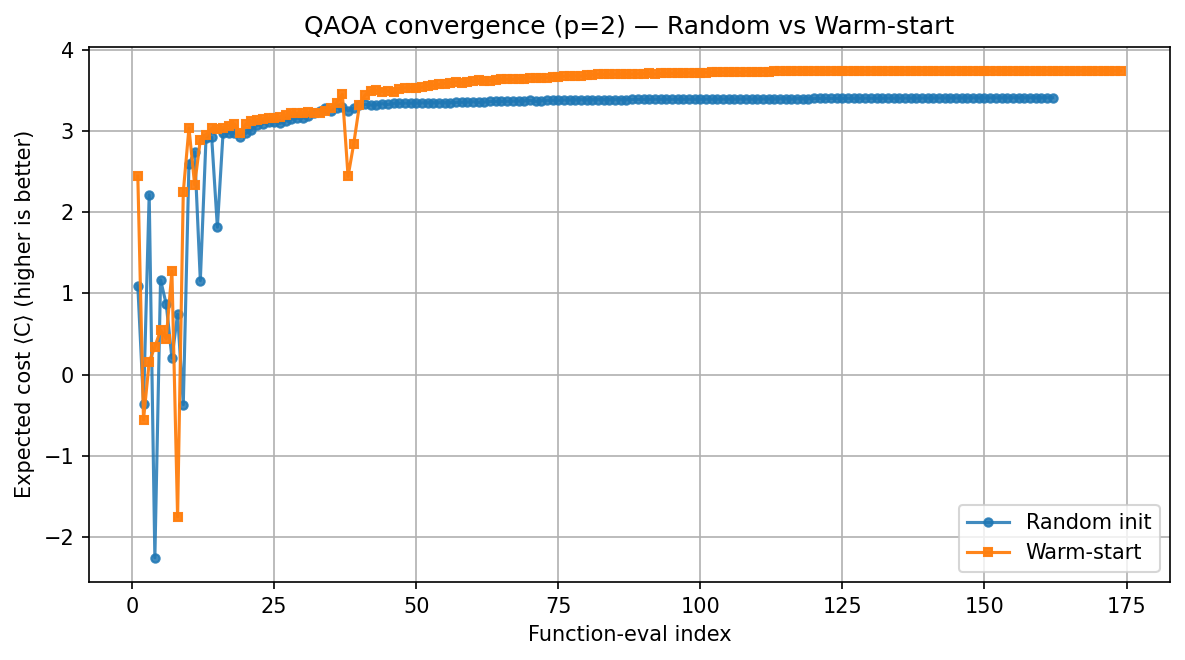

Saved plot to results/qaoa_transfer_convergence.png

--- Final summary ---


,run_type,final_cost_logged,final_cost_from_res,final_fidelity,func_evals,elapsed_seconds,convergence_eval_index
0,random,3.409118,3.409192,0.745047,162,0.876827,21
1,warm,3.738432,3.738520,0.878740,174,1.662333,21


In [ ]:
# ===== Final summary & plots for transfer experiment (run after optimizers completed) =====
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os
plt.rcParams.update({'figure.dpi':150})
os.makedirs("results", exist_ok=True)

# Confirm the optimizer outputs exist
if 'out_rand' not in globals() or 'out_warm' not in globals():
    raise RuntimeError("out_rand or out_warm not found in memory. Re-run the optimization cells first.")

# extract logs
log_rand = out_rand['log_df'].copy()
log_warm = out_warm['log_df'].copy()

# Recompute convergence index function (same as before)
def find_convergence_index(cost_series, rel_tol=1e-6, window=20):
    costs = np.array(cost_series)
    N = len(costs)
    if N < window+1:
        return N
    for i in range(window, N):
        prev = costs[i-window:i]
        if np.max(prev) - np.min(prev) == 0:
            rel_imp = 0.0
        else:
            rel_imp = (np.max(prev) - costs[i]) / max(1e-12, np.max(prev))
        if rel_imp < rel_tol:
            return i+1
    return N

conv_idx_rand = find_convergence_index(log_rand['cost'].values, rel_tol=1e-6, window=20)
conv_idx_warm = find_convergence_index(log_warm['cost'].values, rel_tol=1e-6, window=20)

# final costs (last eval)
final_cost_rand = float(log_rand['cost'].iloc[-1])
final_cost_warm = float(log_warm['cost'].iloc[-1])

# final fidelities using final optimized params (if res.x present)
def get_final_metrics_from_out(out):
    res = out['res']
    if hasattr(res, 'x'):
        x = res.x
        gam = x[:p]; bet = x[p:]
        psi = qaoa_state_from_params(gam, bet)
        fid = subspace_fidelity_from_state(psi, optimal_indices_4)
        cost = float(np.real(np.vdot(psi.conj(), H_P.dot(psi))))
        return cost, fid
    else:
        return np.nan, np.nan

cost_r, fid_r = get_final_metrics_from_out(out_rand)
cost_w, fid_w = get_final_metrics_from_out(out_warm)

# Align logs into a dataframe (step index)
max_len = max(len(log_rand), len(log_warm))
df_align = pd.DataFrame({
    'step': np.arange(1, max_len+1),
    'cost_random': pd.Series(log_rand['cost'].values).reindex(range(max_len)).reset_index(drop=True),
    'cost_warmstart': pd.Series(log_warm['cost'].values).reindex(range(max_len)).reset_index(drop=True)
})
# Save aligned CSVs
df_align.to_csv("results/qaoa_transfer_summary.csv", index=False)

# Save timings and final summary
summary = pd.DataFrame([{
    'run_type':'random', 'final_cost_logged': final_cost_rand, 'final_cost_from_res': cost_r, 'final_fidelity': fid_r,
    'func_evals': out_rand['n_calls'], 'elapsed_seconds': out_rand['elapsed'], 'convergence_eval_index': conv_idx_rand
},{
    'run_type':'warm', 'final_cost_logged': final_cost_warm, 'final_cost_from_res': cost_w, 'final_fidelity': fid_w,
    'func_evals': out_warm['n_calls'], 'elapsed_seconds': out_warm['elapsed'], 'convergence_eval_index': conv_idx_warm
}])
summary.to_csv("results/qaoa_transfer_timing.csv", index=False)
print("Saved CSVs:\n - results/qaoa_transfer_summary.csv\n - results/qaoa_transfer_timing.csv")

# Plot convergence overlay
plt.figure(figsize=(8,4.5))
plt.plot(log_rand['eval_idx'], log_rand['cost'], marker='o', markersize=4, label='Random init', alpha=0.85)
plt.plot(log_warm['eval_idx'], log_warm['cost'], marker='s', markersize=4, label='Warm-start', alpha=0.95)
plt.xlabel("Function-eval index")
plt.ylabel("Expected cost ⟨C⟩ (higher is better)")
plt.title(f"QAOA convergence (p={p}) — Random vs Warm-start")
plt.grid(True); plt.legend()
fn_plot = "results/qaoa_transfer_convergence.png"
plt.tight_layout(); plt.savefig(fn_plot, dpi=200); plt.show()
print("Saved plot to", fn_plot)

# Pretty-print summary table
print("\n--- Final summary ---")
display(summary.round(6))


## Multi-seed experiment and optimizer comparison

We run the QAOA convergence test for multiple random seeds and compare:
- Start strategies: Random init vs Warm-start (parameter transfer from 3-node)
- Optimizers: COBYLA vs SPSA (deterministic implementation)

For each combination (seed, start, optimizer) we record final cost ⟨C⟩, ground-subspace fidelity, number of function-evals, elapsed time, and convergence trace. Results are saved to `/content/results/` for later analysis.


In [ ]:
# ===== Multi-seed experiment: compare COBYLA vs SPSA, Random vs Warm-start =====
# Requirements: H_P, qaoa_state_from_params, expectation_from_state, subspace_fidelity_from_state must exist.

import os, time, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.optimize import minimize
plt.rcParams.update({'figure.dpi':150})
os.makedirs("results", exist_ok=True)

# Experiment settings (edit here)
p = 2                         # QAOA depth (same as earlier)
seeds = list(range(10))       # seeds to run (0..9)
start_types = ['random', 'warm']
optimizers = ['COBYLA', 'SPSA']  # compare both
GLOBAL_BASE_SEED = 42         # base for reproducibility

# Toggle whether to save per-run convergence plots (can slow down)
SAVE_PER_RUN_PLOTS = False

# Load warm_source (if available) from previous robust parser (warm_source dict)
# If not present, fallback mapping will be used (same logic as earlier).
if 'warm_source' in globals() and warm_source:
    ws = warm_source
else:
    ws = None

# helper: form initial vector for given seed and start_type
def get_initial_vector(seed, start_type):
    rng = np.random.default_rng(seed)
    if start_type == 'random':
        gam = rng.uniform(0, math.pi, size=p)
        bet = rng.uniform(0, math.pi/2, size=p)
        return np.concatenate([gam, bet])
    else:
        # warm mapping logic (same as prior cell)
        if ws:
            if p in ws:
                g0, b0 = ws[p]; return np.concatenate([g0[:p], b0[:p]])
            else:
                p_av = sorted(ws.keys())
                if p_av:
                    lesser = [q for q in p_av if q <= p]
                    if lesser:
                        q = lesser[-1]; gq, bq = ws[q]
                        gam = np.tile(gq, int(np.ceil(p/len(gq))))[:p]
                        bet = np.tile(bq, int(np.ceil(p/len(bq))))[:p]
                        return np.concatenate([gam, bet])
                    else:
                        q = p_av[-1]; gq, bq = ws[q]; return np.concatenate([gq[:p], bq[:p]])
        # fallback deterministic warm guess
        gam = np.array([0.5]*p)
        bet = np.array([0.5]*p)
        return np.concatenate([gam, bet])

# Logged objective factory (callable with .log attribute)
def make_logged_objective_callable(H, p):
    log = []
    counter = {'n': 0}
    def objective(x):
        counter['n'] += 1
        gam = np.array(x[:p], dtype=float); bet = np.array(x[p:], dtype=float)
        psi = qaoa_state_from_params(gam, bet)
        cost = expectation_from_state(psi, H)
        log.append((counter['n'], float(cost)))
        return -float(cost)
    objective.log = log
    objective.n_calls = lambda: counter['n']
    return objective

# Simple deterministic SPSA implementation (small-budget) - returns final x, log, evals
def run_spsa(objective_fn, x0, maxiter=200, a=0.1, c=0.1, alpha=0.602, gamma=0.101, seed=0):
    rng = np.random.default_rng(seed)
    x = x0.copy().astype(float)
    n = len(x)
    log = []
    func_evals = 0

    for k in range(1, maxiter+1):
        ak = a / (k ** alpha)
        ck = c / (k ** gamma)
        # symmetric perturbation vector with ±1 entries
        delta = rng.choice([-1.0,1.0], size=n)
        x_plus = x + ck * delta
        x_minus = x - ck * delta
        y_plus = -objective_fn(x_plus); func_evals += 1  # objective returns -cost, so negate to get cost
        y_minus = -objective_fn(x_minus); func_evals += 1
        # gradient estimate
        ghat = (y_plus - y_minus) / (2.0 * ck * delta)
        # update
        x = x + ak * ghat
        # log current cost (evaluate at current x)
        current_cost = -objective_fn(x); func_evals += 1
        log.append((func_evals, float(current_cost)))
        # optional early stopping check: if improvement tiny in last 20 evals...
        if len(log) > 60:
            recent = [c for (_,c) in log[-60:]]
            if max(recent) - min(recent) < 1e-8:
                break
    # attach log attribute for consistency
    objective_fn.log.extend(log)  # append SPSA internal logs to objective's log as well
    return x, log, func_evals

# Runner that handles optimizer selection
def run_single(seed, start_type, optimizer_name):
    x0 = get_initial_vector(seed + GLOBAL_BASE_SEED, start_type)
    obj = make_logged_objective_callable(H_P, p)
    start_time = time.time()
    if optimizer_name == 'COBYLA':
        try:
            res = minimize(obj, x0, method='COBYLA', options={'maxiter':200, 'tol':1e-3, 'disp': False})
            used = 'COBYLA'
            n_calls = obj.n_calls()
            elapsed = time.time() - start_time
            log_df = pd.DataFrame(obj.log, columns=['eval_idx', 'cost'])
            return {'seed':seed, 'start':start_type, 'optimizer':used, 'res':res, 'log_df':log_df, 'n_calls':n_calls, 'elapsed':elapsed}
        except Exception as e:
            # fall back to SPSA
            used='COBYLA_failed_fallback_SPSA'
            x_final, s_log, s_evals = run_spsa(obj, x0, maxiter=200, seed=seed+1)
            elapsed = time.time() - start_time
            # build a fake result-like object
            class ResObj: pass
            r=ResObj(); r.x = x_final
            log_df = pd.DataFrame(obj.log + s_log, columns=['eval_idx','cost'])
            return {'seed':seed, 'start':start_type, 'optimizer':used, 'res':r, 'log_df':log_df, 'n_calls':len(obj.log), 'elapsed':elapsed}
    elif optimizer_name == 'SPSA':
        # run SPSA deterministic
        x_final, s_log, s_evals = run_spsa(obj, x0, maxiter=200, seed=seed+2)
        elapsed = time.time() - start_time
        class ResObj: pass
        r=ResObj(); r.x = x_final
        log_df = pd.DataFrame(obj.log + s_log, columns=['eval_idx','cost'])
        return {'seed':seed, 'start':start_type, 'optimizer':'SPSA', 'res':r, 'log_df':log_df, 'n_calls':len(obj.log), 'elapsed':elapsed}
    else:
        raise ValueError("Unknown optimizer")

# Main loop: run experiments
records = []
per_run_plot_files = []

for seed in seeds:
    for start_type in start_types:
        for opt in optimizers:
            print(f"Running seed={seed}, start={start_type}, opt={opt} ...", end=' ')
            out = run_single(seed, start_type, opt)
            # compute final metrics
            resx = out['res'].x
            gam = np.array(resx[:p]); bet = np.array(resx[p:])
            psi = qaoa_state_from_params(gam, bet)
            final_cost = expectation_from_state(psi, H_P)
            final_fid = subspace_fidelity_from_state(psi, optimal_indices_4)
            n_calls = out['n_calls']
            elapsed = out['elapsed']
            # save per-run convergence plot optionally
            if SAVE_PER_RUN_PLOTS:
                fig, ax = plt.subplots(figsize=(6,3.5))
                df_log = out['log_df']
                ax.plot(df_log['eval_idx'], df_log['cost'], marker='o', markersize=3)
                ax.set_xlabel('function-eval index'); ax.set_ylabel('Expected C'); ax.grid(True)
                fn = f"results/qaoa_multiseed_conv_seed{seed}_{start_type}_{opt}.png"
                fig.tight_layout(); fig.savefig(fn, dpi=200); plt.close(fig)
                per_run_plot_files.append(fn)
            # record
            records.append({
                'seed': seed, 'start': start_type, 'optimizer': opt,
                'final_cost': float(final_cost), 'final_fidelity': float(final_fid),
                'func_evals': int(n_calls), 'elapsed_s': float(elapsed)
            })
            print("done, evals=", n_calls, "time(s)=", round(elapsed,3))

# Save summary CSVs
df_records = pd.DataFrame(records)
df_records.to_csv("results/qaoa_multiseed_summary.csv", index=False)
pd.DataFrame(df_records[['seed','start','optimizer','func_evals','elapsed_s']]).to_csv("results/qaoa_multiseed_timings.csv", index=False)
print("Saved results/qaoa_multiseed_summary.csv and timings CSV.")


Running seed=0, start=random, opt=COBYLA ... done, evals= 162 time(s)= 1.566
Running seed=0, start=random, opt=SPSA ... done, evals= 800 time(s)= 0.552
Running seed=0, start=warm, opt=COBYLA ... done, evals= 174 time(s)= 0.656
Running seed=0, start=warm, opt=SPSA ... done, evals= 800 time(s)= 0.513
Running seed=1, start=random, opt=COBYLA ... done, evals= 200 time(s)= 0.863
Running seed=1, start=random, opt=SPSA ... done, evals= 800 time(s)= 0.482
Running seed=1, start=warm, opt=COBYLA ... done, evals= 174 time(s)= 0.92
Running seed=1, start=warm, opt=SPSA ... done, evals= 800 time(s)= 0.575
Running seed=2, start=random, opt=COBYLA ... done, evals= 200 time(s)= 0.82
Running seed=2, start=random, opt=SPSA ... done, evals= 800 time(s)= 0.551
Running seed=2, start=warm, opt=COBYLA ... done, evals= 174 time(s)= 1.024
Running seed=2, start=warm, opt=SPSA ... done, evals= 800 time(s)= 0.5
Running seed=3, start=random, opt=COBYLA ... done, evals= 189 time(s)= 0.841
Running seed=3, start=rando

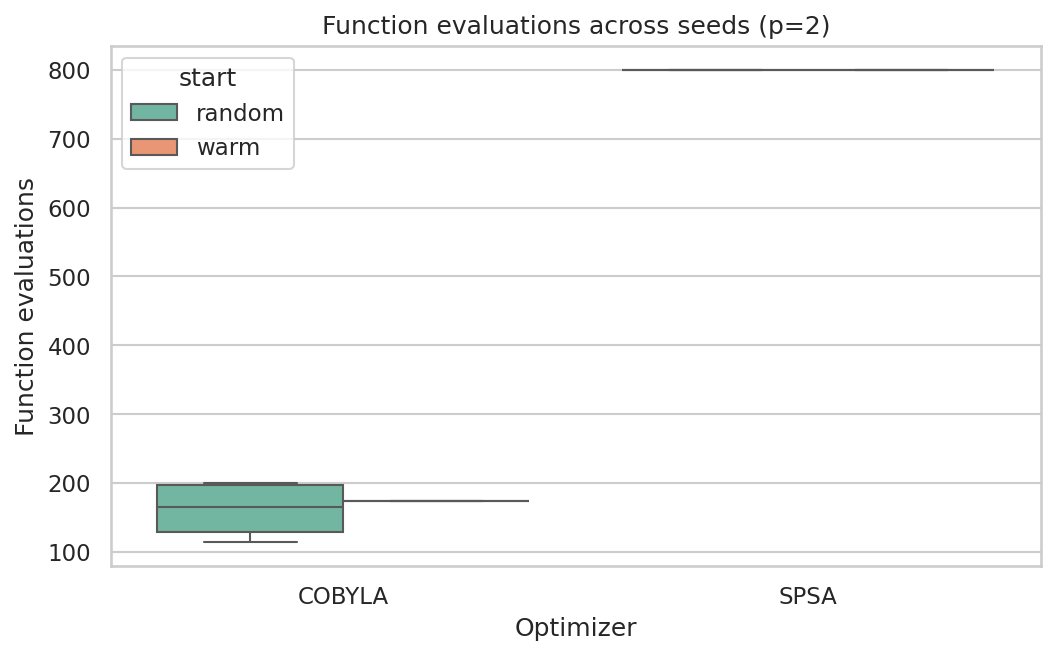

✅ Saved results/qaoa_multiseed_boxplot_func_evals.png


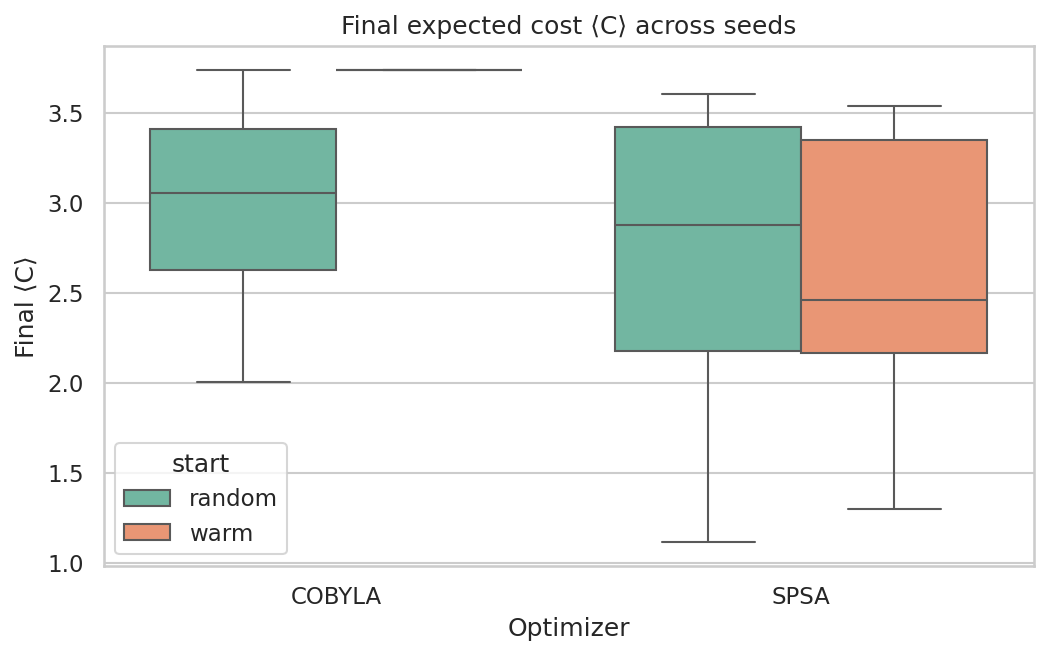

✅ Saved results/qaoa_multiseed_boxplot_final_cost.png

📊 Summary statistics (mean ± std):


func_evals                      final_cost            \
                       mean        std  min  max       mean       std   
start  optimizer                                                        
random COBYLA         162.1  34.401066  114  200   2.971680  0.616780   
       SPSA           800.0   0.000000  800  800   2.735519  0.830848   
warm   COBYLA         174.0   0.000000  174  174   3.738520  0.000000   
       SPSA           800.0   0.000000  800  800   2.638178  0.747427   

                                     final_fidelity                      \
                       min       max           mean       std       min   
start  optimizer                                                          
random COBYLA     2.001458  3.738322       0.547626  0.275052  0.125463   
       SPSA       1.113184  3.601945       0.469704  0.321037  0.017986   
warm   COBYLA     3.738520  3.738520       0.878740  0.000000  0.878740   
       SPSA       1.298808  3.539389       0.434016  0.304155  0.028558   

                           elapsed_s                                
                       max      mean       std       min       max  
start  optimizer                                                    
random COBYLA     0.877532  0.659902  0.390349  0.283108  1.565783  
       SPSA       0.820631  0.412548  0.131564  0.251841  0.616624  
warm   COBYLA     0.878740  0.584305  0.224287  0.380615  1.023794  
       SPSA       0.789799  0.377442  0.132484  0.233869  0.574937

In [ ]:
# ===== Multi-seed results analysis and visualization =====
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
sns.set(style='whitegrid', font_scale=1.0)

df = pd.read_csv("results/qaoa_multiseed_summary.csv")

# Boxplot: Function evaluations by (start, optimizer)
plt.figure(figsize=(8,4.5))
sns.boxplot(x='optimizer', y='func_evals', hue='start', data=df, palette='Set2')
plt.title(f'Function evaluations across seeds (p={p})')
plt.ylabel('Function evaluations')
plt.xlabel('Optimizer')
plt.savefig("results/qaoa_multiseed_boxplot_func_evals.png", dpi=200, bbox_inches='tight')
plt.show()
print("✅ Saved results/qaoa_multiseed_boxplot_func_evals.png")

# Boxplot: Final expected cost ⟨C⟩
plt.figure(figsize=(8,4.5))
sns.boxplot(x='optimizer', y='final_cost', hue='start', data=df, palette='Set2')
plt.title('Final expected cost ⟨C⟩ across seeds')
plt.ylabel('Final ⟨C⟩')
plt.xlabel('Optimizer')
plt.savefig("results/qaoa_multiseed_boxplot_final_cost.png", dpi=200, bbox_inches='tight')
plt.show()
print("✅ Saved results/qaoa_multiseed_boxplot_final_cost.png")

# Print summary stats
summary = df.groupby(['start','optimizer'])[['func_evals','final_cost','final_fidelity','elapsed_s']].agg(['mean','std','min','max']).round(6)
print("\n📊 Summary statistics (mean ± std):")
display(summary)


Running sweep: seeds=15, optimizers=['COBYLA', 'SPSA'], jitter_sigmas=[0.0, 0.05, 0.1, 0.2]
Estimated total runs: 120
Warm-source available for p keys: [1, 2, 3, 4, 5, 6]
seed=0 start=random opt=COBYLA evals=162 time=0.362
seed=0 start=warm opt=COBYLA evals=174 time=0.360
seed=0 start=warm_jitter_0.050 opt=COBYLA evals=200 time=0.453
seed=0 start=warm_jitter_0.100 opt=COBYLA evals=200 time=0.455
seed=0 start=warm_jitter_0.200 opt=COBYLA evals=108 time=0.268
seed=0 start=random opt=SPSA evals=800 time=0.244
seed=0 start=warm opt=SPSA evals=800 time=0.260
seed=0 start=warm_jitter_0.050 opt=SPSA evals=800 time=0.259
seed=0 start=warm_jitter_0.100 opt=SPSA evals=800 time=0.286
seed=0 start=warm_jitter_0.200 opt=SPSA evals=800 time=0.279
seed=1 start=random opt=COBYLA evals=200 time=0.709
seed=1 start=warm opt=COBYLA evals=174 time=0.540
seed=1 start=warm_jitter_0.050 opt=COBYLA evals=122 time=0.383
seed=1 start=warm_jitter_0.100 opt=COBYLA evals=170 time=0.554
seed=1 start=warm_jitter_0.20

,jitter_sigma,median,mean,std,count
1,0.05,157.0,160.133,33.711,15
0,0.00,174.0,173.833,22.644,30
2,0.10,180.0,168.200,33.443,15
3,0.20,200.0,169.533,39.885,15


Best jitter_sigma (COBYLA median func_evals): 0.05


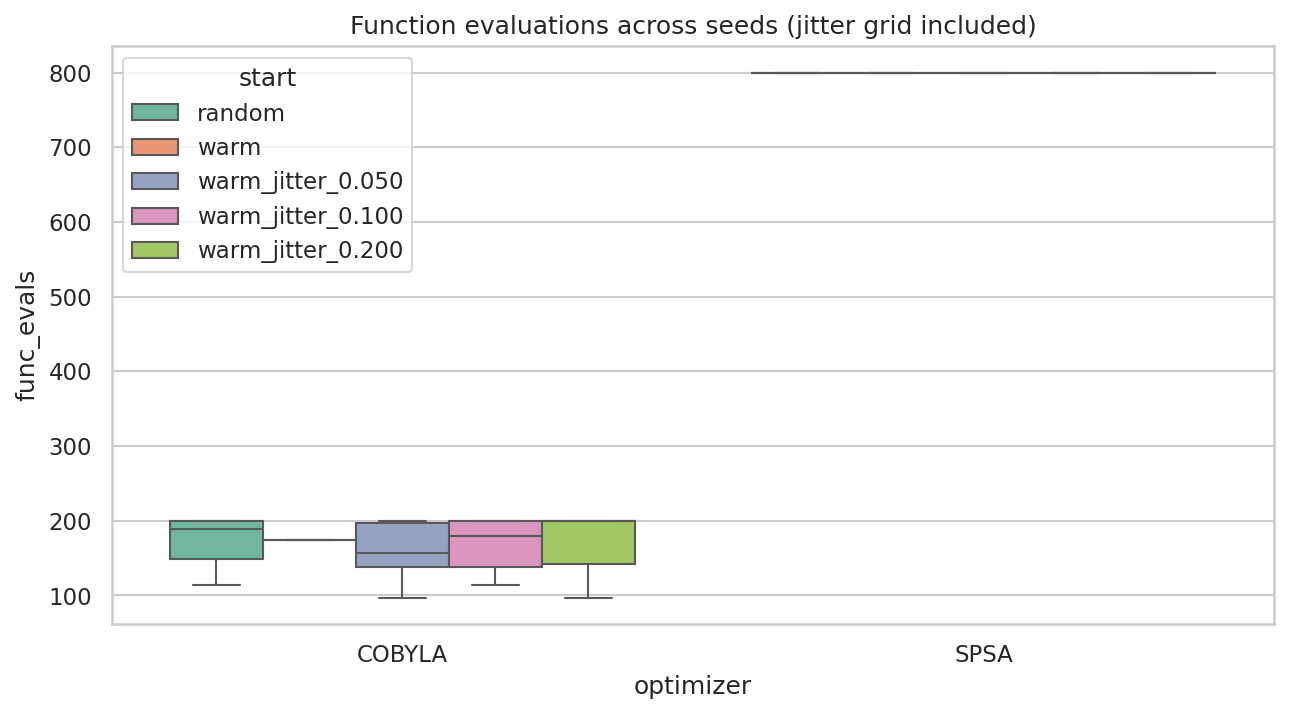

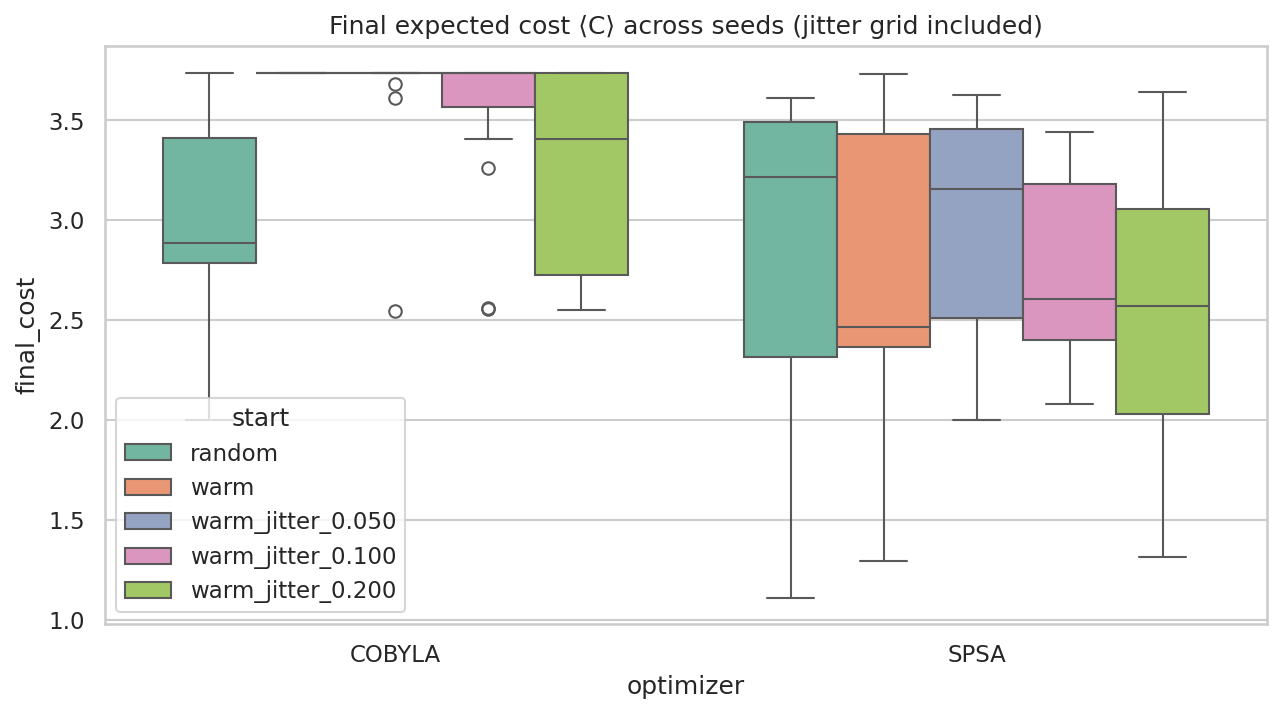


Done.


In [ ]:
# ===== Fixed multi-seed + multi-jitter sweep (robust get_initial_vector) =====
# Copy-paste and run this full cell. It restarts the sweep from scratch.

import os, time, math, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.linalg import expm, eigh
from scipy.optimize import minimize
plt.rcParams.update({'figure.dpi':150})
sns.set(style='whitegrid', font_scale=1.0)
os.makedirs("results", exist_ok=True)

# ---------------- USER SETTINGS ----------------
p = 2
seeds = list(range(15))            # adjust if needed
optimizers = ['COBYLA', 'SPSA']
jitter_sigmas = [0.0, 0.05, 0.10, 0.20]
GLOBAL_BASE_SEED = 42
maxiter_cobyla = 200
maxiter_spsa = 200
PRINT_PROGRESS = True
# ------------------------------------------------

print(f"Running sweep: seeds={len(seeds)}, optimizers={optimizers}, jitter_sigmas={jitter_sigmas}")
print("Estimated total runs:", len(seeds) * len(optimizers) * (1 + (len(jitter_sigmas)-1)))

# ---------------- helpers & ensure H_P exists ----------------
def kron_n(ops):
    out = ops[0]
    for op in ops[1:]:
        out = np.kron(out, op)
    return out

if 'H_P' not in globals() or 'H_M' not in globals() or 'optimal_indices_4' not in globals():
    I2 = np.array([[1,0],[0,1]], dtype=complex)
    X = np.array([[0,1],[1,0]], dtype=complex)
    Z = np.array([[1,0],[0,-1]], dtype=complex)
    def ZZ_pair(i,j):
        ops = [I2]*4; ops[i]=Z; ops[j]=Z; return kron_n(ops)
    ZZ_01, ZZ_12, ZZ_23, ZZ_30 = ZZ_pair(0,1), ZZ_pair(1,2), ZZ_pair(2,3), ZZ_pair(3,0)
    I16 = np.eye(16, dtype=complex)
    H_P = 0.5 * (4*I16 - (ZZ_01 + ZZ_12 + ZZ_23 + ZZ_30))
    XM0 = kron_n([X,I2,I2,I2]); XM1 = kron_n([I2,X,I2,I2]); XM2 = kron_n([I2,I2,X,I2]); XM3 = kron_n([I2,I2,I2,X])
    H_M = XM0 + XM1 + XM2 + XM3

basis_states_4 = ['{0:04b}'.format(i) for i in range(16)]
def cost_from_bitstring_4(bitstr):
    z = np.array([1 if b=='0' else -1 for b in bitstr], dtype=int)
    return 0.5*((1 - z[0]*z[1]) + (1 - z[1]*z[2]) + (1 - z[2]*z[3]) + (1 - z[3]*z[0]))
diag_costs_4 = np.array([cost_from_bitstring_4(bs) for bs in basis_states_4])
Cmax_4 = diag_costs_4.max()
optimal_indices_4 = np.where(np.isclose(diag_costs_4, Cmax_4))[0]

# QAOA state using scipy.linalg.expm
def plus_state(n=4):
    plus = (1/np.sqrt(2)) * np.array([1,1], dtype=complex)
    psi = plus
    for _ in range(n-1):
        psi = np.kron(psi, plus)
    return psi

def qaoa_state_from_params(gammas, betas):
    psi = plus_state(4)
    for layer in range(len(gammas)):
        Uc = expm(-1j * gammas[layer] * H_P)
        psi = Uc.dot(psi)
        angle = 2 * betas[layer]
        Rx = np.array([[math.cos(angle/2), -1j*math.sin(angle/2)],
                       [-1j*math.sin(angle/2), math.cos(angle/2)]], dtype=complex)
        UX = kron_n([Rx,Rx,Rx,Rx])
        psi = UX.dot(psi)
    psi /= np.linalg.norm(psi)
    return psi

def expectation_from_state(psi, H):
    return float(np.real(np.vdot(psi.conj(), H.dot(psi))))

def subspace_fidelity_from_state(psi, opt_indices=optimal_indices_4):
    probs = np.abs(psi)**2
    return float(np.sum(probs[opt_indices]))

# ---------------- warm_source loader (robust) ----------------
if 'warm_source' in globals() and warm_source:
    ws = warm_source
else:
    ws = {}
    csv_src = "results/qaoa_results.csv"
    if os.path.exists(csv_src):
        try:
            dfq = pd.read_csv(csv_src)
            import re, ast
            def try_parse_row(s):
                num_re = r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?'
                blocks = re.findall(r'(\[[^\]]*\]|\([^\)]*\))', str(s))
                if len(blocks) >= 2:
                    g = ast.literal_eval(blocks[0].replace('(', '[').replace(')', ']'))
                    b = ast.literal_eval(blocks[1].replace('(', '[').replace(')', ']'))
                    return np.array(g,dtype=float), np.array(b,dtype=float)
                nums = re.findall(num_re, str(s))
                if len(nums) >= 2:
                    half = len(nums)//2
                    g = np.array([float(x) for x in nums[:half]])
                    b = np.array([float(x) for x in nums[half:]])
                    return g,b
                raise ValueError("cannot parse")
            for _, r in dfq.iterrows():
                if str(r.get('method','')).strip() != 'manual_qaoa': continue
                pval = int(r['p']); s = str(r['params'])
                try:
                    g,b = try_parse_row(s)
                    ws[pval] = (g,b)
                except Exception:
                    continue
            if not ws:
                ws = None
        except Exception:
            ws = None
    else:
        ws = None

if ws:
    print("Warm-source available for p keys:", sorted(ws.keys()))
else:
    print("No warm-source found; warm starts will use deterministic fallback [0.5]")

# ---------------- correct get_initial_vector (robust parsing) ----------------
def get_initial_vector(seed, start_type, jitter_sigma=0.10):
    rng = np.random.default_rng(seed)
    if start_type == 'random':
        gam = rng.uniform(0, math.pi, size=p)
        bet = rng.uniform(0, math.pi/2, size=p)
        return np.concatenate([gam, bet])
    # handle warm or warm_jitter_xxx robustly
    if start_type.startswith('warm'):
        # determine sigma: if string contains numeric suffix parse it, else use jitter_sigma param
        sigma = jitter_sigma
        parts = start_type.split('_')
        # possible forms: 'warm', 'warm_jitter', 'warm_jitter_0.050'
        try:
            # look for last part that can be parsed as float
            for part in reversed(parts):
                try:
                    sigma = float(part)
                    break
                except Exception:
                    continue
        except Exception:
            sigma = jitter_sigma
        # base warm vector
        if ws:
            if p in ws:
                base_g = ws[p][0][:p]; base_b = ws[p][1][:p]
            else:
                p_av = sorted(ws.keys()) if ws else []
                if p_av:
                    lesser = [q for q in p_av if q <= p]
                    if lesser:
                        q = lesser[-1]; gq,bq = ws[q]; base_g = np.tile(gq, int(np.ceil(p/len(gq))))[:p]; base_b = np.tile(bq, int(np.ceil(p/len(bq))))[:p]
                    else:
                        q = p_av[-1]; gq,bq = ws[q]; base_g = gq[:p]; base_b = bq[:p]
                else:
                    base_g = np.array([0.5]*p); base_b = np.array([0.5]*p)
        else:
            base_g = np.array([0.5]*p); base_b = np.array([0.5]*p)
        if 'jitter' in start_type:
            rng2 = np.random.default_rng(seed + GLOBAL_BASE_SEED)
            g_j = rng2.normal(loc=0.0, scale=sigma, size=p)
            b_j = rng2.normal(loc=0.0, scale=sigma, size=p)
            return np.concatenate([base_g + g_j, base_b + b_j])
        else:
            return np.concatenate([base_g, base_b])

    raise ValueError("Unknown start_type")

# ---------------- logging objective + SPSA impl ----------------
def make_logged_objective(H):
    log = []
    counter = {'n': 0}
    def obj(x):
        counter['n'] += 1
        gam = np.array(x[:p], dtype=float); bet = np.array(x[p:], dtype=float)
        psi = qaoa_state_from_params(gam, bet)
        cost = expectation_from_state(psi, H)
        log.append((counter['n'], float(cost)))
        return -float(cost)
    obj.log = log
    obj.n_calls = lambda: counter['n']
    return obj

def run_spsa(objective_fn, x0, maxiter=200, a=0.1, c=0.1, alpha=0.602, gamma=0.101, seed=0):
    rng = np.random.default_rng(seed)
    x = x0.copy().astype(float)
    n = len(x)
    log = []
    func_evals = 0
    for k in range(1, maxiter+1):
        ak = a / (k ** alpha); ck = c / (k ** gamma)
        delta = rng.choice([-1.0,1.0], size=n)
        x_plus = x + ck * delta
        x_minus = x - ck * delta
        y_plus = -objective_fn(x_plus); func_evals += 1
        y_minus = -objective_fn(x_minus); func_evals += 1
        ghat = (y_plus - y_minus) / (2.0 * ck * delta)
        x = x + ak * ghat
        current_cost = -objective_fn(x); func_evals += 1
        log.append((func_evals, float(current_cost)))
        if len(log) > 60:
            recent = [c for (_,c) in log[-60:]]
            if max(recent) - min(recent) < 1e-8:
                break
    objective_fn.log.extend(log)
    return x, log, func_evals

# ---------------- Main sweep (fixed) ----------------
records = []
for seed in seeds:
    for optimizer_name in optimizers:
        # random and exact warm
        for base_start in ['random','warm']:
            start_type = base_start
            x0 = get_initial_vector(seed + GLOBAL_BASE_SEED, start_type)
            obj = make_logged_objective(H_P)
            start_time = time.time()
            if optimizer_name == 'COBYLA':
                try:
                    res = minimize(obj, x0, method='COBYLA', options={'maxiter':maxiter_cobyla, 'tol':1e-3, 'disp': False})
                    used = 'COBYLA'
                    n_calls = obj.n_calls()
                    elapsed = time.time()-start_time
                    log_df = pd.DataFrame(obj.log, columns=['eval_idx','cost'])
                except Exception:
                    x_final, s_log, s_evals = run_spsa(obj, x0, maxiter=maxiter_spsa, seed=seed+1)
                    elapsed = time.time()-start_time
                    class ResObj: pass
                    res = ResObj(); res.x = x_final
                    used = 'COBYLA_failed_SPSA'
                    n_calls = len(obj.log)
                    log_df = pd.DataFrame(obj.log, columns=['eval_idx','cost'])
            else:  # SPSA
                x_final, s_log, s_evals = run_spsa(obj, x0, maxiter=maxiter_spsa, seed=seed+2)
                elapsed = time.time()-start_time
                class ResObj: pass
                res = ResObj(); res.x = x_final
                used = 'SPSA'
                n_calls = len(obj.log)
                log_df = pd.DataFrame(obj.log, columns=['eval_idx','cost'])

            gam = np.array(res.x[:p]); bet = np.array(res.x[p:])
            psi = qaoa_state_from_params(gam, bet)
            final_cost = expectation_from_state(psi, H_P)
            final_fid = subspace_fidelity_from_state(psi, optimal_indices_4)
            records.append({'seed':seed, 'start':start_type, 'jitter_sigma':0.0, 'optimizer':used,
                            'final_cost':float(final_cost), 'final_fidelity':float(final_fid),
                            'func_evals':int(n_calls), 'elapsed_s':float(elapsed)})
            if PRINT_PROGRESS:
                print(f"seed={seed} start={start_type} opt={used} evals={n_calls} time={elapsed:.3f}")

        # now run warm_jitter for each nonzero sigma
        for sigma in jitter_sigmas:
            if sigma <= 0.0:
                continue
            start_type = f"warm_jitter_{sigma:.3f}"
            x0 = get_initial_vector(seed + GLOBAL_BASE_SEED, start_type, jitter_sigma=sigma)
            obj = make_logged_objective(H_P)
            start_time = time.time()
            if optimizer_name == 'COBYLA':
                try:
                    res = minimize(obj, x0, method='COBYLA', options={'maxiter':maxiter_cobyla, 'tol':1e-3, 'disp': False})
                    used = 'COBYLA'
                    n_calls = obj.n_calls()
                    elapsed = time.time()-start_time
                    log_df = pd.DataFrame(obj.log, columns=['eval_idx','cost'])
                except Exception:
                    x_final, s_log, s_evals = run_spsa(obj, x0, maxiter=maxiter_spsa, seed=seed+1)
                    elapsed = time.time()-start_time
                    class ResObj: pass
                    res = ResObj(); res.x = x_final
                    used = 'COBYLA_failed_SPSA'
                    n_calls = len(obj.log)
                    log_df = pd.DataFrame(obj.log, columns=['eval_idx','cost'])
            else:  # SPSA
                x_final, s_log, s_evals = run_spsa(obj, x0, maxiter=maxiter_spsa, seed=seed+2)
                elapsed = time.time()-start_time
                class ResObj: pass
                res = ResObj(); res.x = x_final
                used = 'SPSA'
                n_calls = len(obj.log)
                log_df = pd.DataFrame(obj.log, columns=['eval_idx','cost'])

            gam = np.array(res.x[:p]); bet = np.array(res.x[p:])
            psi = qaoa_state_from_params(gam, bet)
            final_cost = expectation_from_state(psi, H_P)
            final_fid = subspace_fidelity_from_state(psi, optimal_indices_4)
            records.append({'seed':seed, 'start':start_type, 'jitter_sigma':sigma, 'optimizer':used,
                            'final_cost':float(final_cost), 'final_fidelity':float(final_fid),
                            'func_evals':int(n_calls), 'elapsed_s':float(elapsed)})
            if PRINT_PROGRESS:
                print(f"seed={seed} start={start_type} opt={used} evals={n_calls} time={elapsed:.3f}")

# Save results
df = pd.DataFrame(records)
fn_summary = "results/qaoa_multiseed_jitter_grid_summary.csv"
fn_timings = "results/qaoa_multiseed_jitter_grid_timings.csv"
df.to_csv(fn_summary, index=False)
df[['seed','start','jitter_sigma','optimizer','func_evals','elapsed_s']].to_csv(fn_timings, index=False)
print("\nSaved:", fn_summary, fn_timings)

# Simple analysis
df_cobyla = df[df['optimizer'].str.contains('COBYLA')]
agg = df_cobyla.groupby(['jitter_sigma'])['func_evals'].agg(['median','mean','std','count']).reset_index().sort_values('median')
display(agg.round(3))
best_sigma = float(agg.loc[agg['median'].idxmin(),'jitter_sigma'])
print("Best jitter_sigma (COBYLA median func_evals):", best_sigma)

# Save plots
plt.figure(figsize=(10,5))
sns.boxplot(x='optimizer', y='func_evals', hue='start', data=df, palette='Set2')
plt.title('Function evaluations across seeds (jitter grid included)')
plt.savefig("results/qaoa_multiseed_boxplot_func_evals_jitter_grid.png", dpi=200, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x='optimizer', y='final_cost', hue='start', data=df, palette='Set2')
plt.title('Final expected cost ⟨C⟩ across seeds (jitter grid included)')
plt.savefig("results/qaoa_multiseed_boxplot_final_cost_jitter_grid.png", dpi=200, bbox_inches='tight')
plt.show()

print("\nDone.")


# Problem 6 — Adiabatic Quantum Computation (2 qubits) ⚙️

**Goal.** Simulate H(s) = (1-s) H0 + s HP for a 2-qubit example, plot eigenvalues, estimate adiabatic time T, integrate the time-dependent Schrödinger equation and analyze small-T non-adiabatic scaling.

**Plan (cells)**:
- 6(a): build matrices H0, HP, H(s); print and heatmap.
- 6(b): diagonalize across s ∈ [0,1], plot eigenvalues and spectral gap Δ(s).
- 6(c): compute matrix element ⟨E1| dH/ds |E0⟩, get max and estimate T_ad.
- 6(d): integrate Schrödinger eqn for several T, plot fidelity F(t) and final F(T) vs T.
- 6(e): small-T scaling: fit P_success(T) ∝ T^α and plot log-log.
- Bonus: continuous-time quantum walk mapping (short discussion).


In [ ]:
# Cell 1 — imports & helpers
import os, time, math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import eigh, expm
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

# Make results folder
os.makedirs("results", exist_ok=True)

# plotting defaults
plt.rcParams.update({'figure.dpi':150, 'figure.figsize':(7,4)})

# Helpers: convert complex state to real vector and back for solve_ivp
def complex_to_realvec(psi):
    # psi shape (N,), complex -> real vector shape (2N,)
    return np.concatenate([psi.real, psi.imag])

def realvec_to_complex(y):
    N2 = len(y)//2
    return y[:N2] + 1j * y[N2:]

# time derivative wrapper for Schrödinger equation: dy/dt = -i H(t/T) y
def schrod_rhs_factory(H_of_t):
    # H_of_t: function t -> Hamiltonian (N x N) complex
    def rhs_real(t, y):
        psi = realvec_to_complex(y)
        H = H_of_t(t)
        dpsi = -1j * (H.dot(psi))
        return complex_to_realvec(dpsi)
    return rhs_real

# fidelity helper
def fidelity(state1, state2):
    return np.abs(np.vdot(state1.conj(), state2))**2

print("Helpers ready. Results will be saved to ./results/")


Helpers ready. Results will be saved to ./results/


H0 (s=0):
[[ 0.75+0.j -0.25+0.j -0.25+0.j -0.25+0.j]
 [-0.25+0.j  0.75+0.j -0.25+0.j -0.25+0.j]
 [-0.25+0.j -0.25+0.j  0.75+0.j -0.25+0.j]
 [-0.25+0.j -0.25+0.j -0.25+0.j  0.75+0.j]]

HP (s=1):
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


/tmp/ipython-input-4067315011.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.95])


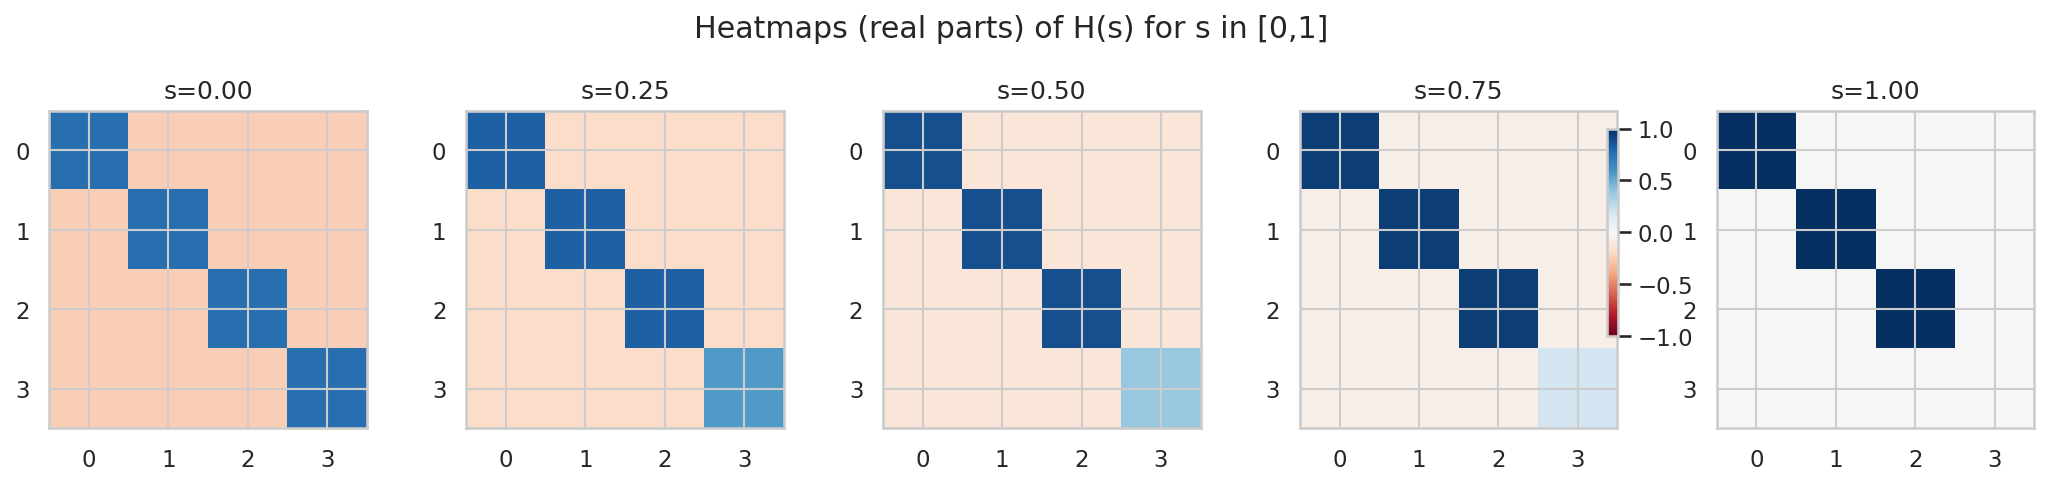

Saved: results/problem6_Hs_heatmaps.png


In [ ]:
# Cell 2 — H0, HP, H(s) construction and heatmaps
# Define 2-qubit basis and projectors as described in the prompt

# Pauli and identity for single qubit
I = np.eye(2, dtype=complex)
# computational basis states
zero = np.array([1.0,0.0], dtype=complex)
one  = np.array([0.0,1.0], dtype=complex)

# 2-qubit computational basis vectors
basis = [np.kron(a,b) for a in (zero,one) for b in (zero,one)]
# function to build projector onto a given vector
def projector(vec):
    vec = vec.reshape((-1,1))
    return vec.dot(vec.conj().T)

# Define |psi0> = uniform superposition over 2 qubits (1/2 sum over basis)
psi0 = (1/2.0) * sum(basis)   # shape (4,)
proj_psi0 = projector(psi0)

# Define |11><11|
proj_11 = projector(np.kron(one, one))

# Define Hamiltonians (as in prompt)
H0 = np.eye(4, dtype=complex) - proj_psi0
HP = np.eye(4, dtype=complex) - proj_11

# H(s)
def H_of_s(s):
    return (1.0 - s) * H0 + s * HP

# Print matrices for s=0 and s=1
np.set_printoptions(precision=6, suppress=True)
print("H0 (s=0):")
print(H0)
print("\nHP (s=1):")
print(HP)

# Heatmaps for s=0,0.25,0.5,0.75,1
s_list = [0.0, 0.25, 0.5, 0.75, 1.0]
fig, axes = plt.subplots(1, len(s_list), figsize=(14,3))
for ax, s in zip(axes, s_list):
    mat = H_of_s(s)
    im = ax.imshow(np.real(mat), cmap='RdBu', vmin=-1, vmax=1)
    ax.set_title(f"s={s:.2f}")
    ax.set_xticks(range(4)); ax.set_yticks(range(4))
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
plt.suptitle("Heatmaps (real parts) of H(s) for s in [0,1]")
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig("results/problem6_Hs_heatmaps.png", dpi=200)
plt.show()
print("Saved: results/problem6_Hs_heatmaps.png")


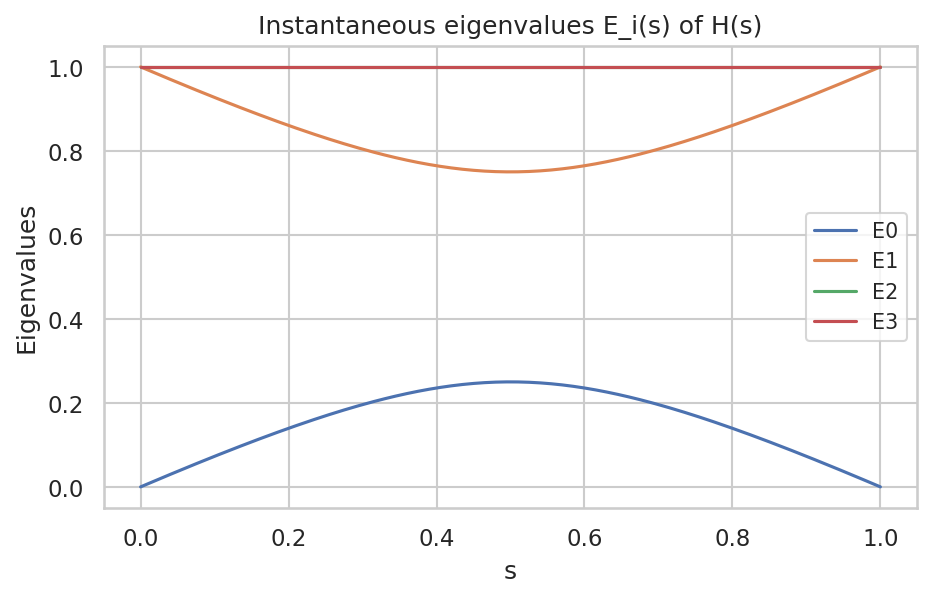

Saved: results/problem6_eigenvalues.png
Minimum gap Δ_min = 5.000000e-01 at s = 0.500000


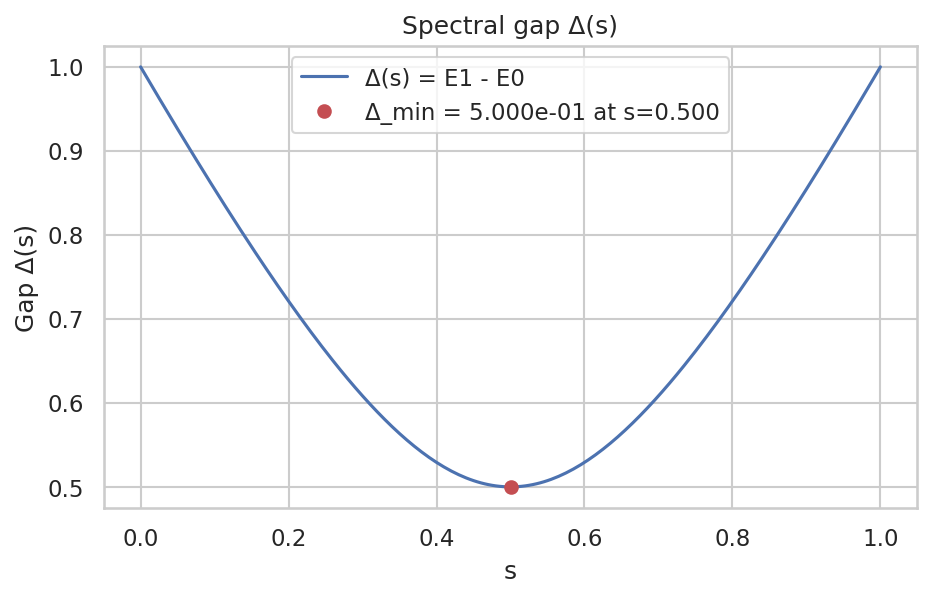

Saved: results/problem6_gap.png


In [ ]:
# Cell 3 — diagonalize H(s) across s grid; plot eigenvalues and gap
s_grid = np.linspace(0.0, 1.0, 201)
eigvals = np.zeros((len(s_grid), 4))
eigvecs = np.zeros((len(s_grid), 4, 4), dtype=complex)  # eigvecs[k,:,j] = j-th eigenvector at s_k (columns)

for i, s in enumerate(s_grid):
    Hs = H_of_s(s)
    w, v = eigh(Hs)   # eigh sorts ascending
    eigvals[i,:] = w
    eigvecs[i,:,:] = v  # columns are eigenvectors

# plot eigenvalues
plt.figure()
for j in range(4):
    plt.plot(s_grid, eigvals[:,j], label=f"E{j}")
plt.xlabel("s"); plt.ylabel("Eigenvalues")
plt.title("Instantaneous eigenvalues E_i(s) of H(s)")
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.savefig("results/problem6_eigenvalues.png", dpi=200)
plt.show()
print("Saved: results/problem6_eigenvalues.png")

# spectral gap E1 - E0
gap = eigvals[:,1] - eigvals[:,0]
imin = np.argmin(gap)
s_gap = s_grid[imin]
gap_min = gap[imin]
print(f"Minimum gap Δ_min = {gap_min:.6e} at s = {s_gap:.6f}")

plt.figure()
plt.plot(s_grid, gap, label="Δ(s) = E1 - E0")
plt.plot(s_gap, gap_min, 'ro', label=f"Δ_min = {gap_min:.3e} at s={s_gap:.3f}")
plt.xlabel("s"); plt.ylabel("Gap Δ(s)")
plt.title("Spectral gap Δ(s)")
plt.legend()
plt.grid(True)
plt.savefig("results/problem6_gap.png", dpi=200)
plt.show()
print("Saved: results/problem6_gap.png")


Max matrix element |<E1|dH/ds|E0>| = 8.660254e-01 at s=0.500000
Estimate T_ad (adiabatic) ~ M_max / Δ_min^2 = 3.464102e+00


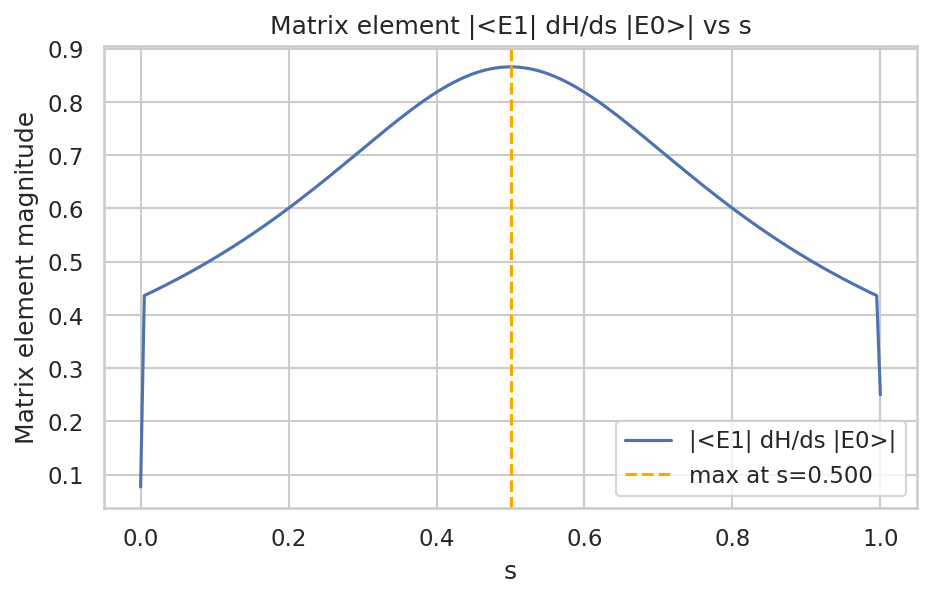

Saved: results/problem6_matrix_element.png


In [ ]:
# Cell 4 — compute dH/ds (finite difference), matrix elements, and estimate T_ad
ds = 1e-6
s_for_deriv = s_grid  # reuse grid
M_vals = np.zeros_like(s_for_deriv)

for i, s in enumerate(s_for_deriv):
    # central finite difference for dH/ds
    s_plus = min(1.0, s + ds)
    s_minus = max(0.0, s - ds)
    dHds = (H_of_s(s_plus) - H_of_s(s_minus)) / (s_plus - s_minus)
    # eigenvectors at s (columns in eigvecs)
    v0 = eigvecs[i,:,0]   # ground eigenvector at s
    v1 = eigvecs[i,:,1]   # first excited
    val = np.vdot(v1.conj(), dHds.dot(v0))
    M_vals[i] = np.abs(val)

M_max = np.max(M_vals)
s_M = s_for_deriv[np.argmax(M_vals)]
T_est = M_max / (gap_min**2 + 1e-30)   # small eps to avoid zero div
print(f"Max matrix element |<E1|dH/ds|E0>| = {M_max:.6e} at s={s_M:.6f}")
print(f"Estimate T_ad (adiabatic) ~ M_max / Δ_min^2 = {T_est:.6e}")

# plot M(s)
plt.figure()
plt.plot(s_for_deriv, M_vals, label="|<E1| dH/ds |E0>|")
plt.axvline(s_M, color='orange', linestyle='--', label=f"max at s={s_M:.3f}")
plt.xlabel("s"); plt.ylabel("Matrix element magnitude")
plt.title("Matrix element |<E1| dH/ds |E0>| vs s")
plt.legend(); plt.grid(True)
plt.savefig("results/problem6_matrix_element.png", dpi=200)
plt.show()
print("Saved: results/problem6_matrix_element.png")


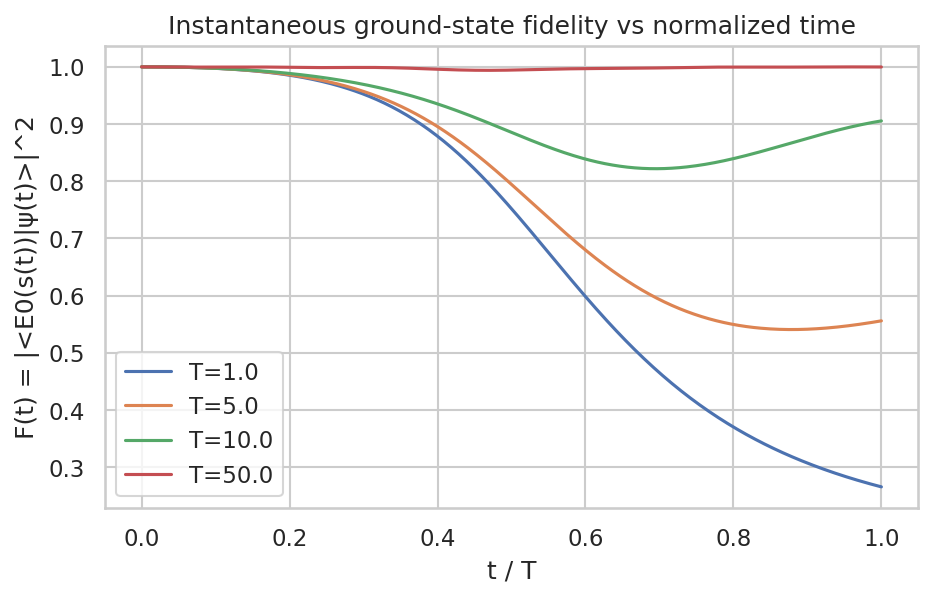

Saved: results/problem6_fidelity_vs_time.png


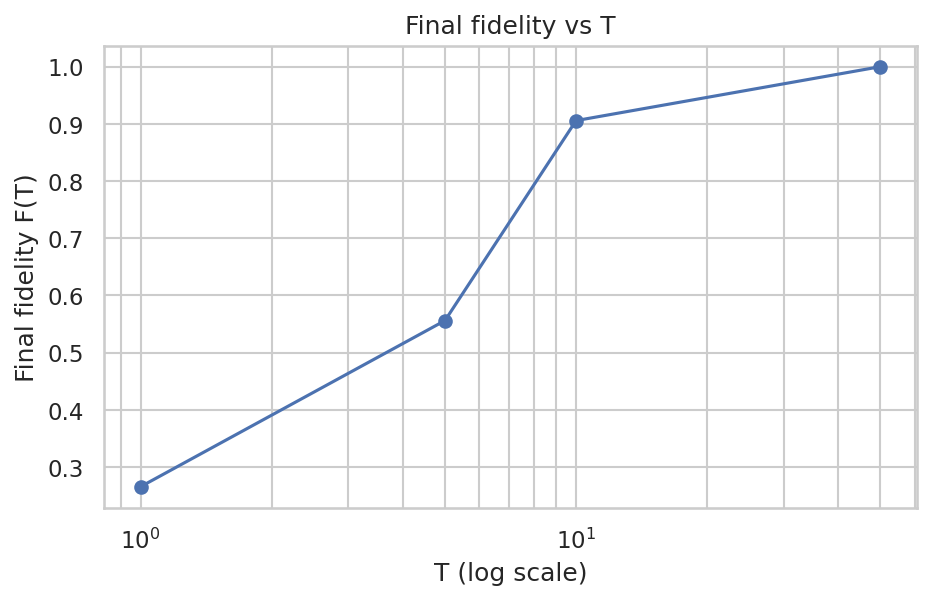

Saved: results/problem6_final_fidelity_vs_T.png


In [ ]:
# Cell 5 — time-dependent evolution for several T values and fidelity plots
T_list = [1.0, 5.0, 10.0, 50.0]
t_eval_resolution = 400  # points for fidelity curve

# initial state: ground state of H0 (s=0)
w0, v0 = eigh(H_of_s(0.0))
psi_init = v0[:,0]   # ground state vector at s=0 (should be psi0)

fidelity_results = {}  # store arrays

for T in T_list:
    # H(t/T) function
    def H_time(t):
        s = t / T
        return H_of_s(s)
    # build RHS
    rhs = schrod_rhs_factory(H_time)
    # integration time points
    t_span = (0.0, T)
    t_eval = np.linspace(0.0, T, t_eval_resolution)
    y0 = complex_to_realvec(psi_init)
    sol = solve_ivp(rhs, t_span, y0, t_eval=t_eval, method='RK45', atol=1e-9, rtol=1e-7)
    psi_t = np.array([realvec_to_complex(sol.y[:,i]) for i in range(sol.y.shape[1])])
    # instantaneous ground states at corresponding s
    fidelities = np.zeros(len(t_eval))
    for i, t in enumerate(t_eval):
        s = t / T
        # interpolate eigenvector at this s by diagonalizing H(s) (cheap for 2 qubits)
        w, v = eigh(H_of_s(s))
        gs = v[:,0]
        fidelities[i] = fidelity(gs, psi_t[i])
    fidelity_results[T] = (t_eval/T, fidelities, psi_t[-1])  # normalized t/T, fidelities, final state

# Plot fidelity vs t/T for each T
plt.figure(figsize=(7,4))
for T in T_list:
    x, fvals, _ = fidelity_results[T]
    plt.plot(x, fvals, label=f"T={T}")
plt.xlabel("t / T"); plt.ylabel("F(t) = |<E0(s(t))|ψ(t)>|^2")
plt.title("Instantaneous ground-state fidelity vs normalized time")
plt.legend(); plt.grid(True)
plt.savefig("results/problem6_fidelity_vs_time.png", dpi=200)
plt.show()
print("Saved: results/problem6_fidelity_vs_time.png")

# Also plot final fidelity F(T) vs T
finals = [(T, fidelity_results[T][1][-1]) for T in T_list]
Ts = [x for x,y in finals]; Fs = [y for x,y in finals]
plt.figure()
plt.plot(Ts, Fs, 'o-')
plt.xscale('log')
plt.xlabel("T (log scale)"); plt.ylabel("Final fidelity F(T)")
plt.title("Final fidelity vs T")
plt.grid(True, which='both')
plt.savefig("results/problem6_final_fidelity_vs_T.png", dpi=200)
plt.show()
print("Saved: results/problem6_final_fidelity_vs_T.png")


Saved: results/problem6_smallT_scaling.csv
      T  P_success
0   0.1   0.250156
1   0.2   0.250625
2   0.5   0.253896
3   1.0   0.265468
4   2.0   0.310033
5   5.0   0.555857
6  10.0   0.905519
Fitted power law P ≈ 3.512e-01 * T^0.262


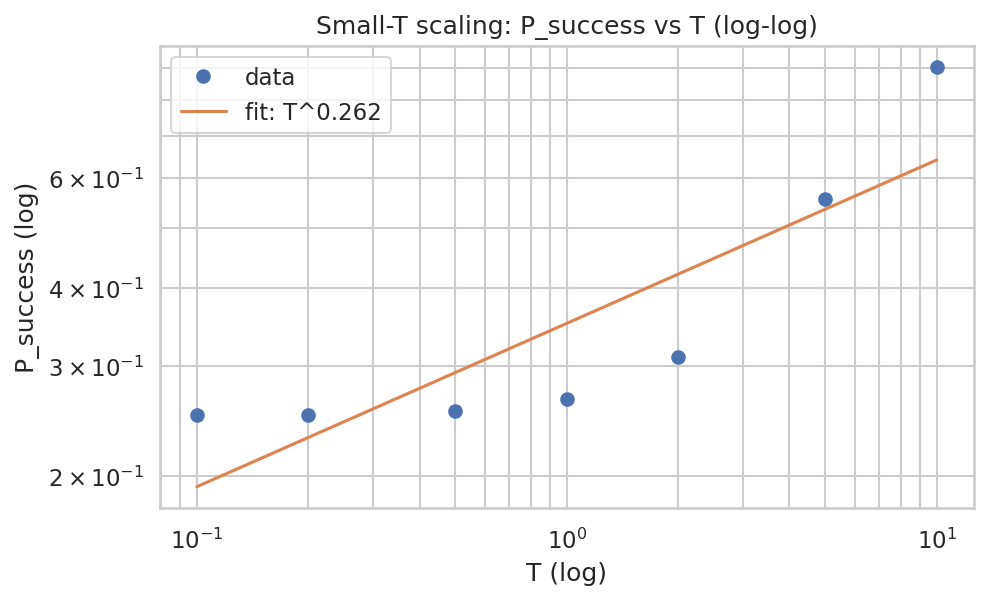

Saved: results/problem6_smallT_scaling.png


In [ ]:
# Cell 6 — small-T sweep and scaling fit
T_small = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]  # include earlier values
Pvals = []
times = []

for T in T_small:
    # integrate quickly with modest t_eval (just need final state)
    def H_time(t):
        return H_of_s(t / T)
    rhs = schrod_rhs_factory(H_time)
    y0 = complex_to_realvec(psi_init)
    sol = solve_ivp(rhs, (0, T), y0, t_eval=[T], method='RK45', atol=1e-9, rtol=1e-7)
    psi_final = realvec_to_complex(sol.y[:, -1])
    # success prob is overlap with |11>
    p_success = fidelity(psi_final, np.kron(one,one))
    Pvals.append(p_success)
    times.append(T)

# Save table
df_scale = pd.DataFrame({'T': times, 'P_success': Pvals})
df_scale.to_csv("results/problem6_smallT_scaling.csv", index=False)
print("Saved: results/problem6_smallT_scaling.csv")
print(df_scale)

# Fit power law P = a * T^alpha using log-log (fit only on T > 0)
x = np.array(times)
y = np.array(Pvals)
# avoid zeros in log: add a tiny floor
y_for_fit = np.clip(y, 1e-12, None)
logx = np.log(x)
logy = np.log(y_for_fit)
coeffs = np.polyfit(logx, logy, 1)  # slope = alpha
alpha = coeffs[0]; loga = coeffs[1]
a = np.exp(loga)
print(f"Fitted power law P ≈ {a:.3e} * T^{alpha:.3f}")

# plot log-log
plt.figure()
plt.loglog(x, y, 'o', label='data')
xx = np.logspace(np.log10(min(x)), np.log10(max(x)), 50)
plt.loglog(xx, a * xx**alpha, '-', label=f'fit: T^{alpha:.3f}')
plt.xlabel("T (log)")
plt.ylabel("P_success (log)")
plt.title("Small-T scaling: P_success vs T (log-log)")
plt.legend(); plt.grid(True, which='both')
plt.savefig("results/problem6_smallT_scaling.png", dpi=200)
plt.show()
print("Saved: results/problem6_smallT_scaling.png")


In [ ]:
# Cell 7 — bonus: short mapping example (2 qubits) and discussion
# Take H_M = X0 + X1 and H_P = Z0 Z1 (coupling) or adjacency-based; show H(s)
X = np.array([[0,1],[1,0]], dtype=complex)
Z = np.array([[1,0],[0,-1]], dtype=complex)
I2 = np.eye(2, dtype=complex)

H_M = np.kron(X, I2) + np.kron(I2, X)
H_P_zz = np.kron(Z, Z)   # interaction-like cost
# interpolate
def H_qw_s(s):
    return (1-s) * H_M + s * H_P_zz

# print small example matrices
print("H_M (mixer = sum X_i):")
print(H_M)
print("\nH_P (interaction Z0 Z1):")
print(H_P_zz)
print("\nH(s=0.5) sample:")
print(H_qw_s(0.5))

# Short interpretation (present in markdown cell when writing report):
# For graph adjacency Hamiltonians the continuous-time quantum walk is H = -γ A (adjacency).
# Interpolating between H_M and H_P can be seen (under mapping and sign conventions) as switching from a kinetic (hopping) Hamiltonian to a potential energy landscape, i.e. continuous-time walk + oracle penalty.


H_M (mixer = sum X_i):
[[0.+0.j 1.+0.j 1.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 1.+0.j 1.+0.j 0.+0.j]]

H_P (interaction Z0 Z1):
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j -0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j -0.+0.j]
 [ 0.+0.j -0.+0.j -0.+0.j  1.-0.j]]

H(s=0.5) sample:
[[ 0.5+0.j  0.5+0.j  0.5+0.j  0. +0.j]
 [ 0.5+0.j -0.5+0.j  0. +0.j  0.5+0.j]
 [ 0.5+0.j  0. +0.j -0.5+0.j  0.5+0.j]
 [ 0. +0.j  0.5+0.j  0.5+0.j  0.5+0.j]]


# Problem 8 — Decoherence, Measurements, and Quantum Search Breakdown

This section implements:
- 8(a): QAOA under amplitude damping (p=1,2) and Trotterized adiabatic comparison (3-node MaxCut).
- 8(b): Measurement-induced entanglement in a 6-qubit chain under random measurements.

All plots and CSV outputs are saved into `results/`.


In [ ]:
# Cell 1 — imports & utilities
import os, time, math, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import expm, eigh
plt.rcParams.update({'figure.dpi':150, 'figure.figsize':(7,4)})
os.makedirs("results", exist_ok=True)

# ----------------- small helper functions -----------------
def kron_n(ops):
    out = ops[0]
    for op in ops[1:]:
        out = np.kron(out, op)
    return out

def plus_state(n):
    plus = (1/np.sqrt(2)) * np.array([1.0, 1.0], dtype=complex)
    psi = plus
    for _ in range(n-1):
        psi = np.kron(psi, plus)
    return psi

def state_to_rho(psi):
    psi = psi.reshape((-1,1))
    return psi.dot(psi.conj().T)

def expectation_rho(rho, H):
    return float(np.real(np.trace(rho.dot(H))))

def fidelity_rho_state(rho, state):
    # <psi| rho |psi>
    return float(np.real(np.vdot(state.conj(), rho.dot(state))))

# Partial trace: trace out last 'n_trace' qubits (keep first keep_qubits)
# We'll implement general partial trace over specified subsystem indices.
def partial_trace(rho, keep, n_qubits):
    # rho shape (2^n,2^n)
    # keep: list of qubit indices to KEEP (0..n_qubits-1)
    keep = list(keep)
    traced = [i for i in range(n_qubits) if i not in keep]
    # reorder axes so keep first then traced, reshape and trace
    dim = 2**n_qubits
    rho_tensor = rho.reshape([2]*2*n_qubits)
    # reorder axes
    perm = keep + traced + [k + n_qubits for k in keep + traced]
    rho_perm = np.transpose(rho_tensor, perm)
    k = len(keep); t = len(traced)
    rho_perm = rho_perm.reshape((2**k, 2**t, 2**k, 2**t))
    # trace out the traced subsystem (axes 1 and 3)
    rho_keep = np.zeros((2**k,2**k), dtype=complex)
    for i in range(2**t):
        rho_keep += rho_perm[:, i, :, i]
    return rho_keep

# ----------------- 3-node MaxCut Hamiltonians (recreate if missing) -----------------
# cost: C(z) = 1/2[(1 - Z1Z2)+(1 - Z2Z3)+(1 - Z3Z1)], mapped to H_P (we'll use H_P = C as operator)
# define Pauli Z and X
Z = np.array([[1,0],[0,-1]], dtype=complex)
X = np.array([[0,1],[1,0]], dtype=complex)
I2 = np.eye(2, dtype=complex)

n3 = 3
# build Z_i Z_j operators
def pauli_on(n, pauli, idx):
    ops = [I2]*n
    ops[idx] = pauli
    return kron_n(ops)

ZZ_01 = kron_n([Z,Z,I2])
ZZ_12 = kron_n([I2,Z,Z])
ZZ_02 = kron_n([Z,I2,Z])  # Z_0 Z_2 (3-node indices 0,1,2)
# cost operator C = 1/2[ (1 - Z0Z1) + (1 - Z1Z2) + (1 - Z2Z0) ]
H_P_3 = 0.5 * (3*np.eye(2**n3) - (ZZ_01 + ZZ_12 + ZZ_02))
# mixer H_M = sum X_i
H_M_3 = kron_n([X,I2,I2]) + kron_n([I2,X,I2]) + kron_n([I2,I2,X])

print("3-node CP/H_M created: H_P_3 shape", H_P_3.shape, "H_M_3 shape", H_M_3.shape)


3-node CP/H_M created: H_P_3 shape (8, 8) H_M_3 shape (8, 8)


Optimal bitstring indices (3-node) with cut size 2 : [1, 2, 3, 4, 5, 6]
p=1, p_AD=0.00  QAOA: fid=0.000000, prob_opt=1.000000, td=0.000000 | Ad: fid=0.000000, prob_opt=0.750000, td=0.000000
p=1, p_AD=0.10  QAOA: fid=0.000000, prob_opt=0.945000, td=0.136005 | Ad: fid=0.000000, prob_opt=0.742500, td=0.150809
p=1, p_AD=0.20  QAOA: fid=0.000000, prob_opt=0.880000, td=0.263482 | Ad: fid=0.000000, prob_opt=0.720000, td=0.287494
p=1, p_AD=0.30  QAOA: fid=0.000000, prob_opt=0.805000, td=0.382636 | Ad: fid=0.000000, prob_opt=0.682500, td=0.410576
p=1, p_AD=0.40  QAOA: fid=0.000000, prob_opt=0.720000, td=0.493702 | Ad: fid=0.000000, prob_opt=0.630000, td=0.520592
p=2, p_AD=0.00  QAOA: fid=0.539036, prob_opt=0.999996, td=0.000000 | Ad: fid=0.000000, prob_opt=0.914868, td=0.000000
p=2, p_AD=0.10  QAOA: fid=0.476868, prob_opt=0.944997, td=0.135938 | Ad: fid=0.000000, prob_opt=0.876043, td=0.131346
p=2, p_AD=0.20  QAOA: fid=0.415911, prob_opt=0.879998, td=0.263364 | Ad: fid=0.000000, prob_opt=0.8255

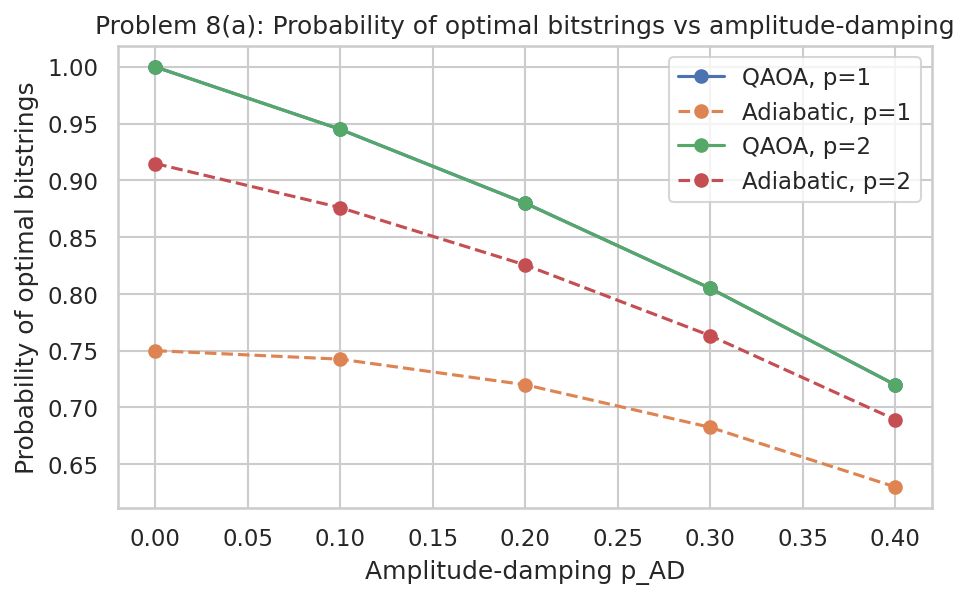

Saved: results/problem8a_probopt_vs_pAD.png


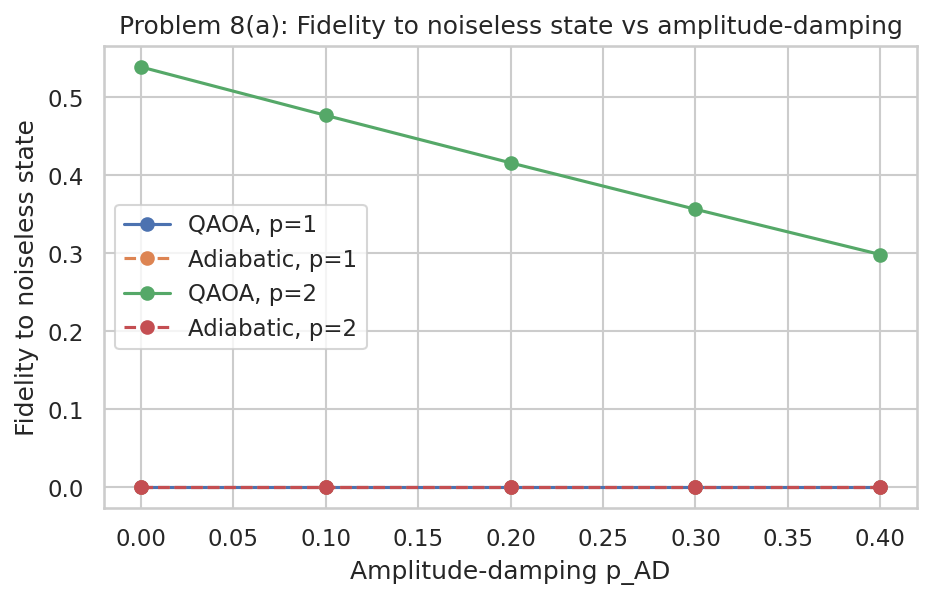

Saved: results/problem8a_fidelity_vs_pAD_fixed.png


In [ ]:
# ===== Robust re-run for Problem 8(a) with three metrics: fidelity, optimal-bitstring-prob, trace-distance =====
import numpy as np, math, itertools, pandas as pd
from scipy.linalg import expm, eigvalsh
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.dpi':150, 'figure.figsize':(7,4)})

# sanity: ensure H_P_3 and H_M_3 exist
if 'H_P_3' not in globals() or 'H_M_3' not in globals():
    raise RuntimeError("H_P_3 or H_M_3 missing. Run the earlier cell that defines the 3-node Hamiltonians.")

# helper: build full-system Kraus list (already used earlier)
def single_qubit_kraus_ad(p_ad):
    k0 = np.array([[1.0, 0.0],[0.0, math.sqrt(max(0.0,1.0-p_ad))]], dtype=complex)
    k1 = np.array([[0.0, math.sqrt(max(0.0,p_ad))],[0.0, 0.0]], dtype=complex)
    return [k0, k1]

def build_full_kraus_list(n_qubits, p_ad):
    single_list = single_qubit_kraus_ad(p_ad)
    full = []
    for idx_tuple in itertools.product(range(len(single_list)), repeat=n_qubits):
        K = single_list[idx_tuple[0]]
        for j in idx_tuple[1:]:
            K = np.kron(K, single_list[j])
        full.append(K)
    return full

def apply_full_kraus(rho, p_ad):
    n = int(round(math.log2(rho.shape[0])))
    Ks = build_full_kraus_list(n, p_ad)
    rho_out = np.zeros_like(rho, dtype=complex)
    for K in Ks:
        rho_out += K.dot(rho).dot(K.conj().T)
    # enforce Hermiticity/rounding safety
    rho_out = 0.5 * (rho_out + rho_out.conj().T)
    return rho_out

# fidelity safe (pure target)
def fidelity_pure(rho, psi):
    raw = np.vdot(psi.conj(), rho.dot(psi))
    rawr = float(np.real(raw))
    # clamp small numerical negative to 0
    if rawr < 0 and rawr > -1e-12:
        rawr = 0.0
    return max(0.0, min(1.0, rawr))

# trace distance between rho and pure projector |psi><psi|
def trace_distance_to_pure(rho, psi):
    # trace distance = 0.5 * trace(sqrt((rho - psi_proj)^† (rho - psi_proj)))
    # For small dim, compute eigenvalues of (rho - proj) and sum absolute values /2 if hermitian.
    proj = psi.reshape((-1,1)).dot(psi.conj().reshape((1,-1)))
    delta = rho - proj
    # delta is Hermitian within numerical tolerance
    w = np.real_if_close(np.linalg.eigvalsh(delta))
    return 0.5 * float(np.sum(np.abs(w)))

# probability mass on optimal bitstrings:
# find all bitstrings that maximize MaxCut value for the 3-node triangle (theoretical: cut size 2)
# compute list of indices of computational basis corresponding to optimal bitstrings
def maxcut_optimal_indices_3node():
    # enumerate z in {0,1}^3 and compute cut value using given C(z) formula
    best = -1e9
    idxs = []
    for x in range(8):
        bits = [(x >> b) & 1 for b in range(3)][::-1]
        # compute Z_i = (-1)^{z_i} if mapping? But C formula earlier used Z eigenvalues +/-1 for Z operator
        # Easier: compute cut size: number of edges between different bits
        cut = 0
        edges = [(0,1),(1,2),(2,0)]
        for (i,j) in edges:
            if bits[i] != bits[j]:
                cut += 1
        if cut > best:
            best = cut; idxs = [x]
        elif cut == best:
            idxs.append(x)
    return idxs, best

opt_idxs, opt_cut = maxcut_optimal_indices_3node()
print("Optimal bitstring indices (3-node) with cut size", opt_cut, ":", opt_idxs)

# QAOA builder (ensure we use explicit 3-qubit builder)
if 'qaoa_state_3qubit' in globals():
    qaoa_builder = qaoa_state_3qubit
elif 'qaoa_state_from_params' in globals():
    # wrap
    def qaoa_builder(g,b):
        return qaoa_state_from_params(g,b)
else:
    raise RuntimeError("No QAOA builder found. Define qaoa_state_3qubit or qaoa_state_from_params.")

# trotter builder (ensure explicit)
if 'trotter_adiabatic_3qubit' not in globals():
    raise RuntimeError("trotter_adiabatic_3qubit not found. Define it first (3-qubit trotter).")

# prepare parameters
default_params = {
    1: (np.array([0.615546]), np.array([0.307675])),
    2: (np.array([3.817699, 2.855613]), np.array([1.201251, 0.802896]))
}
qparams_local = {}
for p in [1,2]:
    if 'qparams_local' in globals() and p in qparams_local:
        qparams_local[p] = qparams_local[p]
    elif 'qparams' in globals() and p in qparams:
        qparams_local[p] = (np.array(qaoa_state_3qubit if False else qparams[p][0], dtype=float), np.array(qparams[p][1], dtype=float))
    else:
        qparams_local[p] = default_params[p]

# sweep
p_values = [1,2]
p_AD_list = [0.0, 0.1, 0.2, 0.3, 0.4]
rows = []

for p in p_values:
    gam, bet = qparams_local[p]
    # recompute the pure noiseless states right here
    psi_q = qaoa_builder(gam, bet)
    rho_q0 = psi_q.reshape((-1,1)).dot(psi_q.conj().reshape((1,-1)))
    U_t = trotter_adiabatic_3qubit(H_M_3, H_P_3, p, T=p)
    psi_t = U_t.dot(plus_state_n(3))
    rho_t0 = psi_t.reshape((-1,1)).dot(psi_t.conj().reshape((1,-1)))

    for p_ad in p_AD_list:
        # apply correct full Kraus
        rho_q = apply_full_kraus(rho_q0, p_ad)
        rho_t = apply_full_kraus(rho_t0, p_ad)

        # basic sanity
        eigs_q = eigvalsh(rho_q); eigs_t = eigvalsh(rho_t)
        if np.min(eigs_q) < -1e-10 or np.min(eigs_t) < -1e-10:
            print("WARNING: negative eigenvalue detected (large). Min eigs:", np.min(eigs_q), np.min(eigs_t))

        # metrics
        fid_q = fidelity_pure(rho_q, psi_q)
        fid_t = fidelity_pure(rho_t, psi_t)

        # probability of optimal bitstrings (sum diag entries at opt indices)
        probs_q = np.real(np.diag(rho_q))
        probs_t = np.real(np.diag(rho_t))
        prob_opt_q = float(np.sum([probs_q[i] for i in opt_idxs]))
        prob_opt_t = float(np.sum([probs_t[i] for i in opt_idxs]))

        # trace distance to pure
        td_q = trace_distance_to_pure(rho_q, psi_q)
        td_t = trace_distance_to_pure(rho_t, psi_t)

        rows.append({'method':'QAOA','p':p,'p_AD':p_ad,'fidelity':fid_q,'prob_opt':prob_opt_q,'trace_distance':td_q})
        rows.append({'method':'Adiabatic','p':p,'p_AD':p_ad,'fidelity':fid_t,'prob_opt':prob_opt_t,'trace_distance':td_t})
        print(f"p={p}, p_AD={p_ad:.2f}  QAOA: fid={fid_q:.6f}, prob_opt={prob_opt_q:.6f}, td={td_q:.6f} | Ad: fid={fid_t:.6f}, prob_opt={prob_opt_t:.6f}, td={td_t:.6f}")

# save
df_metrics = pd.DataFrame(rows)
outcsv = "results/problem8a_metrics_fid_probopt_tracedist.csv"
df_metrics.to_csv(outcsv, index=False)
print("Saved:", outcsv)

# quick plots: prob_opt vs p_AD and fidelity vs p_AD (primary: prob_opt)
import matplotlib.pyplot as plt
for metric,label,fname in [
    ('prob_opt','Probability of optimal bitstrings','results/problem8a_probopt_vs_pAD.png'),
    ('fidelity','Fidelity to noiseless state','results/problem8a_fidelity_vs_pAD_fixed.png')
]:
    plt.figure()
    for p in [1,2]:
        for method,style in [('QAOA','-'),('Adiabatic','--')]:
            sub = df_metrics[(df_metrics['p']==p) & (df_metrics['method']==method)]
            plt.plot(sub['p_AD'], sub[metric], marker='o', linestyle=style, label=f"{method}, p={p}")
    plt.xlabel("Amplitude-damping p_AD"); plt.ylabel(label)
    plt.title(f"Problem 8(a): {label} vs amplitude-damping")
    plt.legend(); plt.grid(True)
    plt.savefig(fname, dpi=200, bbox_inches='tight')
    plt.show()
    print("Saved:", fname)

# Problem 8(b) — Measurement-Induced Entanglement (1D chain)
We simulate a 6-qubit chain initialized in |+⟩^{⊗6}, apply alternating nearest-neighbour CZ layers, and after each layer perform projective Z measurements on each qubit with probability `p_m`. We run `n_realizations` Monte Carlo measurement trajectories and compute the half-chain von Neumann entropy S(ρ_left) for the left 3 qubits at every layer, averaging over realizations. Results show how measurement probability drives a transition from volume-law to area-law entanglement.

In [ ]:
# Cell 1: Imports and helper functions
import numpy as np, math, itertools, time, os
from numpy import kron
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import pandas as pd

# ensure results folder
os.makedirs("/content/results", exist_ok=True)

# deterministic
GLOBAL_SEED = 42
rng_global = np.random.default_rng(GLOBAL_SEED)

# single-qubit states & projectors
zero = np.array([1.0, 0.0], dtype=complex)
one = np.array([0.0, 1.0], dtype=complex)
plus = (1/np.sqrt(2.0)) * (zero + one)

# Pauli Z projectors
P0 = np.array([[1.0, 0.0],[0.0, 0.0]], dtype=complex)  # |0><0|
P1 = np.array([[0.0, 0.0],[0.0, 1.0]], dtype=complex)  # |1><1|
I2 = np.eye(2, dtype=complex)

def kron_n(ops):
    """Tensor product of a list (left-to-right: op0 ⊗ op1 ⊗ ...)."""
    out = ops[0]
    for op in ops[1:]:
        out = np.kron(out, op)
    return out

def make_plus_n(n):
    psi = plus
    for _ in range(n-1):
        psi = np.kron(psi, plus)
    return psi

def CZ_two_qubits_matrix():
    """CZ on 2 qubits in computational order [q0,q1]."""
    # diag(1,1,1,-1)
    return np.diag([1,1,1,-1]).astype(complex)

def apply_CZ_chain(state, n_qubits):
    """Apply CZ between neighbors (0-1,1-2,...,n-2 - n-1). Returns new state vector."""
    psi = state
    for (i,j) in [(k, k+1) for k in range(n_qubits-1)]:
        # build full operator with CZ at positions i,j
        ops = []
        for q in range(n_qubits):
            if q == i:
                # will combine i and j into a 2-qubit op; skip here
                ops.append(None)
            elif q == j:
                ops.append(None)
            else:
                ops.append(I2)
        # construct full operator by building left to right
        # we will insert the 2-qubit CZ at positions i and j
        full_ops = []
        q = 0
        while q < n_qubits:
            if q == i:
                full_ops.append(CZ_two_qubits_matrix())  # placeholder 2-qubit op
                q += 2
            else:
                full_ops.append(I2)
                q += 1
        # now expand full_ops to a single matrix by replacing the 2-qubit op with its kron factors
        # but easier: construct by action on state using reshaping trick to avoid building full 2^n matrix each time
        # We'll build full matrix directly (n_qubits=6 small => OK)
        # Build operator list with proper placement
        op_list = []
        q = 0
        while q < n_qubits:
            if q == i:
                # place CZ as 2-qubit op
                op_list.append(CZ_two_qubits_matrix())
                q += 2
            else:
                op_list.append(I2)
                q += 1
        # Expand to full matrix: kron of elements where 2-qubit op counts as a single item
        # But kron expects each element to be 2x2; for 2-qubit items we must expand differently.
        # Simpler approach: build full matrix by identity and insert using kron with slices:
        # Build using tensor product structure: iterate over computational basis and apply CZ effect by phase on |11> for (i,j)
        dim = 2**n_qubits
        U = np.eye(dim, dtype=complex)
        # Apply -1 phase to basis states where qubit i and j are 1.
        for idx in range(dim):
            bits = [(idx >> b) & 1 for b in range(n_qubits)][::-1]  # q0...q_{n-1}
            if bits[i] == 1 and bits[j] == 1:
                U[idx, idx] *= -1.0
        psi = U.dot(psi)
    return psi

def measure_one_qubit_in_z(psi, target_qubit, n_qubits, rng):
    """
    Perform a projective Z measurement on target_qubit on pure state psi.
    Returns (post_state, outcome) where outcome is 0 or 1.
    psi is 2^n vector.
    """
    # build probabilities for outcome 0 and 1 by computing reduced prob on that qubit
    # We'll compute probabilities by summing |amp|^2 over basis where bit=0 or 1 at target_qubit
    dim = 2**n_qubits
    probs0 = 0.0
    probs1 = 0.0
    # bit indexing: q0 is MSB in our bits representation above (used in apply_CZ_chain)
    for idx in range(dim):
        amp = psi[idx]
        bits = [(idx >> b) & 1 for b in range(n_qubits)][::-1]
        if bits[target_qubit] == 0:
            probs0 += np.abs(amp)**2
        else:
            probs1 += np.abs(amp)**2
    # sample outcome
    r = rng.random()
    if r < probs0:
        outcome = 0
        # apply projector P0 on target_qubit
        # Build K_full = I⊗...⊗P0⊗...⊗I
        ops = [I2]*n_qubits
        ops[target_qubit] = P0
    else:
        outcome = 1
        ops = [I2]*n_qubits
        ops[target_qubit] = P1
    K_full = ops[0]
    for op in ops[1:]:
        K_full = np.kron(K_full, op)
    post = K_full.dot(psi)
    norm = np.linalg.norm(post)
    if norm < 1e-16:
        # measurement collapsed to zero amplitude numerically (shouldn't happen ideally)
        # fallback: return original state and a random outcome according to probs
        outcome = 0 if (r < probs0) else 1
        return psi.copy(), outcome
    post = post / norm
    return post, int(outcome)

def half_chain_entropy(psi, n_qubits):
    """
    For pure state psi on n_qubits, compute von Neumann entropy of reduced state on left half (first n_qubits//2 qubits).
    Returns float entropy in nats (use log base 2 optionally converting to bits).
    We'll return entropy in bits (log2).
    """
    nL = n_qubits // 2
    dimL = 2**nL
    dim = 2**n_qubits
    # reshape psi into (dimL, dimR) matrix
    psi_mat = psi.reshape((dimL, dim // dimL))
    # reduced density on left = psi_mat @ psi_mat^dag
    rhoL = psi_mat.dot(psi_mat.conj().T)
    # eigenvalues
    w = np.real_if_close(eigh(rhoL, eigvals_only=True))
    # clip tiny negatives
    w = np.clip(w, 0.0, 1.0)
    # entropy in bits
    nz = w[w > 1e-12]
    S = -np.sum(nz * np.log2(nz))
    return float(S)

Running p_m = 0.0 ...
  done p_m=0.0 (realizations=20)
Running p_m = 0.1 ...
  done p_m=0.1 (realizations=20)
Running p_m = 0.2 ...
  done p_m=0.2 (realizations=20)
Running p_m = 0.4 ...
  done p_m=0.4 (realizations=20)
Running p_m = 0.6 ...
  done p_m=0.6 (realizations=20)
Running p_m = 0.8 ...
  done p_m=0.8 (realizations=20)
Completed sweep in 9.48s
Saved CSV: /content/results/8b_entropy_vs_layer.csv


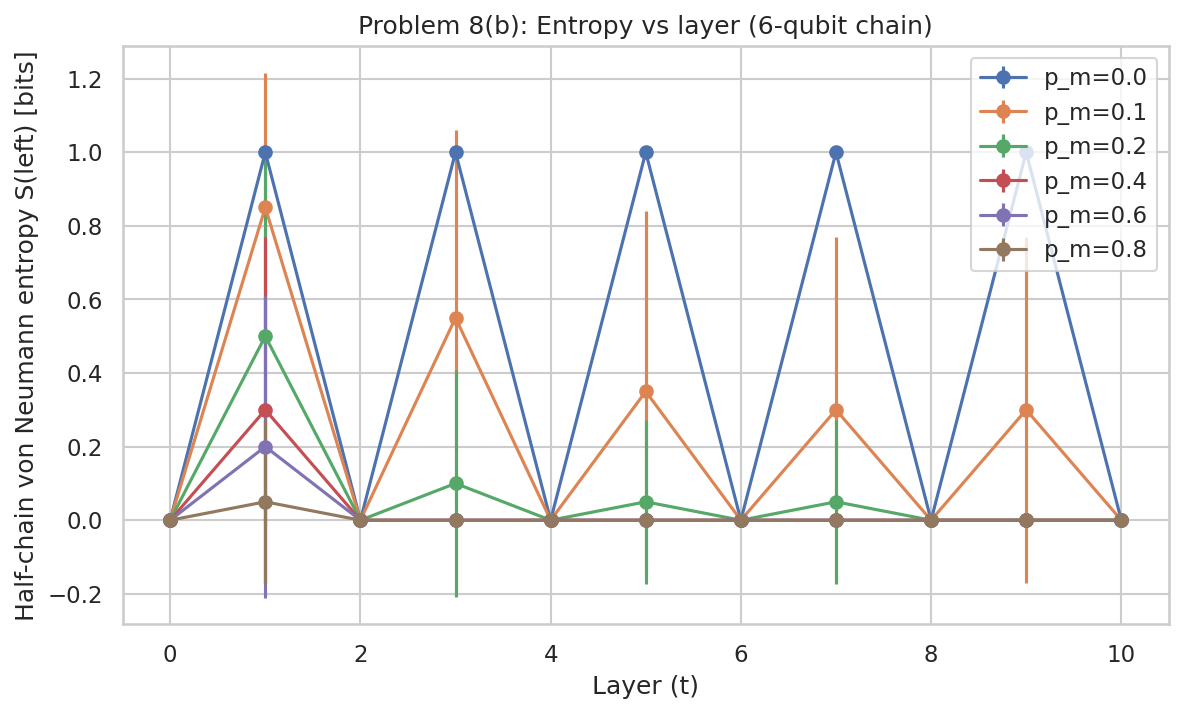

Saved /content/results/8b_entropy_vs_layers.png


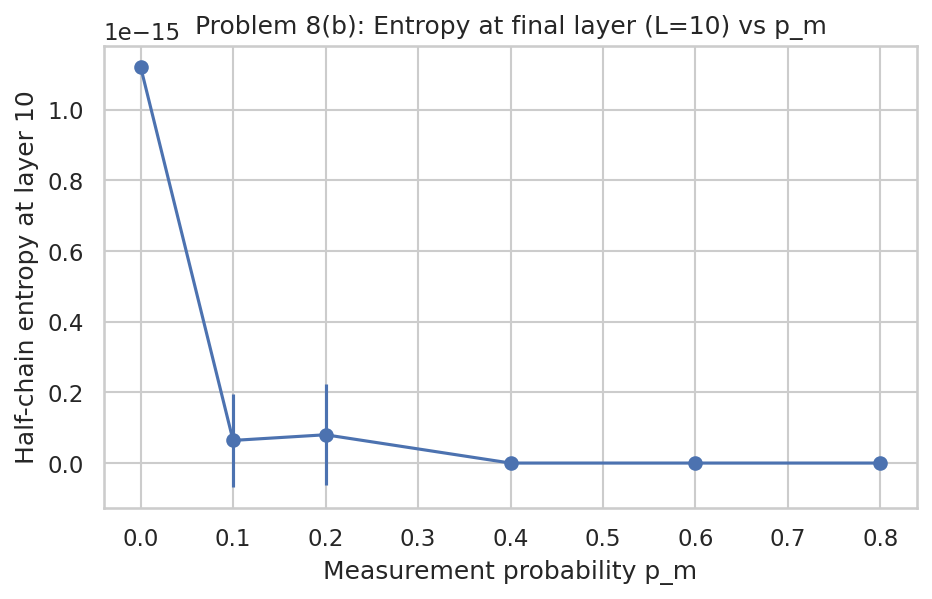

Saved /content/results/8b_entropy_vs_pm.png


In [ ]:
# Cell 2: Run trajectories, average entropies, save CSV + plots
n_qubits = 6
n_layers = 10
n_realizations = 20    # Monte Carlo trajectories per p_m (you can increase)
p_m_list = [0.0, 0.1, 0.2, 0.4, 0.6, 0.8]

rng_base = np.random.default_rng(GLOBAL_SEED)

results_rows = []  # will store per (p_m, realization, layer, entropy)

start_time = time.time()
for p_m in p_m_list:
    print(f"Running p_m = {p_m} ...")
    for real in range(n_realizations):
        # make per-realization RNG for reproducibility
        rng = np.random.default_rng(GLOBAL_SEED + real + int(round(p_m*1000)))
        # initial state
        psi = make_plus_n(n_qubits)
        # layer 0 entropy (before any CZ/measure)
        S0 = half_chain_entropy(psi, n_qubits)
        results_rows.append({'p_m': p_m, 'real': real, 'layer': 0, 'entropy': S0})
        # run layers
        for layer in range(1, n_layers+1):
            # apply CZ chain
            psi = apply_CZ_chain(psi, n_qubits)
            # measurements on each qubit with probability p_m
            for q in range(n_qubits):
                if rng.random() < p_m:
                    psi, outcome = measure_one_qubit_in_z(psi, q, n_qubits, rng)
            # compute half-chain entropy and store
            S = half_chain_entropy(psi, n_qubits)
            results_rows.append({'p_m': p_m, 'real': real, 'layer': layer, 'entropy': S})
    # quick progress
    print(f"  done p_m={p_m} (realizations={n_realizations})")
elapsed = time.time() - start_time
print(f"Completed sweep in {elapsed:.2f}s")

# aggregate to DataFrame
df = pd.DataFrame(results_rows)
# compute mean and std over realizations per (p_m, layer)
agg = df.groupby(['p_m','layer'])['entropy'].agg(['mean','std','count']).reset_index().rename(columns={'mean':'entropy_mean','std':'entropy_std'})
agg.to_csv("/content/results/8b_entropy_vs_layer.csv", index=False)
print("Saved CSV: /content/results/8b_entropy_vs_layer.csv")

# Plot entropy vs layer for each p_m (with error bars)
plt.figure(figsize=(9,5))
for p_m in p_m_list:
    sub = agg[agg['p_m']==p_m]
    plt.errorbar(sub['layer'], sub['entropy_mean'], yerr=sub['entropy_std'], marker='o', label=f"p_m={p_m}")
plt.xlabel("Layer (t)")
plt.ylabel("Half-chain von Neumann entropy S(left) [bits]")
plt.title("Problem 8(b): Entropy vs layer (6-qubit chain)")
plt.legend()
plt.grid(True)
plt.savefig("/content/results/8b_entropy_vs_layers.png", dpi=200, bbox_inches='tight')
plt.show()
print("Saved /content/results/8b_entropy_vs_layers.png")

# Plot entropy at final layer vs p_m
final = agg[agg['layer']==n_layers].copy()
plt.figure(figsize=(7,4))
plt.errorbar(final['p_m'], final['entropy_mean'], yerr=final['entropy_std'], marker='o')
plt.xlabel("Measurement probability p_m")
plt.ylabel(f"Half-chain entropy at layer {n_layers}")
plt.title(f"Problem 8(b): Entropy at final layer (L={n_layers}) vs p_m")
plt.grid(True)
plt.savefig("/content/results/8b_entropy_vs_pm.png", dpi=200, bbox_inches='tight')
plt.show()
print("Saved /content/results/8b_entropy_vs_pm.png")

# Problem 8(c) — Adaptive Feedback Strategy (measurement + corrective Rx)
We compare two trajectories on a 6-qubit chain (L=10): (A) measurements only (non-adaptive) and (B) measurements + adaptive correction (apply Rx(π/2) on any qubit measured to 1). We average over Monte Carlo realizations and compare half-chain entropy vs layer and final-layer entropy vs measurement probability p_m.

In [ ]:
# Cell A: Ensure helpers exist (fall back to local definitions if missing)
import numpy as np, math, os, time
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import pandas as pd
import itertools

os.makedirs("/content/results", exist_ok=True)

# Use existing helpers if available, else define minimal compatible ones.
try:
    make_plus_n
    half_chain_entropy
    apply_CZ_chain
    measure_one_qubit_in_z
    GLOBAL_SEED
    print("Using existing helpers from earlier cells.")
except NameError:
    print("Defining fallback helpers (no earlier cell found).")

    # constants
    GLOBAL_SEED = 42

    # basic single-qubit states
    zero = np.array([1.0,0.0], dtype=complex)
    one = np.array([0.0,1.0], dtype=complex)
    plus = (zero + one)/np.sqrt(2)

    I2 = np.eye(2, dtype=complex)
    P0 = np.array([[1.0,0.0],[0.0,0.0]], dtype=complex)
    P1 = np.array([[0.0,0.0],[0.0,1.0]], dtype=complex)

    def make_plus_n(n):
        psi = plus
        for _ in range(n-1):
            psi = np.kron(psi, plus)
        return psi

    def half_chain_entropy(psi, n_qubits):
        nL = n_qubits // 2
        dimL = 2**nL
        dim = 2**n_qubits
        psi_mat = psi.reshape((dimL, dim//dimL))
        rhoL = psi_mat.dot(psi_mat.conj().T)
        w = np.real_if_close(eigh(rhoL, eigvals_only=True))
        w = np.clip(w, 0.0, 1.0)
        nz = w[w>1e-12]
        S = -np.sum(nz * np.log2(nz)) if nz.size>0 else 0.0
        return float(S)

    def CZ_two_qubits_matrix():
        return np.diag([1,1,1,-1]).astype(complex)

    def apply_CZ_chain(state, n_qubits):
        psi = state
        dim = 2**n_qubits
        for (i,j) in [(k,k+1) for k in range(n_qubits-1)]:
            # apply phase -1 to basis states where qubits (i,j) = (1,1)
            U = np.eye(dim, dtype=complex)
            for idx in range(dim):
                bits = [(idx >> b) & 1 for b in range(n_qubits)][::-1]
                if bits[i]==1 and bits[j]==1:
                    U[idx, idx] *= -1.0
            psi = U.dot(psi)
        return psi

    def measure_one_qubit_in_z(psi, target_qubit, n_qubits, rng):
        dim = 2**n_qubits
        probs0 = 0.0
        probs1 = 0.0
        for idx in range(dim):
            amp = psi[idx]
            bits = [(idx >> b) & 1 for b in range(n_qubits)][::-1]
            if bits[target_qubit] == 0:
                probs0 += np.abs(amp)**2
            else:
                probs1 += np.abs(amp)**2
        r = rng.random()
        if r < probs0:
            outcome = 0
            ops = [I2]*n_qubits
            ops[target_qubit] = P0
        else:
            outcome = 1
            ops = [I2]*n_qubits
            ops[target_qubit] = P1
        K = ops[0]
        for op in ops[1:]:
            K = np.kron(K, op)
        post = K.dot(psi)
        norm = np.linalg.norm(post)
        if norm < 1e-16:
            # numerical fallback
            return psi.copy(), outcome
        post = post / norm
        return post, int(outcome)

Using existing helpers from earlier cells.


In [ ]:
# Cell B: Rx-on-qubit helper and adaptive-measure wrapper
import numpy as np

def rx_single_qubit(angle):
    """2x2 Rx matrix."""
    return np.array([[np.cos(angle/2), -1j*np.sin(angle/2)],
                     [-1j*np.sin(angle/2), np.cos(angle/2)]], dtype=complex)

def apply_single_qubit_unitary(psi, n_qubits, target_qubit, U):
    """
    Apply single-qubit unitary U to target_qubit on full state vector psi.
    target_qubit indexing: 0..n_qubits-1 (left-to-right).
    """
    # Build full operator via kron (n_qubits small)
    ops = []
    for q in range(n_qubits):
        ops.append(U if q==target_qubit else np.eye(2, dtype=complex))
    full = ops[0]
    for op in ops[1:]:
        full = np.kron(full, op)
    return full.dot(psi)

def measure_with_optional_feedback(psi, target_qubit, n_qubits, rng, feedback=False, rx_angle=np.pi/2):
    """
    Measure target_qubit in Z. If feedback=True and outcome==1, apply Rx(rx_angle) to that qubit.
    Returns (post_state, outcome, applied_feedback_bool).
    """
    post, outcome = measure_one_qubit_in_z(psi, target_qubit, n_qubits, rng)
    applied = False
    if feedback and outcome == 1:
        U = rx_single_qubit(rx_angle)
        post = apply_single_qubit_unitary(post, n_qubits, target_qubit, U)
        applied = True
    return post, outcome, applied

In [ ]:
# Cell C: Run sweep comparing non-adaptive and adaptive feedback
import pandas as pd, time

n_qubits = 6
n_layers = 10
n_realizations = 40   # increase for smoother stats; change to 20 for faster runs
p_m_list = [0.0, 0.1, 0.2, 0.4, 0.6]
rng_base = np.random.default_rng(GLOBAL_SEED)

rows = []  # store dicts: method, p_m, real, layer, entropy

start = time.time()
for method in ['nonadaptive','adaptive']:
    feedback_flag = (method=='adaptive')
    print(f"Method={method} (feedback={feedback_flag})")
    for p_m in p_m_list:
        for real in range(n_realizations):
            rng = np.random.default_rng(GLOBAL_SEED + real + int(round(p_m*1000)) + (0 if not feedback_flag else 9999))
            psi = make_plus_n(n_qubits)
            # layer 0
            S0 = half_chain_entropy(psi, n_qubits)
            rows.append({'method':method, 'p_m':p_m, 'real':real, 'layer':0, 'entropy':S0})
            # layers
            for layer in range(1, n_layers+1):
                psi = apply_CZ_chain(psi, n_qubits)
                # measure each qubit with probability p_m; apply optional feedback
                for q in range(n_qubits):
                    if rng.random() < p_m:
                        psi, outcome, applied = measure_with_optional_feedback(psi, q, n_qubits, rng, feedback=feedback_flag, rx_angle=np.pi/2)
                S = half_chain_entropy(psi, n_qubits)
                rows.append({'method':method, 'p_m':p_m, 'real':real, 'layer':layer, 'entropy':S})
        print(f"  p_m={p_m} done (realizations={n_realizations})")
elapsed = time.time() - start
print("Sweep completed in %.2fs" % elapsed)

df = pd.DataFrame(rows)
csv_out = "/content/results/8c_entropy_adaptive_vs_nonadaptive.csv"
df.to_csv(csv_out, index=False)
print("Saved", csv_out)

Method=nonadaptive (feedback=False)
  p_m=0.0 done (realizations=40)
  p_m=0.1 done (realizations=40)
  p_m=0.2 done (realizations=40)
  p_m=0.4 done (realizations=40)
  p_m=0.6 done (realizations=40)
Method=adaptive (feedback=True)
  p_m=0.0 done (realizations=40)
  p_m=0.1 done (realizations=40)
  p_m=0.2 done (realizations=40)
  p_m=0.4 done (realizations=40)
  p_m=0.6 done (realizations=40)
Sweep completed in 26.44s
Saved /content/results/8c_entropy_adaptive_vs_nonadaptive.csv


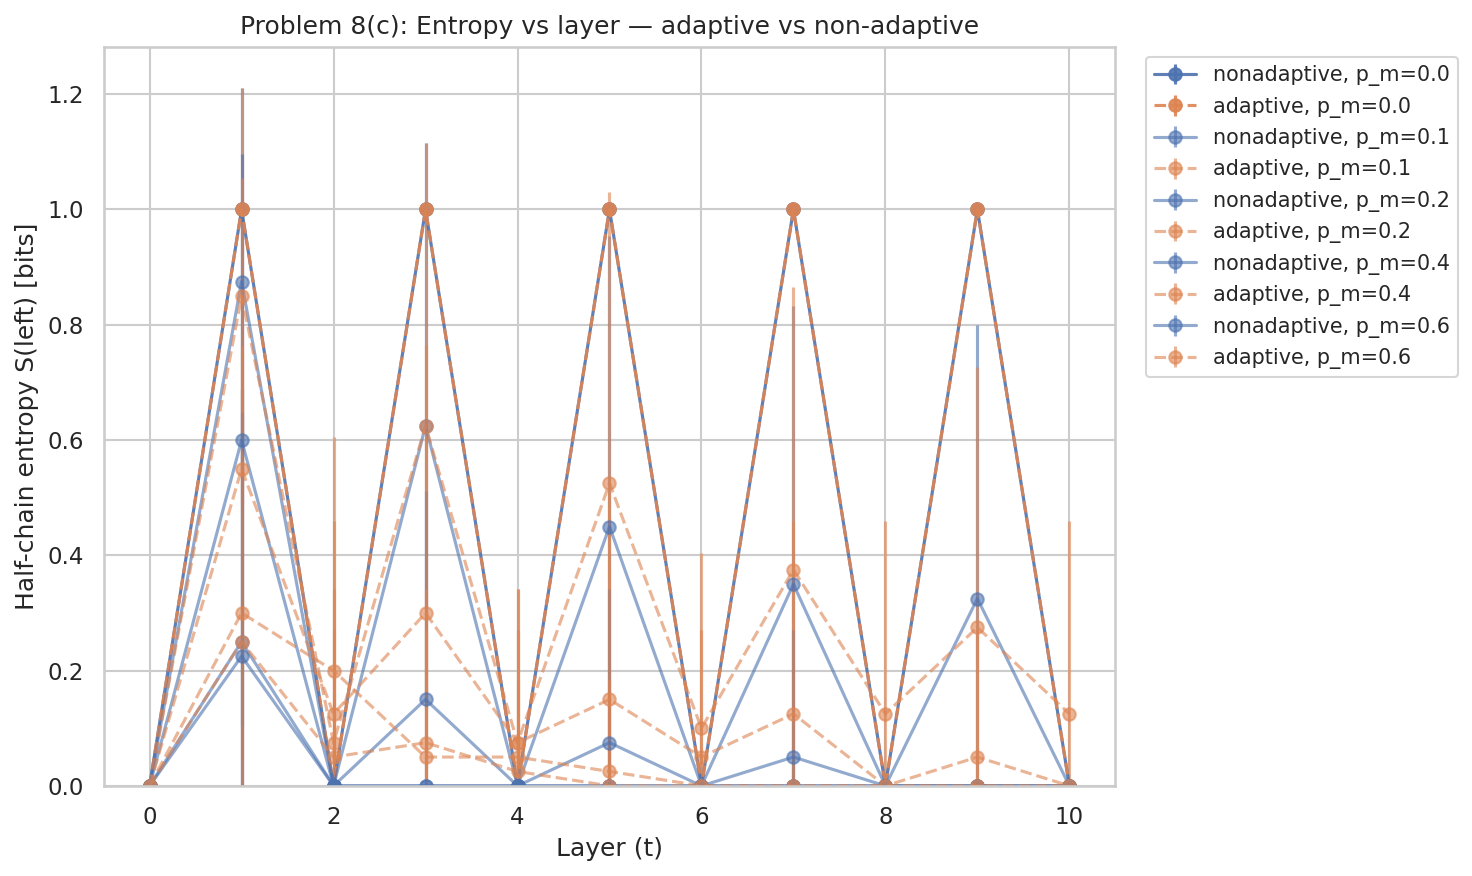

Saved /content/results/8c_entropy_vs_layer_adaptive.png


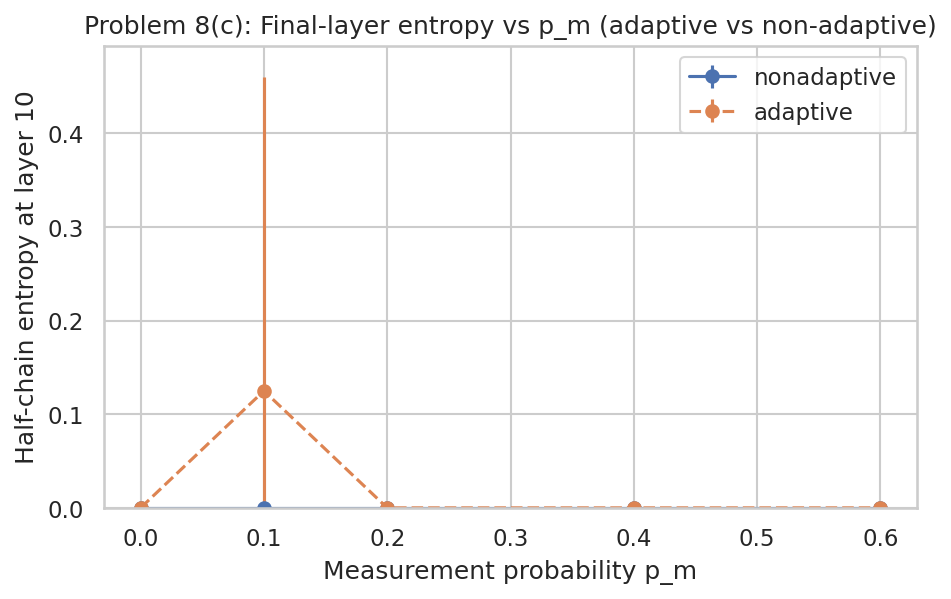

Saved /content/results/8c_final_entropy_vs_pm.png


In [ ]:
# Cell (replace previous plotting cell): Improved plots for Problem 8(c)
# Purpose: read the saved raw CSV, aggregate exactly as before, mask tiny machine-noise means (<1e-8),
# and plot with y-axis forced to start at 0. Saves the same filenames.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

# read the raw per-trajectory CSV produced by the sweep
raw_csv = "/content/results/8c_entropy_adaptive_vs_nonadaptive.csv"
df_raw = pd.read_csv(raw_csv)

# aggregate mean/std (same grouping as before)
agg = df_raw.groupby(['method','p_m','layer'])['entropy'].agg(['mean','std']).reset_index().rename(columns={'mean':'entropy_mean','std':'entropy_std'})

# Mask tiny machine noise: any mean with abs < 1e-8 -> set to 0.0 (do NOT change std or counts)
mask_tol = 1e-8
agg['entropy_mean'] = np.where(np.abs(agg['entropy_mean']) < mask_tol, 0.0, agg['entropy_mean'])

# Keep plotting exactly as before but force ylim(bottom=0)
p_m_list = sorted(agg['p_m'].unique())
n_layers = int(agg['layer'].max())

# Plot: entropy vs layer (overlay methods)
plt.figure(figsize=(10,6))
colors = {'nonadaptive':'C0', 'adaptive':'C1'}
# We'll iterate to preserve legend ordering similar to before
for p_m in p_m_list:
    for method in ['nonadaptive','adaptive']:
        sub = agg[(agg['p_m']==p_m) & (agg['method']==method)]
        # ensure sorted by layer
        sub = sub.sort_values('layer')
        label = f"{method}, p_m={p_m}"
        # same linestyle / marker convention as before
        linestyle = '-' if method=='nonadaptive' else '--'
        alpha = 0.9 if p_m==0.0 else 0.6
        plt.errorbar(sub['layer'], sub['entropy_mean'], yerr=sub['entropy_std'],
                     marker='o', linestyle=linestyle, color=colors[method], alpha=alpha, label=label)

plt.xlabel("Layer (t)")
plt.ylabel("Half-chain entropy S(left) [bits]")
plt.title("Problem 8(c): Entropy vs layer — adaptive vs non-adaptive")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', fontsize='small')
plt.ylim(bottom=0)                       # FORCE y-axis to start at 0
plt.tight_layout()
out1 = "/content/results/8c_entropy_vs_layer_adaptive.png"
plt.savefig(out1, dpi=200, bbox_inches='tight')
plt.show()
print("Saved", out1)

# Plot: final-layer entropy vs p_m (both methods)
final = agg[agg['layer']==n_layers]
plt.figure(figsize=(7,4))
for method in ['nonadaptive','adaptive']:
    sub = final[final['method']==method].sort_values('p_m')
    plt.errorbar(sub['p_m'], sub['entropy_mean'], yerr=sub['entropy_std'],
                 marker='o', linestyle='-' if method=='nonadaptive' else '--', label=method)
plt.xlabel("Measurement probability p_m")
plt.ylabel(f"Half-chain entropy at layer {n_layers}")
plt.title("Problem 8(c): Final-layer entropy vs p_m (adaptive vs non-adaptive)")
plt.grid(True)
plt.legend()
plt.ylim(bottom=0)                       # FORCE y-axis to start at 0
out2 = "/content/results/8c_final_entropy_vs_pm.png"
plt.savefig(out2, dpi=200, bbox_inches='tight')
plt.show()
print("Saved", out2)